

# Fall 2019 Computer Vision Project Deliverable 3



## Objective

 The problem we are trying to solve is to see whether fingerprinting classifiers can adapt to image privacy methods applied to training/testing data.  If not, the privacy methods will be shown to provide sufficient protection, or can be utilized by bad actors to pass fake data as authentic.


We are focusing on these 4 privacy methods in this project: vanilla pixelization (aka. mosaicing)/blurring functions and their dp versions. 

## Methodology

1. Collection of dataset
 - We used CelebA dataset which contains around 200,000 images.
 - cropped images to 128 X 128 with center being the point (89,12) ,followed by converting the images to png 
2. Applying adverserial effects to the original images and later on we we apply these same effects to the output of the ProGAN      generated images.
3. Training the ProGAN with 100,000 real images 
4. Generating ProGAN images with different seeds
- From the paper which we have taken for reference [Attributing Fake Images to GANs: Learning and Analyzing GAN Fingerprints]has proved that each GAN generated images have a unique fingerprints and these unique fingerprints helps in identifying the image source i.e. ProGAN seed0,ProGAN seed1,ProGAN seed2,ProGAN seed3 till ProGAN seed9
- On total we get 100,000 images (10000 each from the ProGANseedv# 0 to 9)
5. Classification train(without perturbing the generated images)
- We train our classifier with 10000 real images + 100,000 ProGAN generated images 
6. Classification test (without perturbing the generated images)
- We test the model with 200 images and calulate the evaluation metrices

7. Classification train(with perturbed images)
- we train our classifier with different perturbed images i.e we get 8 models total each model for each type of perturbed method

8. Classification test (with perturbed images)
- we test the classifier (8 models) and calcualte evaluation metrices


    

 CelebA Cropped and centered : https://drive.google.com/drive/folders/0B7EVK8r0v71pbWNEUjJKdDQ3dGc?usp=sharing

### Data:

First, we created our initial dataset using the first 20,000 images from the CelebA dataset.
Below is a link to the zipped dataset:

https://drive.google.com/open?id=1I977UFcGxKMe5maNbuJS9_UBBtRhE-jx

(NOTE: You'll want to create a folder in this file's parent directory and name it


Next, we prepared our dataset for training by using four different image obfuscation methods:
pixelation, pixelation with differential privacy, Gaussian blur, and Gaussian blur with differential privacy.


In [2]:
import cv2
import numpy as np
import math
import os

In [3]:
!pwd

/home/ubuntu/GANFingerprints


In [8]:
## Specifying necessary paths for retreiving input images and saving corresponding output images 
input_image_path = "images/real"
pixelization_path = 'images/real_pixel/'
pixelization_dp_path = 'images/real_pixeldp/'
gaussian_path = 'images/real_gaussian/'
gaussian_dp_path = 'images/real_gaussiandp/'

## initialising necessary variables
block_size = 16
b0 = 4
# number_of_images = len([name for name in os.listdir(input_image_path) if os.path.isfile(os.path.join(input_image_path, name))])

In [9]:
list1 = os.listdir(input_image_path) # dir is your directory path
number_files = len(list1)
print (number_files)

20000



**Pixelation**


In [10]:
## vanilla pixelization with input imArray (RGB), block size b

def pixelization(imArray, b):
    h, w, channels = imArray.shape

    h1 = math.ceil(h/b)
    w1 = math.ceil(w/b)

    blur = cv2.resize(imArray, (w1,h1), interpolation = cv2.INTER_NEAREST)
    return blur


**Pixelation with differential privacy**


In [18]:
## differentially private pixelization, additional params are: privacy
## budget epsilon, number of pixels to protect m. delta_p should be kept at 255.

def pixelization_dp(imArray, b, epsilon=0.5, m=16, delta_p = 255):  
    vals = imArray.shape

    ## adapted to handle both grayscale and RGB
    if len(vals) ==2:
        h,w = vals
        channels = 1
    elif len(vals) ==3:
        h, w, channels = vals

    if m > h*w:  ## if m is larger than image size
        m = h*w 
        
    h1 = math.ceil(h/b)
    w1 = math.ceil(w/b)


    ## basic blur NP
    blur = cv2.resize(imArray, (w1,h1), interpolation = cv2.INTER_NEAREST)

    ## DP blur
    loc, scale = 0, delta_p*m*channels/(b*b*epsilon)
    blur_dp = blur.copy()


    i=0
    j=0
    while i<h1:
        while j<w1:
            avg = blur_dp[i,j]
            s = np.random.laplace(loc, scale, channels)
            noisy_avg = avg + s
            for elem in np.nditer(noisy_avg, op_flags=['readwrite']):
            
                if elem > 255:
                    elem[...] = 255
                elif elem < 0:
                    elem[...] = 0
                else:
                    elem[...] = int(elem)
                    
            blur_dp[i,j] = noisy_avg 
            j=j+1
        i=i+1
        j=0


    return blur_dp


**Gaussian blur**


In [17]:
## vanilla gaussian blur with input imArray, kernel size k
    
def gaussian_blur(imArray,k):
    blur = cv2.GaussianBlur(imArray,(k,k), 0, borderType=cv2.BORDER_REPLICATE)
    return blur


**Gaussian blur with differential privacy**


In [16]:
## differentially private gaussian blur, additional params are: privacy
## budget epsilon, number of pixels to protect m.

def gaussianblur_dp(imArray, k, b0, epsilon=0.5, m=16):
    vals = imArray.shape

    if len(vals) ==2:
        h,w = vals
        channels = 1
    elif len(vals) ==3:
        h, w, channels = vals


    ## basic gaussian blur NP
    blur = cv2.GaussianBlur(imArray,(k,k), 0, borderType=cv2.BORDER_REPLICATE)

    
    ## DP blur
    if m> h*w:
        m= h*w

    ## pixelize, perturb, and then blur
    ## b0 is intermidiate block size, should be a small value, eg, 2, 4, 6
    blur_dp = pixelization_dp(imArray, b0, epsilon, m)
     
    blur_dp = cv2.resize(blur_dp, (w,h), interpolation = cv2.INTER_NEAREST)

    gaussian_dp = cv2.GaussianBlur(blur_dp, (k,k), 0, borderType=cv2.BORDER_REPLICATE)

    return gaussian_dp


The following code uses the above functions to generate our obfuscated images:


In [15]:
#loading real images from the folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [19]:

## creating the data from the input images with epsilon value 0.5
for filename in os.listdir(input_image_path):
    image = cv2.imread(os.path.join(input_image_path,filename))
    image_pixelization = pixelization(image, block_size)
    cv2.imwrite(os.path.join(pixelization_path,filename), image_pixelization)
    
    image_gaussian_blur = gaussian_blur(image, 45)
    cv2.imwrite(os.path.join(gaussian_path,filename), image_gaussian_blur)
    
    image_pixelization_dp = pixelization_dp(image, block_size)
    cv2.imwrite(os.path.join(pixelization_dp_path,filename), image_pixelization_dp)
    
    image_gaussian_blur_dp = gaussianblur_dp(image, 45, b0)
    cv2.imwrite(os.path.join(gaussian_dp_path,filename), image_gaussian_blur_dp)


Here are a few examples of our data:


In [29]:
# TODO: Display small subset of images (include original, pixelated, DP-pixelated, blurred, and DP-blurred to show comparison)
from glob import glob
multipleImages = glob('images/real/**')
pixelizationImages = glob('images/real_pixel/**')
pixelization_dpImages = glob('images/real_pixeldp/**')
gaussian_pathImages = glob('images/real_gaussian/**')
gaussian_dpImages = glob('images/real_gaussiandp/**')
Progan_seed_0 =glob('ProGAN/gen/progan_v0/**')
Progan_seed_1 =glob('ProGAN/gen/progan_v1/**')
Progan_seed_2 =glob('ProGAN/gen/progan_v2/**')
Progan_seed_3 =glob('ProGAN/gen/progan_v3/**')
Progan_seed_4 =glob('ProGAN/gen/progan_v4/**')
Progan_seed_5 =glob('ProGAN/gen/progan_v5/**')
Progan_seed_6 =glob('ProGAN/gen/progan_v6/**')
Progan_seed_7 =glob('ProGAN/gen/progan_v7/**')
Progan_seed_8 =glob('ProGAN/gen/progan_v8/**')
Progan_seed_9 =glob('ProGAN/gen/progan_v9/**')

# Progan=glob('../ProGAN/gen/celeba_align_png_cropped/**')
# SNGAN=glob('../SNGAN/gen/celeba_align_png_cropped/**')

In [21]:
import random
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [22]:
def plotImages2(path):
    r = random.sample(path, 9)
    plt.figure(figsize=(20,20))
    plt.subplot(331)
    plt.imshow(cv2.imread(r[0])); plt.axis('off')
    plt.subplot(332)
    plt.imshow(cv2.imread(r[1])); plt.axis('off')
    plt.subplot(333)
    plt.imshow(cv2.imread(r[2])); plt.axis('off')
    plt.subplot(334)
    plt.imshow(cv2.imread(r[3])); plt.axis('off')
    plt.subplot(335)
    plt.imshow(cv2.imread(r[4])); plt.axis('off')
    plt.subplot(336)
    plt.imshow(cv2.imread(r[5])); plt.axis('off')
    plt.subplot(337)
    plt.imshow(cv2.imread(r[6])); plt.axis('off')
    plt.subplot(338)
    plt.imshow(cv2.imread(r[7])); plt.axis('off')
    plt.subplot(339)
    plt.imshow(cv2.imread(r[8])); plt.axis('off')

## Original Images

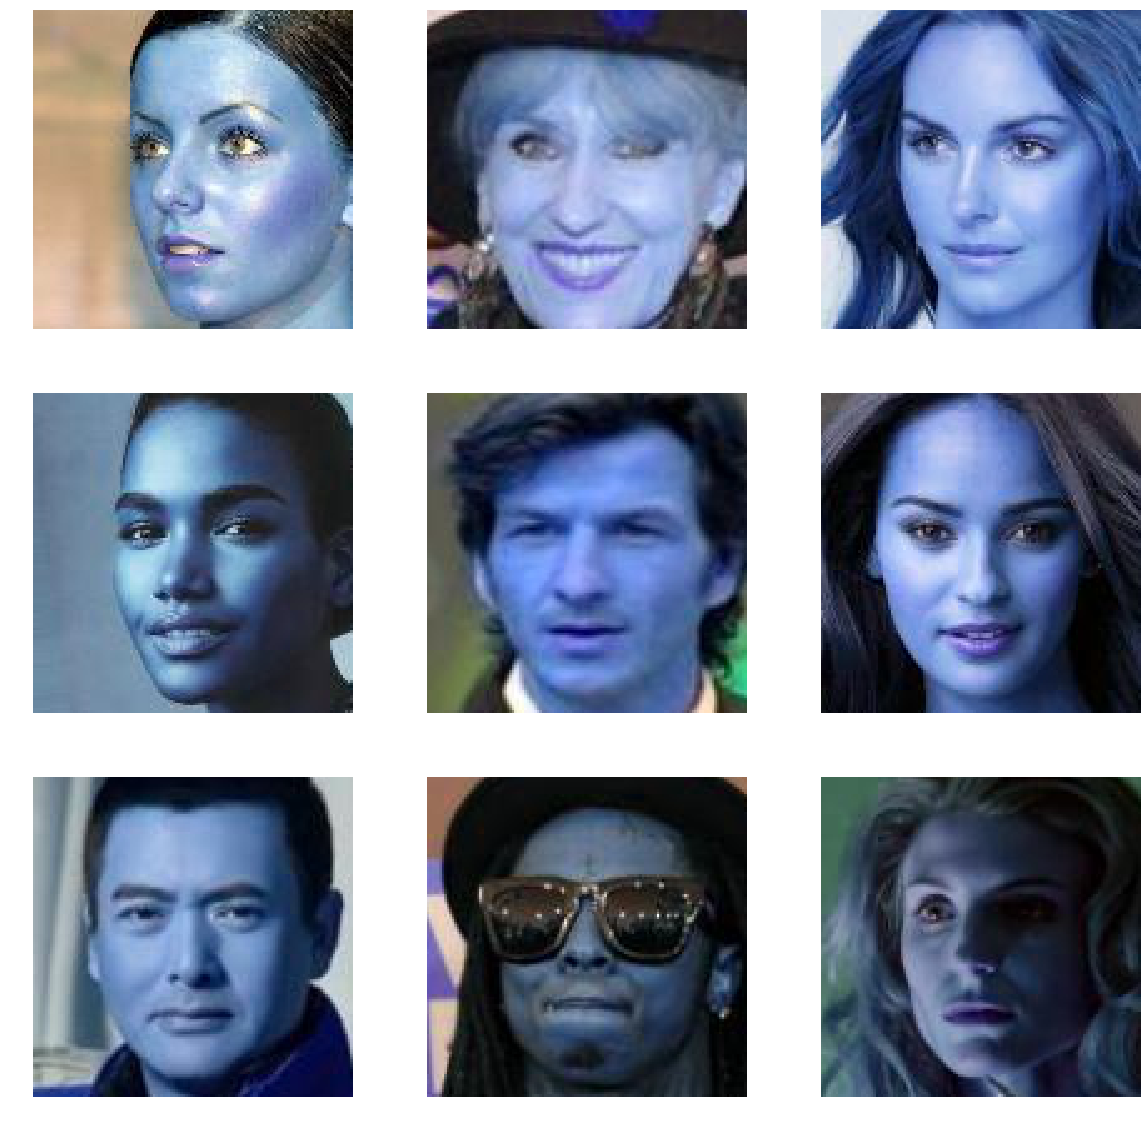

In [23]:
plotImages2(multipleImages)

## pixelizationImages on original images

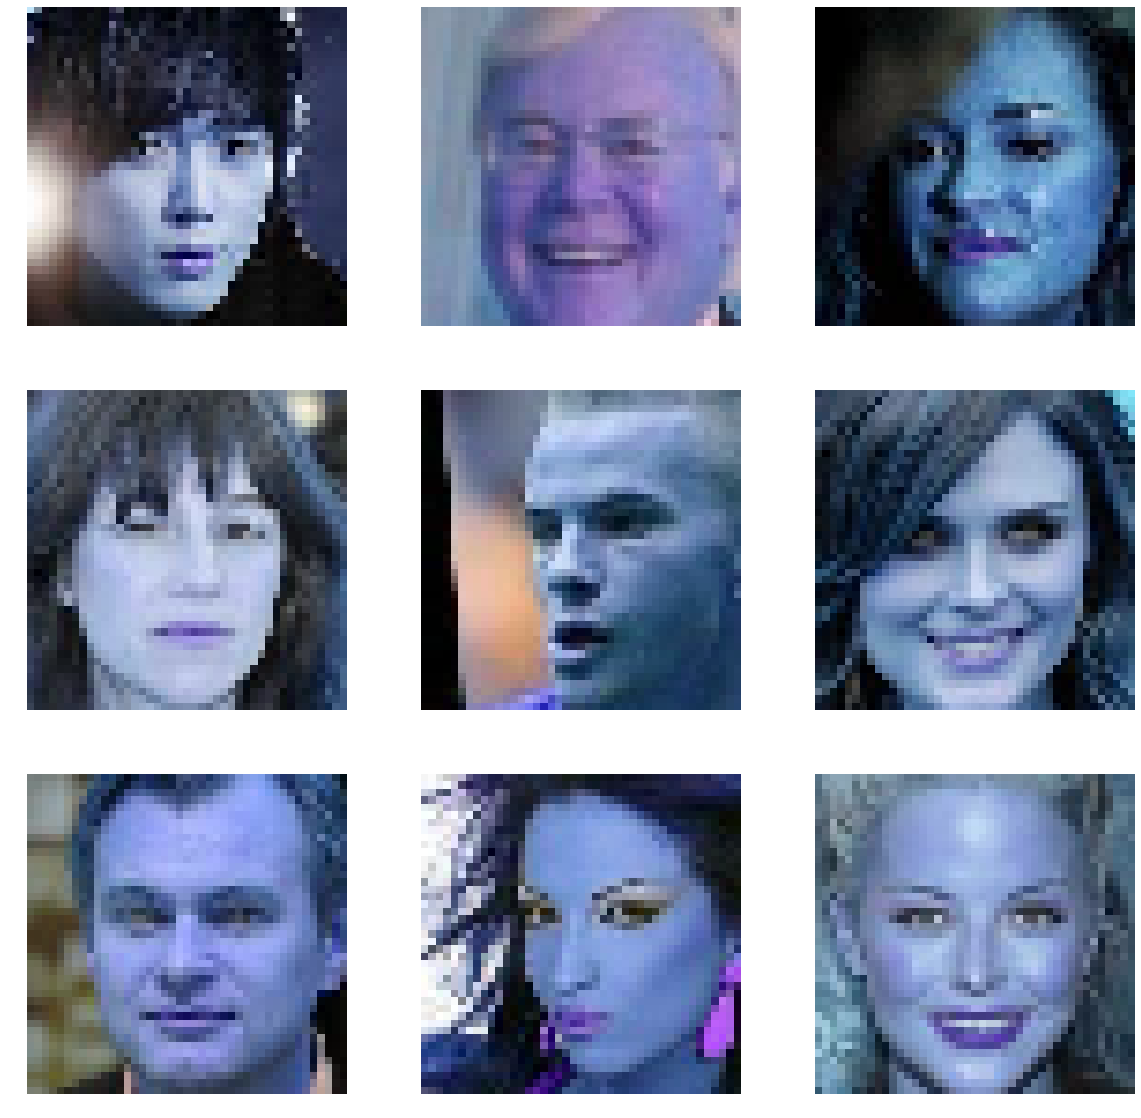

In [24]:
plotImages2(pixelizationImages)

## pixelization_dpImages on Original images

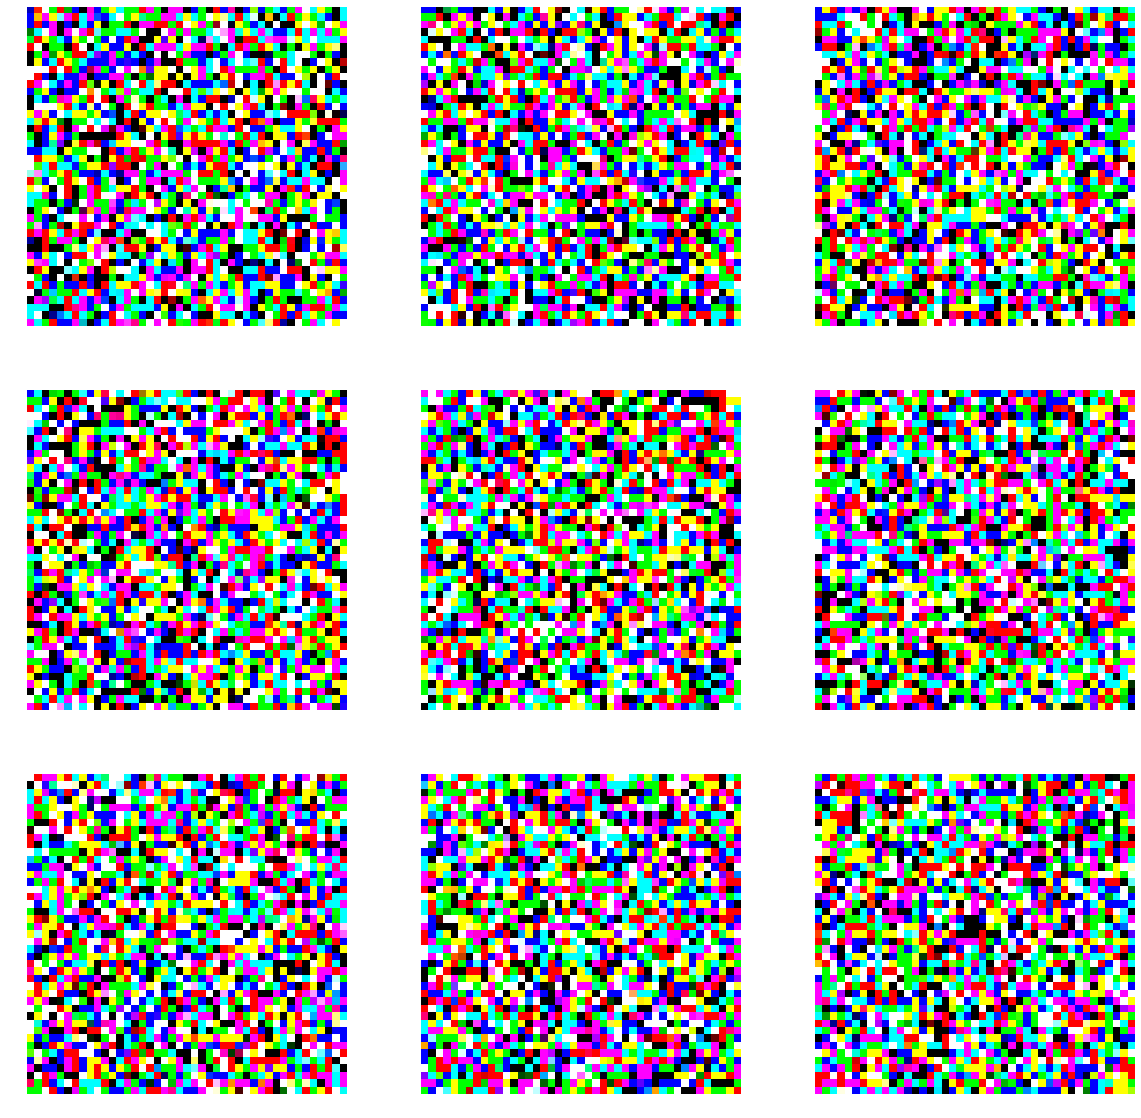

In [25]:
plotImages2(pixelization_dpImages)

## gaussian on Original Images

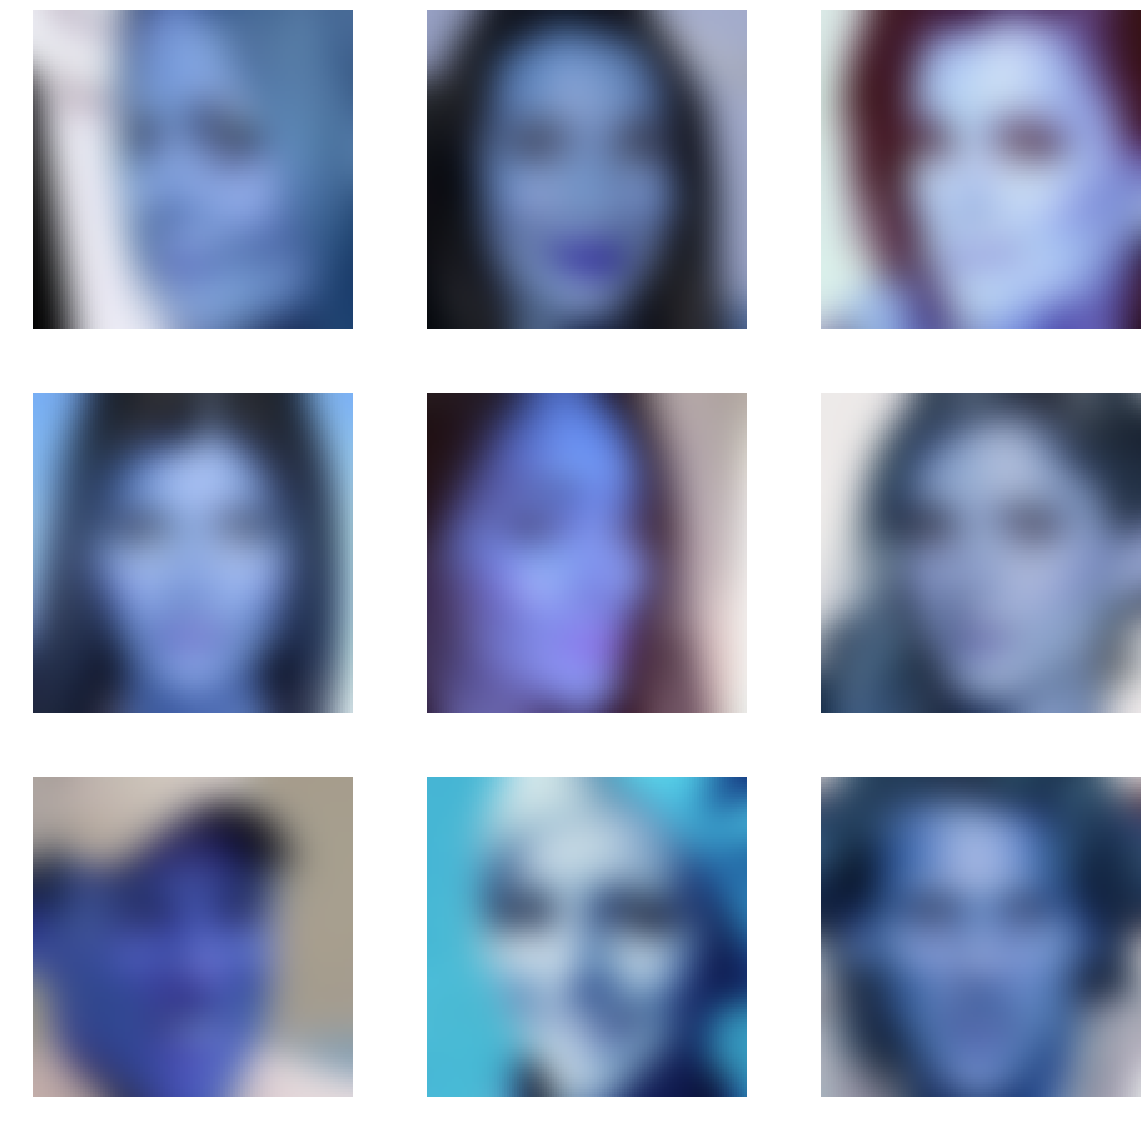

In [26]:
plotImages2(gaussian_pathImages)

## gaussian_differential privacy on Original Image

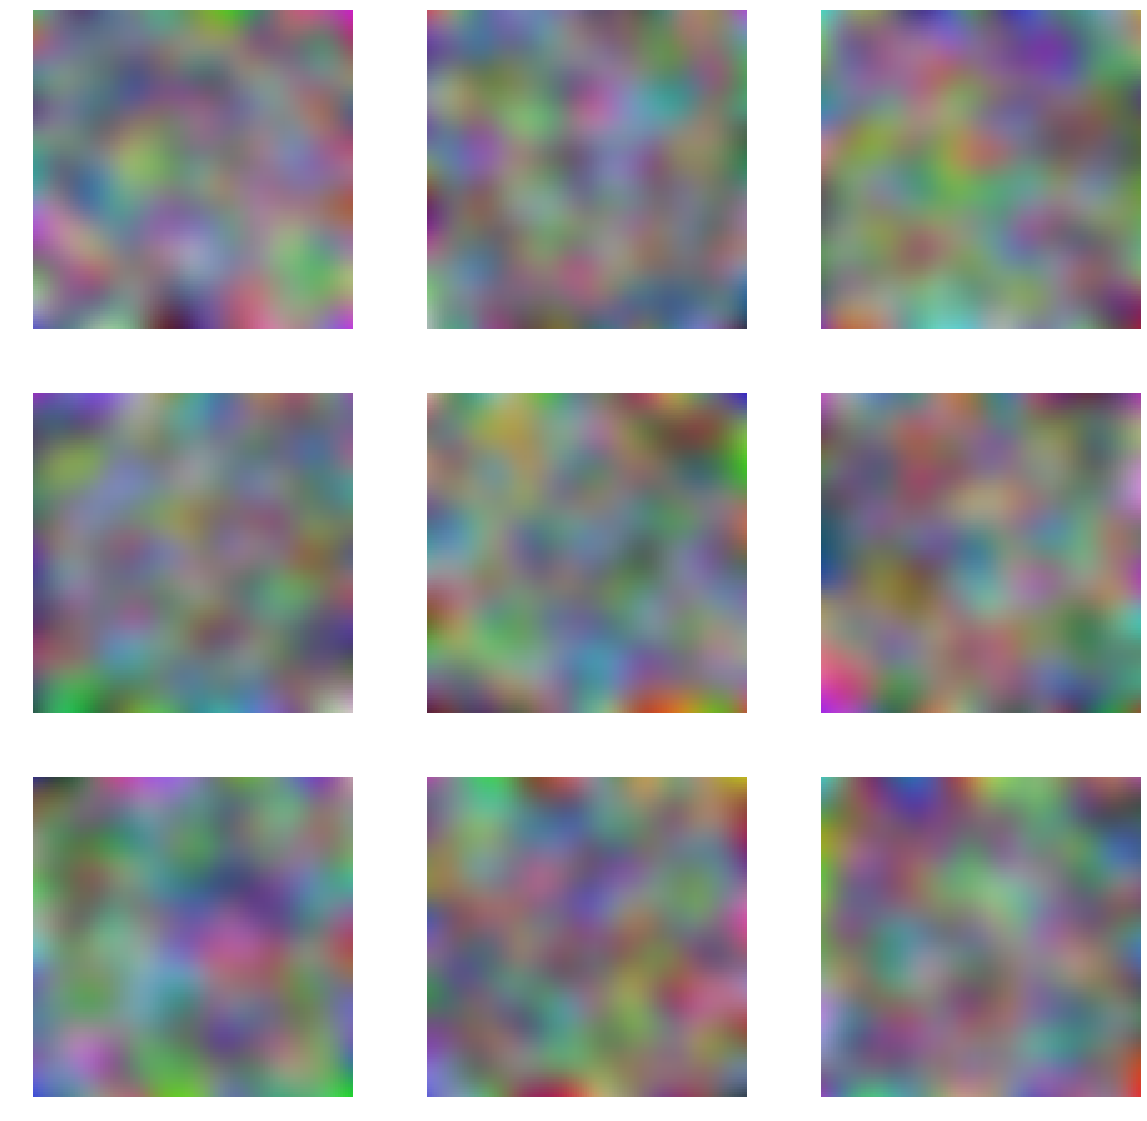

In [27]:
plotImages2(gaussian_dpImages)


After preparing our real data, we implemented ProGAN to generate fake data.


# ProGAN training

In [34]:
!pwd

/home/ubuntu/GANFingerprints


## Data creation

In [35]:
!python3 ProGAN/dataset_tool.py \
create_from_images \
classifier/datasets/celeba_align_png_cropped/ \
ProGAN/gen/real2/

Loading images from "ProGAN/gen/real2/"
Creating dataset "classifier/datasets/celeba_align_png_cropped/"



Added 10000 images.                     


### Training for seed0

In [38]:
!python3 ProGAN/run.py \
--app train \
--training_data_dir classifier/datasets/celeba_align_png_cropped/ \
--out_model_dir models/seed0 \
--training_seed 0

Initializing TensorFlow...




Streaming data using dataset.TFRecordDataset...


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [3, 128, 128]
Dynamic range = [0, 255]
Label size    = 0
Constructing networks...


G                           Params      OutputShape             WeightShape             
---                         ---         ---                     ---                     
latents_in                  -           (?, 512)               

Downscale2D_2               -           (?, 3, 16, 16)          -                       
FromRGB_lod3                2048        (?, 512, 16, 16)        (1, 1, 3, 512)          
Grow_lod2                   -           (?, 512, 16, 16)        -                       
16x16/Conv0                 2359808     (?, 512, 16, 16)        (3, 3, 512, 512)        
16x16/Conv1_down            2359808     (?, 512, 8, 8)          (3, 3, 512, 512)        
Downscale2D_3               -           (?, 3, 8, 8)            -                       
FromRGB_lod4                2048        (?, 512, 8, 8)          (1, 1, 3, 512)          
Grow_lod3                   -           (?, 512, 8, 8)          -                       
8x8/Conv0                   2359808     (?, 512, 8, 8)          (3, 3, 512, 512)        
8x8/Conv1_down              2359808     (?, 512, 4, 4)          (3, 3, 512, 512)        
Downscale2D_4               -           (?, 3, 4, 4)            -                       
FromRGB_lod5         

tick 42    kimg 86.0     lod 5.00  minibatch 512  time 1m 18s       sec/tick 1.4     sec/kimg 0.68    maintenance 0.0
tick 43    kimg 88.1     lod 5.00  minibatch 512  time 1m 19s       sec/tick 1.4     sec/kimg 0.68    maintenance 0.0
tick 44    kimg 90.1     lod 5.00  minibatch 512  time 1m 20s       sec/tick 1.4     sec/kimg 0.68    maintenance 0.0
tick 45    kimg 92.2     lod 5.00  minibatch 512  time 1m 22s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 46    kimg 94.2     lod 5.00  minibatch 512  time 1m 23s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 47    kimg 96.3     lod 5.00  minibatch 512  time 1m 25s       sec/tick 1.4     sec/kimg 0.68    maintenance 0.0
tick 48    kimg 98.3     lod 5.00  minibatch 512  time 1m 26s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 49    kimg 100.4    lod 5.00  minibatch 512  time 1m 27s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 50    kimg 102.4    lod 5.00  minibatch 512  time 1

tick 112   kimg 229.4    lod 5.00  minibatch 512  time 2m 58s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 113   kimg 231.4    lod 5.00  minibatch 512  time 2m 59s       sec/tick 1.4     sec/kimg 0.68    maintenance 0.0
tick 114   kimg 233.5    lod 5.00  minibatch 512  time 3m 00s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 115   kimg 235.5    lod 5.00  minibatch 512  time 3m 02s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 116   kimg 237.6    lod 5.00  minibatch 512  time 3m 03s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 117   kimg 239.6    lod 5.00  minibatch 512  time 3m 05s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 118   kimg 241.7    lod 5.00  minibatch 512  time 3m 06s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 119   kimg 243.7    lod 5.00  minibatch 512  time 3m 07s       sec/tick 1.4     sec/kimg 0.68    maintenance 0.0
tick 120   kimg 245.8    lod 5.00  minibatch 512  time 3

tick 182   kimg 372.7    lod 5.00  minibatch 512  time 4m 36s       sec/tick 1.4     sec/kimg 0.68    maintenance 0.0
tick 183   kimg 374.8    lod 5.00  minibatch 512  time 4m 37s       sec/tick 1.4     sec/kimg 0.68    maintenance 0.0
tick 184   kimg 376.8    lod 5.00  minibatch 512  time 4m 39s       sec/tick 1.4     sec/kimg 0.68    maintenance 0.0
tick 185   kimg 378.9    lod 5.00  minibatch 512  time 4m 40s       sec/tick 1.4     sec/kimg 0.68    maintenance 0.0
tick 186   kimg 380.9    lod 5.00  minibatch 512  time 4m 41s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 187   kimg 383.0    lod 5.00  minibatch 512  time 4m 43s       sec/tick 1.4     sec/kimg 0.68    maintenance 0.0
tick 188   kimg 385.0    lod 5.00  minibatch 512  time 4m 44s       sec/tick 1.4     sec/kimg 0.68    maintenance 0.0
tick 189   kimg 387.1    lod 5.00  minibatch 512  time 4m 46s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 190   kimg 389.1    lod 5.00  minibatch 512  time 4

tick 252   kimg 516.1    lod 5.00  minibatch 512  time 6m 14s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 253   kimg 518.1    lod 5.00  minibatch 512  time 6m 16s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 254   kimg 520.2    lod 5.00  minibatch 512  time 6m 17s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 255   kimg 522.2    lod 5.00  minibatch 512  time 6m 19s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 256   kimg 524.3    lod 5.00  minibatch 512  time 6m 20s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 257   kimg 526.3    lod 5.00  minibatch 512  time 6m 21s       sec/tick 1.4     sec/kimg 0.68    maintenance 0.0
tick 258   kimg 528.4    lod 5.00  minibatch 512  time 6m 23s       sec/tick 1.4     sec/kimg 0.67    maintenance 0.0
tick 259   kimg 530.4    lod 5.00  minibatch 512  time 6m 24s       sec/tick 1.4     sec/kimg 0.68    maintenance 0.0
tick 260   kimg 532.5    lod 5.00  minibatch 512  time 6

tick 322   kimg 629.8    lod 4.95  minibatch 256  time 10m 12s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 323   kimg 630.8    lod 4.95  minibatch 256  time 10m 18s      sec/tick 5.9     sec/kimg 5.73    maintenance 0.0
tick 324   kimg 631.8    lod 4.95  minibatch 256  time 10m 23s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 325   kimg 632.8    lod 4.95  minibatch 256  time 10m 29s      sec/tick 5.9     sec/kimg 5.73    maintenance 0.0
tick 326   kimg 633.9    lod 4.95  minibatch 256  time 10m 35s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 327   kimg 634.9    lod 4.94  minibatch 256  time 10m 41s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 328   kimg 635.9    lod 4.94  minibatch 256  time 10m 47s      sec/tick 5.8     sec/kimg 5.69    maintenance 0.0
tick 329   kimg 636.9    lod 4.94  minibatch 256  time 10m 53s      sec/tick 5.9     sec/kimg 5.72    maintenance 0.0
tick 330   kimg 638.0    lod 4.94  minibatch 256  time 1

tick 392   kimg 701.4    lod 4.83  minibatch 256  time 17m 02s      sec/tick 5.8     sec/kimg 5.71    maintenance 0.0
tick 393   kimg 702.5    lod 4.83  minibatch 256  time 17m 08s      sec/tick 5.8     sec/kimg 5.71    maintenance 0.0
tick 394   kimg 703.5    lod 4.83  minibatch 256  time 17m 14s      sec/tick 5.9     sec/kimg 5.72    maintenance 0.0
tick 395   kimg 704.5    lod 4.83  minibatch 256  time 17m 20s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 396   kimg 705.5    lod 4.83  minibatch 256  time 17m 26s      sec/tick 5.9     sec/kimg 5.72    maintenance 0.0
tick 397   kimg 706.6    lod 4.82  minibatch 256  time 17m 32s      sec/tick 5.9     sec/kimg 5.72    maintenance 0.0
tick 398   kimg 707.6    lod 4.82  minibatch 256  time 17m 38s      sec/tick 5.9     sec/kimg 5.72    maintenance 0.0
tick 399   kimg 708.6    lod 4.82  minibatch 256  time 17m 43s      sec/tick 5.9     sec/kimg 5.74    maintenance 0.0
tick 400   kimg 709.6    lod 4.82  minibatch 256  time 1

tick 462   kimg 773.1    lod 4.71  minibatch 256  time 23m 54s      sec/tick 5.9     sec/kimg 5.72    maintenance 0.0
tick 463   kimg 774.1    lod 4.71  minibatch 256  time 24m 00s      sec/tick 5.9     sec/kimg 5.74    maintenance 0.0
tick 464   kimg 775.2    lod 4.71  minibatch 256  time 24m 06s      sec/tick 5.9     sec/kimg 5.72    maintenance 0.0
tick 465   kimg 776.2    lod 4.71  minibatch 256  time 24m 12s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 466   kimg 777.2    lod 4.71  minibatch 256  time 24m 18s      sec/tick 5.8     sec/kimg 5.71    maintenance 0.0
tick 467   kimg 778.2    lod 4.70  minibatch 256  time 24m 24s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 468   kimg 779.3    lod 4.70  minibatch 256  time 24m 29s      sec/tick 5.8     sec/kimg 5.71    maintenance 0.0
tick 469   kimg 780.3    lod 4.70  minibatch 256  time 24m 35s      sec/tick 5.9     sec/kimg 5.72    maintenance 0.0
tick 470   kimg 781.3    lod 4.70  minibatch 256  time 2

tick 532   kimg 844.8    lod 4.59  minibatch 256  time 30m 45s      sec/tick 5.8     sec/kimg 5.69    maintenance 0.0
tick 533   kimg 845.8    lod 4.59  minibatch 256  time 30m 50s      sec/tick 5.8     sec/kimg 5.69    maintenance 0.0
tick 534   kimg 846.8    lod 4.59  minibatch 256  time 30m 56s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 535   kimg 847.9    lod 4.59  minibatch 256  time 31m 02s      sec/tick 5.8     sec/kimg 5.68    maintenance 0.0
tick 536   kimg 848.9    lod 4.59  minibatch 256  time 31m 08s      sec/tick 5.8     sec/kimg 5.67    maintenance 0.0
tick 537   kimg 849.9    lod 4.59  minibatch 256  time 31m 14s      sec/tick 5.8     sec/kimg 5.68    maintenance 0.0
tick 538   kimg 850.9    lod 4.58  minibatch 256  time 31m 20s      sec/tick 5.8     sec/kimg 5.69    maintenance 0.0
tick 539   kimg 852.0    lod 4.58  minibatch 256  time 31m 25s      sec/tick 5.8     sec/kimg 5.69    maintenance 0.0
tick 540   kimg 853.0    lod 4.58  minibatch 256  time 3

tick 602   kimg 916.5    lod 4.47  minibatch 256  time 37m 35s      sec/tick 5.8     sec/kimg 5.71    maintenance 0.0
tick 603   kimg 917.5    lod 4.47  minibatch 256  time 37m 40s      sec/tick 5.8     sec/kimg 5.71    maintenance 0.0
tick 604   kimg 918.5    lod 4.47  minibatch 256  time 37m 46s      sec/tick 5.8     sec/kimg 5.69    maintenance 0.0
tick 605   kimg 919.6    lod 4.47  minibatch 256  time 37m 52s      sec/tick 5.8     sec/kimg 5.68    maintenance 0.0
tick 606   kimg 920.6    lod 4.47  minibatch 256  time 37m 58s      sec/tick 5.8     sec/kimg 5.68    maintenance 0.0
tick 607   kimg 921.6    lod 4.47  minibatch 256  time 38m 04s      sec/tick 5.8     sec/kimg 5.68    maintenance 0.0
tick 608   kimg 922.6    lod 4.46  minibatch 256  time 38m 10s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 609   kimg 923.6    lod 4.46  minibatch 256  time 38m 15s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 610   kimg 924.7    lod 4.46  minibatch 256  time 3

tick 672   kimg 988.2    lod 4.35  minibatch 256  time 44m 24s      sec/tick 5.8     sec/kimg 5.71    maintenance 0.0
tick 673   kimg 989.2    lod 4.35  minibatch 256  time 44m 30s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 674   kimg 990.2    lod 4.35  minibatch 256  time 44m 36s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 675   kimg 991.2    lod 4.35  minibatch 256  time 44m 41s      sec/tick 5.8     sec/kimg 5.69    maintenance 0.0
tick 676   kimg 992.3    lod 4.35  minibatch 256  time 44m 47s      sec/tick 5.8     sec/kimg 5.71    maintenance 0.0
tick 677   kimg 993.3    lod 4.35  minibatch 256  time 44m 53s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 678   kimg 994.3    lod 4.34  minibatch 256  time 44m 59s      sec/tick 5.8     sec/kimg 5.68    maintenance 0.0
tick 679   kimg 995.3    lod 4.34  minibatch 256  time 45m 05s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 680   kimg 996.4    lod 4.34  minibatch 256  time 4

tick 742   kimg 1059.8   lod 4.24  minibatch 256  time 51m 14s      sec/tick 5.8     sec/kimg 5.71    maintenance 0.0
tick 743   kimg 1060.9   lod 4.23  minibatch 256  time 51m 19s      sec/tick 5.8     sec/kimg 5.69    maintenance 0.0
tick 744   kimg 1061.9   lod 4.23  minibatch 256  time 51m 25s      sec/tick 5.8     sec/kimg 5.67    maintenance 0.0
tick 745   kimg 1062.9   lod 4.23  minibatch 256  time 51m 31s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 746   kimg 1063.9   lod 4.23  minibatch 256  time 51m 37s      sec/tick 5.8     sec/kimg 5.71    maintenance 0.0
tick 747   kimg 1065.0   lod 4.23  minibatch 256  time 51m 43s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 748   kimg 1066.0   lod 4.23  minibatch 256  time 51m 49s      sec/tick 5.8     sec/kimg 5.69    maintenance 0.0
tick 749   kimg 1067.0   lod 4.22  minibatch 256  time 51m 55s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 750   kimg 1068.0   lod 4.22  minibatch 256  time 5

tick 812   kimg 1131.5   lod 4.12  minibatch 256  time 58m 03s      sec/tick 5.8     sec/kimg 5.69    maintenance 0.0
tick 813   kimg 1132.5   lod 4.11  minibatch 256  time 58m 09s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 814   kimg 1133.6   lod 4.11  minibatch 256  time 58m 15s      sec/tick 5.8     sec/kimg 5.71    maintenance 0.0
tick 815   kimg 1134.6   lod 4.11  minibatch 256  time 58m 21s      sec/tick 5.8     sec/kimg 5.68    maintenance 0.0
tick 816   kimg 1135.6   lod 4.11  minibatch 256  time 58m 27s      sec/tick 5.9     sec/kimg 5.72    maintenance 0.0
tick 817   kimg 1136.6   lod 4.11  minibatch 256  time 58m 33s      sec/tick 5.8     sec/kimg 5.70    maintenance 0.0
tick 818   kimg 1137.7   lod 4.11  minibatch 256  time 58m 38s      sec/tick 5.8     sec/kimg 5.71    maintenance 0.0
tick 819   kimg 1138.7   lod 4.10  minibatch 256  time 58m 44s      sec/tick 5.8     sec/kimg 5.69    maintenance 0.0
tick 820   kimg 1139.7   lod 4.10  minibatch 256  time 5

tick 882   kimg 1203.2   lod 4.00  minibatch 256  time 1h 04m 53s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 883   kimg 1204.2   lod 4.00  minibatch 256  time 1h 04m 59s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 884   kimg 1205.2   lod 4.00  minibatch 256  time 1h 05m 05s   sec/tick 5.8     sec/kimg 5.62    maintenance 0.0
tick 885   kimg 1206.3   lod 4.00  minibatch 256  time 1h 05m 10s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 886   kimg 1207.3   lod 4.00  minibatch 256  time 1h 05m 16s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 887   kimg 1208.3   lod 4.00  minibatch 256  time 1h 05m 22s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 888   kimg 1209.3   lod 4.00  minibatch 256  time 1h 05m 28s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 889   kimg 1210.4   lod 4.00  minibatch 256  time 1h 05m 33s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 890   kimg 1211.4   lod 4.00  minibatch 256  time 1

tick 952   kimg 1274.9   lod 4.00  minibatch 256  time 1h 11m 37s   sec/tick 5.8     sec/kimg 5.63    maintenance 0.0
tick 953   kimg 1275.9   lod 4.00  minibatch 256  time 1h 11m 43s   sec/tick 5.8     sec/kimg 5.62    maintenance 0.0
tick 954   kimg 1276.9   lod 4.00  minibatch 256  time 1h 11m 49s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 955   kimg 1278.0   lod 4.00  minibatch 256  time 1h 11m 54s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 956   kimg 1279.0   lod 4.00  minibatch 256  time 1h 12m 00s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 957   kimg 1280.0   lod 4.00  minibatch 256  time 1h 12m 06s   sec/tick 5.8     sec/kimg 5.64    maintenance 0.0
tick 958   kimg 1281.0   lod 4.00  minibatch 256  time 1h 12m 12s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 959   kimg 1282.0   lod 4.00  minibatch 256  time 1h 12m 17s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 960   kimg 1283.1   lod 4.00  minibatch 256  time 1

tick 1022  kimg 1346.6   lod 4.00  minibatch 256  time 1h 18m 22s   sec/tick 5.8     sec/kimg 5.62    maintenance 0.0
tick 1023  kimg 1347.6   lod 4.00  minibatch 256  time 1h 18m 27s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 1024  kimg 1348.6   lod 4.00  minibatch 256  time 1h 18m 33s   sec/tick 5.7     sec/kimg 5.59    maintenance 0.0
tick 1025  kimg 1349.6   lod 4.00  minibatch 256  time 1h 18m 39s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 1026  kimg 1350.7   lod 4.00  minibatch 256  time 1h 18m 45s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 1027  kimg 1351.7   lod 4.00  minibatch 256  time 1h 18m 50s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 1028  kimg 1352.7   lod 4.00  minibatch 256  time 1h 18m 56s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 1029  kimg 1353.7   lod 4.00  minibatch 256  time 1h 19m 02s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 1030  kimg 1354.8   lod 4.00  minibatch 256  time 1

tick 1092  kimg 1418.2   lod 4.00  minibatch 256  time 1h 25m 05s   sec/tick 5.8     sec/kimg 5.63    maintenance 0.0
tick 1093  kimg 1419.3   lod 4.00  minibatch 256  time 1h 25m 11s   sec/tick 5.8     sec/kimg 5.63    maintenance 0.0
tick 1094  kimg 1420.3   lod 4.00  minibatch 256  time 1h 25m 17s   sec/tick 5.8     sec/kimg 5.62    maintenance 0.0
tick 1095  kimg 1421.3   lod 4.00  minibatch 256  time 1h 25m 23s   sec/tick 5.8     sec/kimg 5.62    maintenance 0.0
tick 1096  kimg 1422.3   lod 4.00  minibatch 256  time 1h 25m 28s   sec/tick 5.8     sec/kimg 5.62    maintenance 0.0
tick 1097  kimg 1423.4   lod 4.00  minibatch 256  time 1h 25m 34s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 1098  kimg 1424.4   lod 4.00  minibatch 256  time 1h 25m 40s   sec/tick 5.8     sec/kimg 5.63    maintenance 0.0
tick 1099  kimg 1425.4   lod 4.00  minibatch 256  time 1h 25m 46s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 1100  kimg 1426.4   lod 4.00  minibatch 256  time 1

tick 1162  kimg 1489.9   lod 4.00  minibatch 256  time 1h 31m 50s   sec/tick 5.8     sec/kimg 5.63    maintenance 0.0
tick 1163  kimg 1490.9   lod 4.00  minibatch 256  time 1h 31m 56s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 1164  kimg 1492.0   lod 4.00  minibatch 256  time 1h 32m 02s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 1165  kimg 1493.0   lod 4.00  minibatch 256  time 1h 32m 07s   sec/tick 5.8     sec/kimg 5.62    maintenance 0.0
tick 1166  kimg 1494.0   lod 4.00  minibatch 256  time 1h 32m 13s   sec/tick 5.7     sec/kimg 5.59    maintenance 0.0
tick 1167  kimg 1495.0   lod 4.00  minibatch 256  time 1h 32m 19s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 1168  kimg 1496.1   lod 4.00  minibatch 256  time 1h 32m 25s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 1169  kimg 1497.1   lod 4.00  minibatch 256  time 1h 32m 30s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 1170  kimg 1498.1   lod 4.00  minibatch 256  time 1

tick 1232  kimg 1561.6   lod 4.00  minibatch 256  time 1h 38m 34s   sec/tick 5.8     sec/kimg 5.63    maintenance 0.0
tick 1233  kimg 1562.6   lod 4.00  minibatch 256  time 1h 38m 40s   sec/tick 5.8     sec/kimg 5.64    maintenance 0.0
tick 1234  kimg 1563.6   lod 4.00  minibatch 256  time 1h 38m 46s   sec/tick 5.8     sec/kimg 5.63    maintenance 0.0
tick 1235  kimg 1564.7   lod 4.00  minibatch 256  time 1h 38m 52s   sec/tick 5.8     sec/kimg 5.63    maintenance 0.0
tick 1236  kimg 1565.7   lod 4.00  minibatch 256  time 1h 38m 58s   sec/tick 5.8     sec/kimg 5.63    maintenance 0.0
tick 1237  kimg 1566.7   lod 4.00  minibatch 256  time 1h 39m 03s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 1238  kimg 1567.7   lod 4.00  minibatch 256  time 1h 39m 09s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 1239  kimg 1568.8   lod 4.00  minibatch 256  time 1h 39m 15s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 1240  kimg 1569.8   lod 4.00  minibatch 256  time 1

tick 1302  kimg 1633.3   lod 4.00  minibatch 256  time 1h 45m 19s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 1303  kimg 1634.3   lod 4.00  minibatch 256  time 1h 45m 25s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 1304  kimg 1635.3   lod 4.00  minibatch 256  time 1h 45m 30s   sec/tick 5.8     sec/kimg 5.63    maintenance 0.0
tick 1305  kimg 1636.4   lod 4.00  minibatch 256  time 1h 45m 36s   sec/tick 5.8     sec/kimg 5.62    maintenance 0.0
tick 1306  kimg 1637.4   lod 4.00  minibatch 256  time 1h 45m 42s   sec/tick 5.8     sec/kimg 5.64    maintenance 0.0
tick 1307  kimg 1638.4   lod 4.00  minibatch 256  time 1h 45m 48s   sec/tick 5.8     sec/kimg 5.64    maintenance 0.0
tick 1308  kimg 1639.4   lod 4.00  minibatch 256  time 1h 45m 53s   sec/tick 5.8     sec/kimg 5.62    maintenance 0.0
tick 1309  kimg 1640.4   lod 4.00  minibatch 256  time 1h 45m 59s   sec/tick 5.8     sec/kimg 5.63    maintenance 0.0
tick 1310  kimg 1641.5   lod 4.00  minibatch 256  time 1

tick 1372  kimg 1705.0   lod 4.00  minibatch 256  time 1h 52m 03s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 1373  kimg 1706.0   lod 4.00  minibatch 256  time 1h 52m 08s   sec/tick 5.8     sec/kimg 5.62    maintenance 0.0
tick 1374  kimg 1707.0   lod 4.00  minibatch 256  time 1h 52m 14s   sec/tick 5.8     sec/kimg 5.62    maintenance 0.0
tick 1375  kimg 1708.0   lod 4.00  minibatch 256  time 1h 52m 20s   sec/tick 5.8     sec/kimg 5.62    maintenance 0.0
tick 1376  kimg 1709.1   lod 4.00  minibatch 256  time 1h 52m 26s   sec/tick 5.7     sec/kimg 5.59    maintenance 0.0
tick 1377  kimg 1710.1   lod 4.00  minibatch 256  time 1h 52m 31s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 1378  kimg 1711.1   lod 4.00  minibatch 256  time 1h 52m 37s   sec/tick 5.8     sec/kimg 5.62    maintenance 0.0
tick 1379  kimg 1712.1   lod 4.00  minibatch 256  time 1h 52m 43s   sec/tick 5.7     sec/kimg 5.58    maintenance 0.0
tick 1380  kimg 1713.2   lod 4.00  minibatch 256  time 1

tick 1442  kimg 1776.6   lod 4.00  minibatch 256  time 1h 58m 46s   sec/tick 5.8     sec/kimg 5.62    maintenance 0.0
tick 1443  kimg 1777.7   lod 4.00  minibatch 256  time 1h 58m 52s   sec/tick 5.8     sec/kimg 5.62    maintenance 0.0
tick 1444  kimg 1778.7   lod 4.00  minibatch 256  time 1h 58m 58s   sec/tick 5.7     sec/kimg 5.59    maintenance 0.0
tick 1445  kimg 1779.7   lod 4.00  minibatch 256  time 1h 59m 04s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 1446  kimg 1780.7   lod 4.00  minibatch 256  time 1h 59m 09s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 1447  kimg 1781.8   lod 4.00  minibatch 256  time 1h 59m 15s   sec/tick 5.7     sec/kimg 5.60    maintenance 0.0
tick 1448  kimg 1782.8   lod 4.00  minibatch 256  time 1h 59m 21s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 1449  kimg 1783.8   lod 4.00  minibatch 256  time 1h 59m 27s   sec/tick 5.7     sec/kimg 5.61    maintenance 0.0
tick 1450  kimg 1784.8   lod 4.00  minibatch 256  time 1

tick 1512  kimg 1848.3   lod 3.92  minibatch 128  time 2h 14m 59s   sec/tick 17.6    sec/kimg 17.18   maintenance 0.0
tick 1513  kimg 1849.3   lod 3.92  minibatch 128  time 2h 15m 17s   sec/tick 17.6    sec/kimg 17.17   maintenance 0.0
tick 1514  kimg 1850.4   lod 3.92  minibatch 128  time 2h 15m 34s   sec/tick 17.6    sec/kimg 17.23   maintenance 0.0
tick 1515  kimg 1851.4   lod 3.92  minibatch 128  time 2h 15m 52s   sec/tick 17.7    sec/kimg 17.27   maintenance 0.0
tick 1516  kimg 1852.4   lod 3.91  minibatch 128  time 2h 16m 10s   sec/tick 17.6    sec/kimg 17.23   maintenance 0.0
tick 1517  kimg 1853.4   lod 3.91  minibatch 128  time 2h 16m 27s   sec/tick 17.6    sec/kimg 17.23   maintenance 0.0
tick 1518  kimg 1854.5   lod 3.91  minibatch 128  time 2h 16m 45s   sec/tick 17.6    sec/kimg 17.20   maintenance 0.0
tick 1519  kimg 1855.5   lod 3.91  minibatch 128  time 2h 17m 03s   sec/tick 17.6    sec/kimg 17.22   maintenance 0.0
tick 1520  kimg 1856.5   lod 3.91  minibatch 128  time 2

tick 1582  kimg 1920.0   lod 3.80  minibatch 128  time 2h 35m 36s   sec/tick 17.6    sec/kimg 17.18   maintenance 0.0
tick 1583  kimg 1921.0   lod 3.80  minibatch 128  time 2h 35m 54s   sec/tick 17.7    sec/kimg 17.24   maintenance 0.0
tick 1584  kimg 1922.0   lod 3.80  minibatch 128  time 2h 36m 11s   sec/tick 17.7    sec/kimg 17.26   maintenance 0.0
tick 1585  kimg 1923.1   lod 3.80  minibatch 128  time 2h 36m 29s   sec/tick 17.7    sec/kimg 17.26   maintenance 0.0
tick 1586  kimg 1924.1   lod 3.79  minibatch 128  time 2h 36m 47s   sec/tick 17.6    sec/kimg 17.24   maintenance 0.0
tick 1587  kimg 1925.1   lod 3.79  minibatch 128  time 2h 37m 04s   sec/tick 17.6    sec/kimg 17.18   maintenance 0.0
tick 1588  kimg 1926.1   lod 3.79  minibatch 128  time 2h 37m 22s   sec/tick 17.6    sec/kimg 17.22   maintenance 0.0
tick 1589  kimg 1927.2   lod 3.79  minibatch 128  time 2h 37m 40s   sec/tick 17.7    sec/kimg 17.26   maintenance 0.0
tick 1590  kimg 1928.2   lod 3.79  minibatch 128  time 2

tick 1652  kimg 1991.7   lod 3.68  minibatch 128  time 2h 56m 10s   sec/tick 17.6    sec/kimg 17.15   maintenance 0.0
tick 1653  kimg 1992.7   lod 3.68  minibatch 128  time 2h 56m 27s   sec/tick 17.5    sec/kimg 17.13   maintenance 0.0
tick 1654  kimg 1993.7   lod 3.68  minibatch 128  time 2h 56m 45s   sec/tick 17.6    sec/kimg 17.14   maintenance 0.0
tick 1655  kimg 1994.8   lod 3.68  minibatch 128  time 2h 57m 02s   sec/tick 17.6    sec/kimg 17.14   maintenance 0.0
tick 1656  kimg 1995.8   lod 3.67  minibatch 128  time 2h 57m 20s   sec/tick 17.5    sec/kimg 17.09   maintenance 0.0
tick 1657  kimg 1996.8   lod 3.67  minibatch 128  time 2h 57m 37s   sec/tick 17.5    sec/kimg 17.11   maintenance 0.0
tick 1658  kimg 1997.8   lod 3.67  minibatch 128  time 2h 57m 55s   sec/tick 17.5    sec/kimg 17.10   maintenance 0.0
tick 1659  kimg 1998.8   lod 3.67  minibatch 128  time 2h 58m 12s   sec/tick 17.5    sec/kimg 17.08   maintenance 0.0
tick 1660  kimg 1999.9   lod 3.67  minibatch 128  time 2

tick 1722  kimg 2063.4   lod 3.56  minibatch 128  time 3h 16m 42s   sec/tick 17.6    sec/kimg 17.15   maintenance 0.0
tick 1723  kimg 2064.4   lod 3.56  minibatch 128  time 3h 17m 00s   sec/tick 17.6    sec/kimg 17.15   maintenance 0.0
tick 1724  kimg 2065.4   lod 3.56  minibatch 128  time 3h 17m 17s   sec/tick 17.5    sec/kimg 17.13   maintenance 0.0
tick 1725  kimg 2066.4   lod 3.56  minibatch 128  time 3h 17m 35s   sec/tick 17.6    sec/kimg 17.17   maintenance 0.0
tick 1726  kimg 2067.5   lod 3.56  minibatch 128  time 3h 17m 52s   sec/tick 17.6    sec/kimg 17.17   maintenance 0.0
tick 1727  kimg 2068.5   lod 3.55  minibatch 128  time 3h 18m 10s   sec/tick 17.6    sec/kimg 17.15   maintenance 0.0
tick 1728  kimg 2069.5   lod 3.55  minibatch 128  time 3h 18m 28s   sec/tick 17.6    sec/kimg 17.16   maintenance 0.0
tick 1729  kimg 2070.5   lod 3.55  minibatch 128  time 3h 18m 45s   sec/tick 17.6    sec/kimg 17.19   maintenance 0.0
tick 1730  kimg 2071.6   lod 3.55  minibatch 128  time 3

tick 1792  kimg 2135.0   lod 3.44  minibatch 128  time 3h 37m 17s   sec/tick 17.7    sec/kimg 17.24   maintenance 0.0
tick 1793  kimg 2136.1   lod 3.44  minibatch 128  time 3h 37m 34s   sec/tick 17.7    sec/kimg 17.24   maintenance 0.0
tick 1794  kimg 2137.1   lod 3.44  minibatch 128  time 3h 37m 52s   sec/tick 17.7    sec/kimg 17.26   maintenance 0.0
tick 1795  kimg 2138.1   lod 3.44  minibatch 128  time 3h 38m 09s   sec/tick 17.6    sec/kimg 17.16   maintenance 0.0
tick 1796  kimg 2139.1   lod 3.44  minibatch 128  time 3h 38m 27s   sec/tick 17.5    sec/kimg 17.11   maintenance 0.0
tick 1797  kimg 2140.2   lod 3.43  minibatch 128  time 3h 38m 45s   sec/tick 17.5    sec/kimg 17.11   maintenance 0.0
tick 1798  kimg 2141.2   lod 3.43  minibatch 128  time 3h 39m 02s   sec/tick 17.5    sec/kimg 17.10   maintenance 0.0
tick 1799  kimg 2142.2   lod 3.43  minibatch 128  time 3h 39m 20s   sec/tick 17.6    sec/kimg 17.15   maintenance 0.0
tick 1800  kimg 2143.2   lod 3.43  minibatch 128  time 3

tick 1862  kimg 2206.7   lod 3.32  minibatch 128  time 3h 57m 52s   sec/tick 17.7    sec/kimg 17.24   maintenance 0.0
tick 1863  kimg 2207.7   lod 3.32  minibatch 128  time 3h 58m 09s   sec/tick 17.6    sec/kimg 17.17   maintenance 0.0
tick 1864  kimg 2208.8   lod 3.32  minibatch 128  time 3h 58m 27s   sec/tick 17.6    sec/kimg 17.23   maintenance 0.0
tick 1865  kimg 2209.8   lod 3.32  minibatch 128  time 3h 58m 45s   sec/tick 17.6    sec/kimg 17.17   maintenance 0.0
tick 1866  kimg 2210.8   lod 3.32  minibatch 128  time 3h 59m 02s   sec/tick 17.6    sec/kimg 17.14   maintenance 0.0
tick 1867  kimg 2211.8   lod 3.31  minibatch 128  time 3h 59m 20s   sec/tick 17.7    sec/kimg 17.24   maintenance 0.0
tick 1868  kimg 2212.9   lod 3.31  minibatch 128  time 3h 59m 38s   sec/tick 17.6    sec/kimg 17.21   maintenance 0.0
tick 1869  kimg 2213.9   lod 3.31  minibatch 128  time 3h 59m 55s   sec/tick 17.6    sec/kimg 17.18   maintenance 0.0
tick 1870  kimg 2214.9   lod 3.31  minibatch 128  time 4

tick 1932  kimg 2278.4   lod 3.20  minibatch 128  time 4h 18m 28s   sec/tick 17.4    sec/kimg 17.04   maintenance 0.0
tick 1933  kimg 2279.4   lod 3.20  minibatch 128  time 4h 18m 45s   sec/tick 17.4    sec/kimg 16.97   maintenance 0.0
tick 1934  kimg 2280.4   lod 3.20  minibatch 128  time 4h 19m 02s   sec/tick 17.3    sec/kimg 16.94   maintenance 0.0
tick 1935  kimg 2281.5   lod 3.20  minibatch 128  time 4h 19m 20s   sec/tick 17.4    sec/kimg 16.95   maintenance 0.0
tick 1936  kimg 2282.5   lod 3.20  minibatch 128  time 4h 19m 37s   sec/tick 17.4    sec/kimg 17.00   maintenance 0.0
tick 1937  kimg 2283.5   lod 3.19  minibatch 128  time 4h 19m 55s   sec/tick 17.4    sec/kimg 17.02   maintenance 0.0
tick 1938  kimg 2284.5   lod 3.19  minibatch 128  time 4h 20m 12s   sec/tick 17.5    sec/kimg 17.04   maintenance 0.0
tick 1939  kimg 2285.6   lod 3.19  minibatch 128  time 4h 20m 30s   sec/tick 17.5    sec/kimg 17.09   maintenance 0.0
tick 1940  kimg 2286.6   lod 3.19  minibatch 128  time 4

tick 2002  kimg 2350.1   lod 3.08  minibatch 128  time 4h 39m 03s   sec/tick 17.6    sec/kimg 17.20   maintenance 0.0
tick 2003  kimg 2351.1   lod 3.08  minibatch 128  time 4h 39m 20s   sec/tick 17.6    sec/kimg 17.15   maintenance 0.0
tick 2004  kimg 2352.1   lod 3.08  minibatch 128  time 4h 39m 38s   sec/tick 17.6    sec/kimg 17.21   maintenance 0.0
tick 2005  kimg 2353.2   lod 3.08  minibatch 128  time 4h 39m 55s   sec/tick 17.6    sec/kimg 17.19   maintenance 0.0
tick 2006  kimg 2354.2   lod 3.08  minibatch 128  time 4h 40m 13s   sec/tick 17.6    sec/kimg 17.21   maintenance 0.0
tick 2007  kimg 2355.2   lod 3.08  minibatch 128  time 4h 40m 31s   sec/tick 17.6    sec/kimg 17.19   maintenance 0.0
tick 2008  kimg 2356.2   lod 3.07  minibatch 128  time 4h 40m 48s   sec/tick 17.6    sec/kimg 17.23   maintenance 0.0
tick 2009  kimg 2357.2   lod 3.07  minibatch 128  time 4h 41m 06s   sec/tick 17.6    sec/kimg 17.21   maintenance 0.0
tick 2010  kimg 2358.3   lod 3.07  minibatch 128  time 4

tick 2072  kimg 2421.8   lod 3.00  minibatch 128  time 4h 59m 31s   sec/tick 17.4    sec/kimg 16.95   maintenance 0.0
tick 2073  kimg 2422.8   lod 3.00  minibatch 128  time 4h 59m 48s   sec/tick 17.4    sec/kimg 17.00   maintenance 0.0
tick 2074  kimg 2423.8   lod 3.00  minibatch 128  time 5h 00m 06s   sec/tick 17.4    sec/kimg 16.98   maintenance 0.0
tick 2075  kimg 2424.8   lod 3.00  minibatch 128  time 5h 00m 23s   sec/tick 17.4    sec/kimg 17.00   maintenance 0.0
tick 2076  kimg 2425.9   lod 3.00  minibatch 128  time 5h 00m 41s   sec/tick 17.4    sec/kimg 16.98   maintenance 0.0
tick 2077  kimg 2426.9   lod 3.00  minibatch 128  time 5h 00m 58s   sec/tick 17.4    sec/kimg 16.98   maintenance 0.0
tick 2078  kimg 2427.9   lod 3.00  minibatch 128  time 5h 01m 15s   sec/tick 17.4    sec/kimg 17.01   maintenance 0.0
tick 2079  kimg 2428.9   lod 3.00  minibatch 128  time 5h 01m 33s   sec/tick 17.4    sec/kimg 17.00   maintenance 0.0
tick 2080  kimg 2430.0   lod 3.00  minibatch 128  time 5

tick 2142  kimg 2493.4   lod 3.00  minibatch 128  time 5h 19m 50s   sec/tick 17.4    sec/kimg 17.00   maintenance 0.0
tick 2143  kimg 2494.5   lod 3.00  minibatch 128  time 5h 20m 07s   sec/tick 17.5    sec/kimg 17.05   maintenance 0.0
tick 2144  kimg 2495.5   lod 3.00  minibatch 128  time 5h 20m 25s   sec/tick 17.4    sec/kimg 17.00   maintenance 0.0
tick 2145  kimg 2496.5   lod 3.00  minibatch 128  time 5h 20m 42s   sec/tick 17.4    sec/kimg 16.98   maintenance 0.0
tick 2146  kimg 2497.5   lod 3.00  minibatch 128  time 5h 20m 59s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2147  kimg 2498.6   lod 3.00  minibatch 128  time 5h 21m 17s   sec/tick 17.4    sec/kimg 16.97   maintenance 0.0
tick 2148  kimg 2499.6   lod 3.00  minibatch 128  time 5h 21m 34s   sec/tick 17.4    sec/kimg 16.96   maintenance 0.0
tick 2149  kimg 2500.6   lod 3.00  minibatch 128  time 5h 21m 51s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2150  kimg 2501.6   lod 3.00  minibatch 128  time 5

tick 2212  kimg 2565.1   lod 3.00  minibatch 128  time 5h 40m 07s   sec/tick 17.4    sec/kimg 17.03   maintenance 0.0
tick 2213  kimg 2566.1   lod 3.00  minibatch 128  time 5h 40m 24s   sec/tick 17.4    sec/kimg 17.02   maintenance 0.0
tick 2214  kimg 2567.2   lod 3.00  minibatch 128  time 5h 40m 42s   sec/tick 17.4    sec/kimg 17.03   maintenance 0.0
tick 2215  kimg 2568.2   lod 3.00  minibatch 128  time 5h 40m 59s   sec/tick 17.4    sec/kimg 16.94   maintenance 0.0
tick 2216  kimg 2569.2   lod 3.00  minibatch 128  time 5h 41m 17s   sec/tick 17.4    sec/kimg 16.95   maintenance 0.0
tick 2217  kimg 2570.2   lod 3.00  minibatch 128  time 5h 41m 34s   sec/tick 17.4    sec/kimg 17.00   maintenance 0.0
tick 2218  kimg 2571.3   lod 3.00  minibatch 128  time 5h 41m 51s   sec/tick 17.4    sec/kimg 16.99   maintenance 0.0
tick 2219  kimg 2572.3   lod 3.00  minibatch 128  time 5h 42m 09s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2220  kimg 2573.3   lod 3.00  minibatch 128  time 5

tick 2282  kimg 2636.8   lod 3.00  minibatch 128  time 6h 00m 24s   sec/tick 17.4    sec/kimg 16.99   maintenance 0.0
tick 2283  kimg 2637.8   lod 3.00  minibatch 128  time 6h 00m 42s   sec/tick 17.4    sec/kimg 17.01   maintenance 0.0
tick 2284  kimg 2638.8   lod 3.00  minibatch 128  time 6h 00m 59s   sec/tick 17.4    sec/kimg 16.97   maintenance 0.0
tick 2285  kimg 2639.9   lod 3.00  minibatch 128  time 6h 01m 16s   sec/tick 17.3    sec/kimg 16.92   maintenance 0.0
tick 2286  kimg 2640.9   lod 3.00  minibatch 128  time 6h 01m 34s   sec/tick 17.3    sec/kimg 16.90   maintenance 0.0
tick 2287  kimg 2641.9   lod 3.00  minibatch 128  time 6h 01m 51s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2288  kimg 2642.9   lod 3.00  minibatch 128  time 6h 02m 08s   sec/tick 17.3    sec/kimg 16.92   maintenance 0.0
tick 2289  kimg 2644.0   lod 3.00  minibatch 128  time 6h 02m 26s   sec/tick 17.4    sec/kimg 16.95   maintenance 0.0
tick 2290  kimg 2645.0   lod 3.00  minibatch 128  time 6

tick 2352  kimg 2708.5   lod 3.00  minibatch 128  time 6h 20m 41s   sec/tick 17.3    sec/kimg 16.94   maintenance 0.0
tick 2353  kimg 2709.5   lod 3.00  minibatch 128  time 6h 20m 58s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2354  kimg 2710.5   lod 3.00  minibatch 128  time 6h 21m 16s   sec/tick 17.4    sec/kimg 16.95   maintenance 0.0
tick 2355  kimg 2711.6   lod 3.00  minibatch 128  time 6h 21m 33s   sec/tick 17.3    sec/kimg 16.92   maintenance 0.0
tick 2356  kimg 2712.6   lod 3.00  minibatch 128  time 6h 21m 51s   sec/tick 17.4    sec/kimg 16.97   maintenance 0.0
tick 2357  kimg 2713.6   lod 3.00  minibatch 128  time 6h 22m 08s   sec/tick 17.3    sec/kimg 16.94   maintenance 0.0
tick 2358  kimg 2714.6   lod 3.00  minibatch 128  time 6h 22m 25s   sec/tick 17.4    sec/kimg 16.95   maintenance 0.0
tick 2359  kimg 2715.6   lod 3.00  minibatch 128  time 6h 22m 43s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2360  kimg 2716.7   lod 3.00  minibatch 128  time 6

tick 2422  kimg 2780.2   lod 3.00  minibatch 128  time 6h 40m 59s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2423  kimg 2781.2   lod 3.00  minibatch 128  time 6h 41m 16s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2424  kimg 2782.2   lod 3.00  minibatch 128  time 6h 41m 34s   sec/tick 17.3    sec/kimg 16.94   maintenance 0.0
tick 2425  kimg 2783.2   lod 3.00  minibatch 128  time 6h 41m 51s   sec/tick 17.4    sec/kimg 16.96   maintenance 0.0
tick 2426  kimg 2784.3   lod 3.00  minibatch 128  time 6h 42m 08s   sec/tick 17.4    sec/kimg 16.94   maintenance 0.0
tick 2427  kimg 2785.3   lod 3.00  minibatch 128  time 6h 42m 26s   sec/tick 17.4    sec/kimg 16.97   maintenance 0.0
tick 2428  kimg 2786.3   lod 3.00  minibatch 128  time 6h 42m 43s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2429  kimg 2787.3   lod 3.00  minibatch 128  time 6h 43m 00s   sec/tick 17.3    sec/kimg 16.92   maintenance 0.0
tick 2430  kimg 2788.4   lod 3.00  minibatch 128  time 6

tick 2492  kimg 2851.8   lod 3.00  minibatch 128  time 7h 01m 16s   sec/tick 17.3    sec/kimg 16.94   maintenance 0.0
tick 2493  kimg 2852.9   lod 3.00  minibatch 128  time 7h 01m 33s   sec/tick 17.4    sec/kimg 16.96   maintenance 0.0
tick 2494  kimg 2853.9   lod 3.00  minibatch 128  time 7h 01m 51s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2495  kimg 2854.9   lod 3.00  minibatch 128  time 7h 02m 08s   sec/tick 17.4    sec/kimg 16.96   maintenance 0.0
tick 2496  kimg 2855.9   lod 3.00  minibatch 128  time 7h 02m 25s   sec/tick 17.4    sec/kimg 17.00   maintenance 0.0
tick 2497  kimg 2857.0   lod 3.00  minibatch 128  time 7h 02m 43s   sec/tick 17.4    sec/kimg 17.02   maintenance 0.0
tick 2498  kimg 2858.0   lod 3.00  minibatch 128  time 7h 03m 00s   sec/tick 17.5    sec/kimg 17.09   maintenance 0.0
tick 2499  kimg 2859.0   lod 3.00  minibatch 128  time 7h 03m 18s   sec/tick 17.4    sec/kimg 17.00   maintenance 0.0
tick 2500  kimg 2860.0   lod 3.00  minibatch 128  time 7

tick 2562  kimg 2923.5   lod 3.00  minibatch 128  time 7h 21m 34s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2563  kimg 2924.5   lod 3.00  minibatch 128  time 7h 21m 52s   sec/tick 17.4    sec/kimg 16.95   maintenance 0.0
tick 2564  kimg 2925.6   lod 3.00  minibatch 128  time 7h 22m 09s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2565  kimg 2926.6   lod 3.00  minibatch 128  time 7h 22m 27s   sec/tick 17.4    sec/kimg 16.95   maintenance 0.0
tick 2566  kimg 2927.6   lod 3.00  minibatch 128  time 7h 22m 44s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2567  kimg 2928.6   lod 3.00  minibatch 128  time 7h 23m 01s   sec/tick 17.4    sec/kimg 16.98   maintenance 0.0
tick 2568  kimg 2929.7   lod 3.00  minibatch 128  time 7h 23m 19s   sec/tick 17.3    sec/kimg 16.89   maintenance 0.0
tick 2569  kimg 2930.7   lod 3.00  minibatch 128  time 7h 23m 36s   sec/tick 17.3    sec/kimg 16.90   maintenance 0.0
tick 2570  kimg 2931.7   lod 3.00  minibatch 128  time 7

tick 2632  kimg 2995.2   lod 3.00  minibatch 128  time 7h 41m 51s   sec/tick 17.3    sec/kimg 16.94   maintenance 0.0
tick 2633  kimg 2996.2   lod 3.00  minibatch 128  time 7h 42m 08s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2634  kimg 2997.2   lod 3.00  minibatch 128  time 7h 42m 25s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2635  kimg 2998.3   lod 3.00  minibatch 128  time 7h 42m 43s   sec/tick 17.4    sec/kimg 16.96   maintenance 0.0
tick 2636  kimg 2999.3   lod 3.00  minibatch 128  time 7h 43m 00s   sec/tick 17.3    sec/kimg 16.93   maintenance 0.0
tick 2637  kimg 3000.3   lod 3.00  minibatch 128  time 7h 43m 17s   sec/tick 17.4    sec/kimg 16.98   maintenance 0.0
tick 2638  kimg 3001.3   lod 3.00  minibatch 64   time 7h 44m 25s   sec/tick 68.0    sec/kimg 66.41   maintenance 0.0
tick 2639  kimg 3002.4   lod 3.00  minibatch 64   time 7h 45m 26s   sec/tick 60.2    sec/kimg 58.74   maintenance 0.0
tick 2640  kimg 3003.4   lod 2.99  minibatch 64   time 7

tick 2702  kimg 3066.9   lod 2.89  minibatch 64   time 8h 48m 51s   sec/tick 60.5    sec/kimg 59.12   maintenance 0.0
tick 2703  kimg 3067.9   lod 2.89  minibatch 64   time 8h 49m 52s   sec/tick 60.6    sec/kimg 59.15   maintenance 0.0
tick 2704  kimg 3068.9   lod 2.89  minibatch 64   time 8h 50m 52s   sec/tick 60.6    sec/kimg 59.14   maintenance 0.0
tick 2705  kimg 3070.0   lod 2.88  minibatch 64   time 8h 51m 53s   sec/tick 60.6    sec/kimg 59.17   maintenance 0.0
tick 2706  kimg 3071.0   lod 2.88  minibatch 64   time 8h 52m 54s   sec/tick 60.5    sec/kimg 59.13   maintenance 0.0
tick 2707  kimg 3072.0   lod 2.88  minibatch 64   time 8h 53m 54s   sec/tick 60.6    sec/kimg 59.19   maintenance 0.0
tick 2708  kimg 3073.0   lod 2.88  minibatch 64   time 8h 54m 55s   sec/tick 60.6    sec/kimg 59.18   maintenance 0.0
tick 2709  kimg 3074.0   lod 2.88  minibatch 64   time 8h 55m 55s   sec/tick 60.6    sec/kimg 59.17   maintenance 0.0
tick 2710  kimg 3075.1   lod 2.88  minibatch 64   time 8

tick 2772  kimg 3138.6   lod 2.77  minibatch 64   time 9h 59m 30s   sec/tick 60.5    sec/kimg 59.13   maintenance 0.0
tick 2773  kimg 3139.6   lod 2.77  minibatch 64   time 10h 00m 31s  sec/tick 60.5    sec/kimg 59.13   maintenance 0.0
tick 2774  kimg 3140.6   lod 2.77  minibatch 64   time 10h 01m 31s  sec/tick 60.6    sec/kimg 59.18   maintenance 0.0
tick 2775  kimg 3141.6   lod 2.76  minibatch 64   time 10h 02m 32s  sec/tick 60.6    sec/kimg 59.20   maintenance 0.0
tick 2776  kimg 3142.7   lod 2.76  minibatch 64   time 10h 03m 33s  sec/tick 60.6    sec/kimg 59.18   maintenance 0.0
tick 2777  kimg 3143.7   lod 2.76  minibatch 64   time 10h 04m 33s  sec/tick 60.4    sec/kimg 58.98   maintenance 0.0
tick 2778  kimg 3144.7   lod 2.76  minibatch 64   time 10h 05m 34s  sec/tick 60.6    sec/kimg 59.16   maintenance 0.0
tick 2779  kimg 3145.7   lod 2.76  minibatch 64   time 10h 06m 34s  sec/tick 60.6    sec/kimg 59.17   maintenance 0.0
tick 2780  kimg 3146.8   lod 2.76  minibatch 64   time 1

tick 2842  kimg 3210.2   lod 2.65  minibatch 64   time 11h 10m 13s  sec/tick 60.5    sec/kimg 59.12   maintenance 0.0
tick 2843  kimg 3211.3   lod 2.65  minibatch 64   time 11h 11m 13s  sec/tick 60.5    sec/kimg 59.12   maintenance 0.0
tick 2844  kimg 3212.3   lod 2.65  minibatch 64   time 11h 12m 14s  sec/tick 60.6    sec/kimg 59.22   maintenance 0.0
tick 2845  kimg 3213.3   lod 2.64  minibatch 64   time 11h 13m 14s  sec/tick 60.6    sec/kimg 59.15   maintenance 0.0
tick 2846  kimg 3214.3   lod 2.64  minibatch 64   time 11h 14m 15s  sec/tick 60.5    sec/kimg 59.04   maintenance 0.0
tick 2847  kimg 3215.4   lod 2.64  minibatch 64   time 11h 15m 15s  sec/tick 60.4    sec/kimg 58.96   maintenance 0.0
tick 2848  kimg 3216.4   lod 2.64  minibatch 64   time 11h 16m 16s  sec/tick 60.3    sec/kimg 58.93   maintenance 0.0
tick 2849  kimg 3217.4   lod 2.64  minibatch 64   time 11h 17m 16s  sec/tick 60.4    sec/kimg 58.94   maintenance 0.0
tick 2850  kimg 3218.4   lod 2.64  minibatch 64   time 1

### Image generation from ProGAN with  seed value 0

In [28]:
!python3 ProGAN/run.py \
--app gen \
--model_path ProGAN/models/celeba_align_png_cropped_seed_v0.pkl \
--out_image_dir ProGAN/gen/progan_v0/ \
--num_pngs 10000 \
--gen_seed 0

Initializing TensorFlow...




Loading network...

Generating png to ProGAN/gen/progan_v0/: 9999 / 10000...


### Similarly we generate images varying seed value from 0 to 9

Displaying images generated from varying different seeds



### ProGAN seed 0 

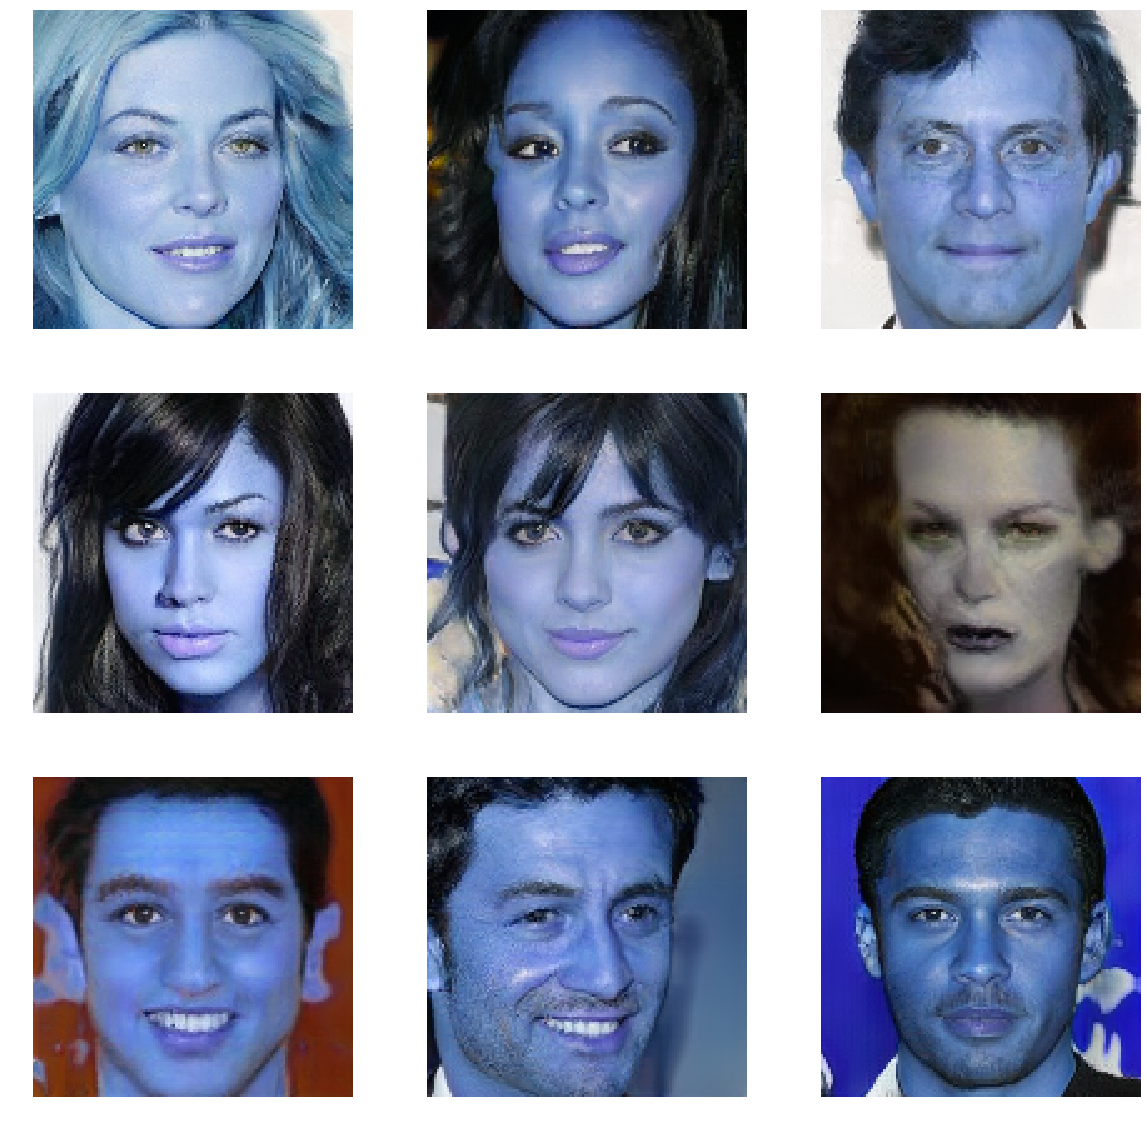

In [30]:
plotImages2(Progan_seed_0)

### ProGAN seed 1

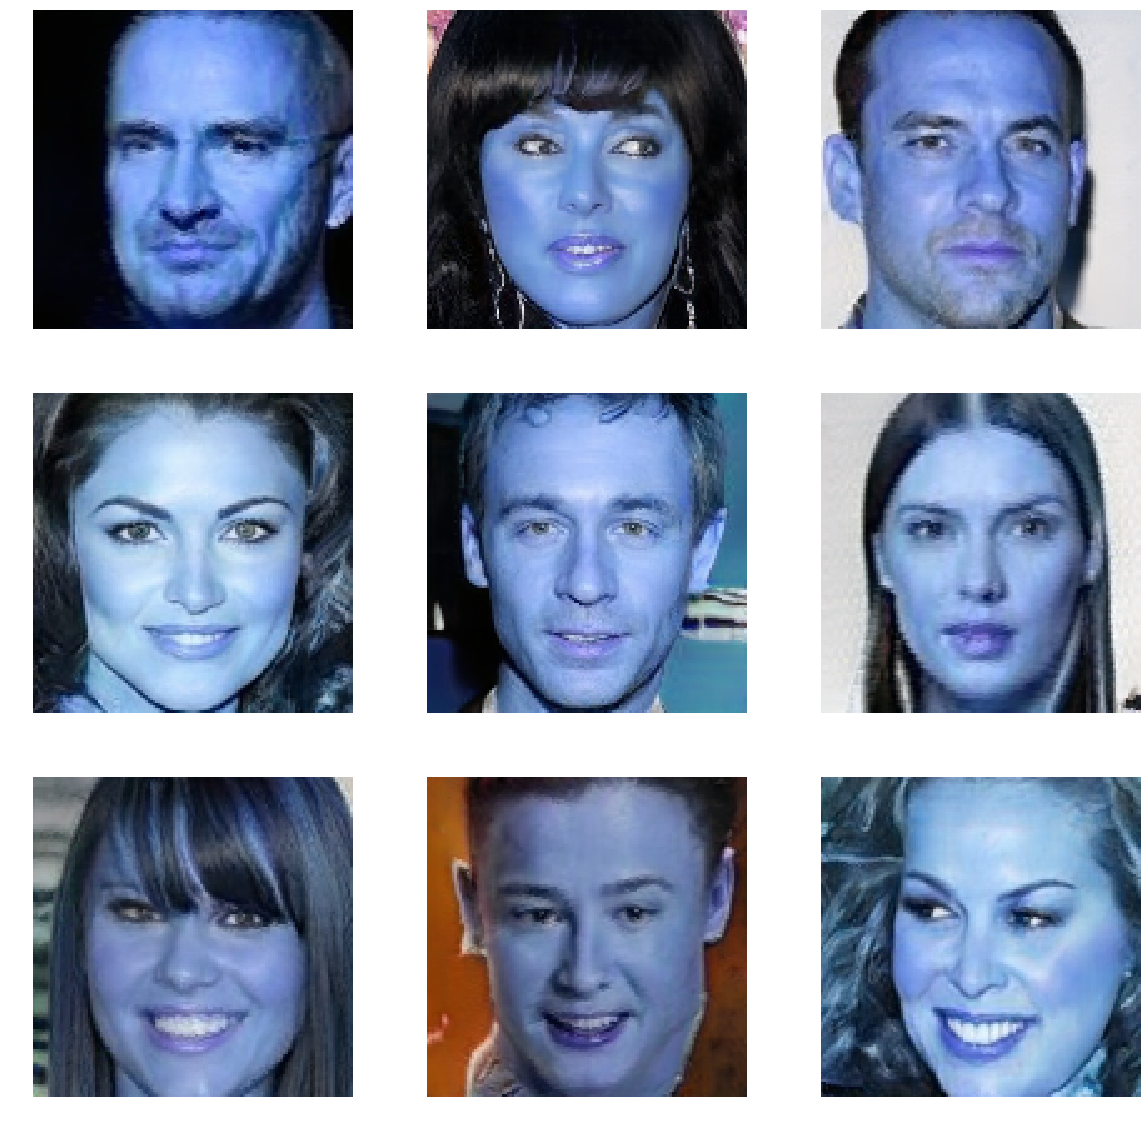

In [31]:
plotImages2(Progan_seed_1)

### ProGAN seed 2

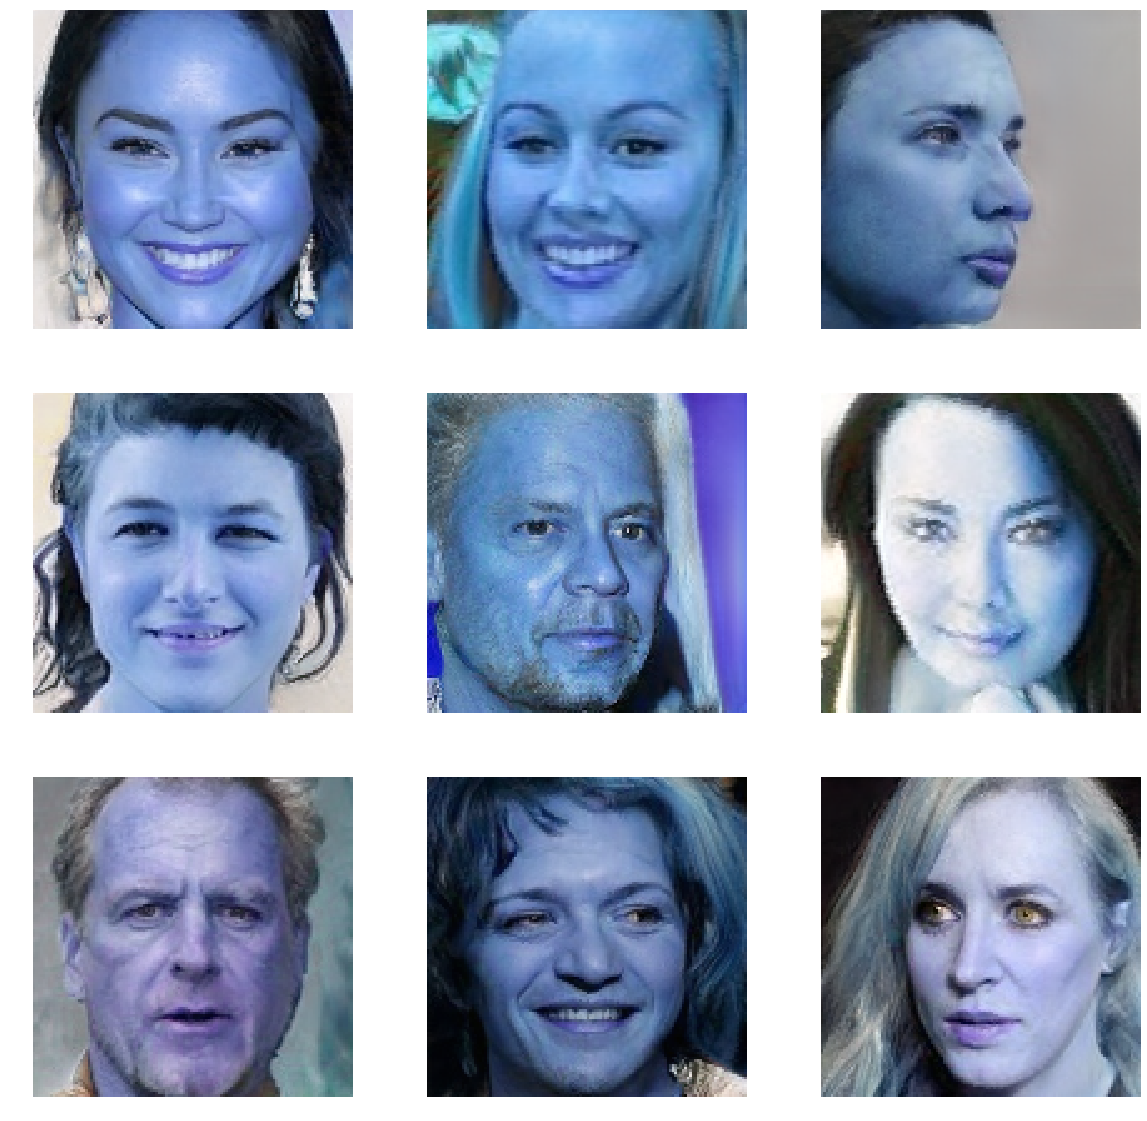

In [32]:
plotImages2(Progan_seed_2)

### ProGAN seed 3

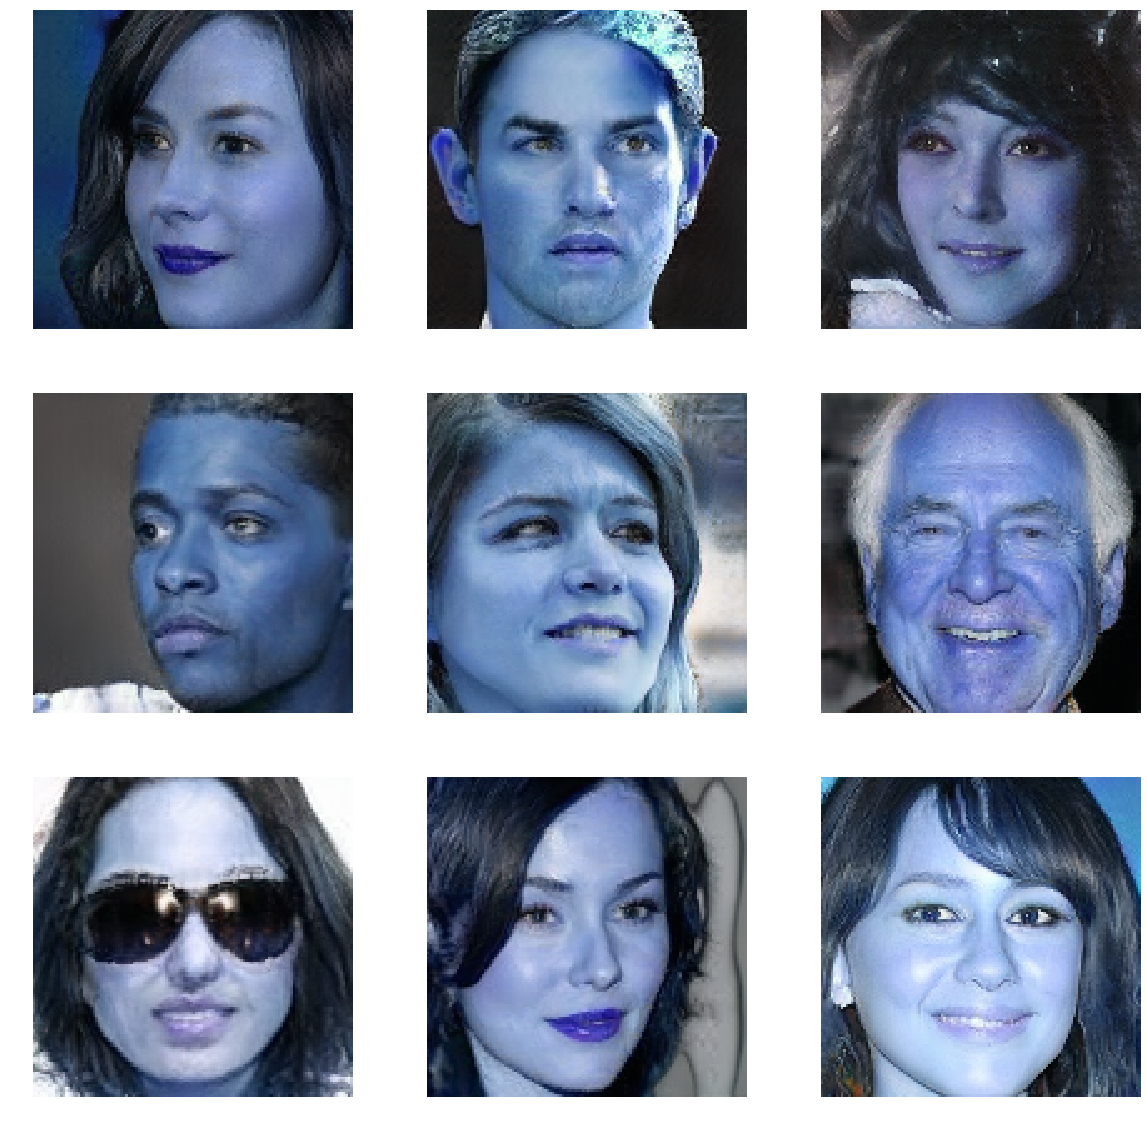

In [33]:
plotImages2(Progan_seed_3)

### ProGAN seed 4

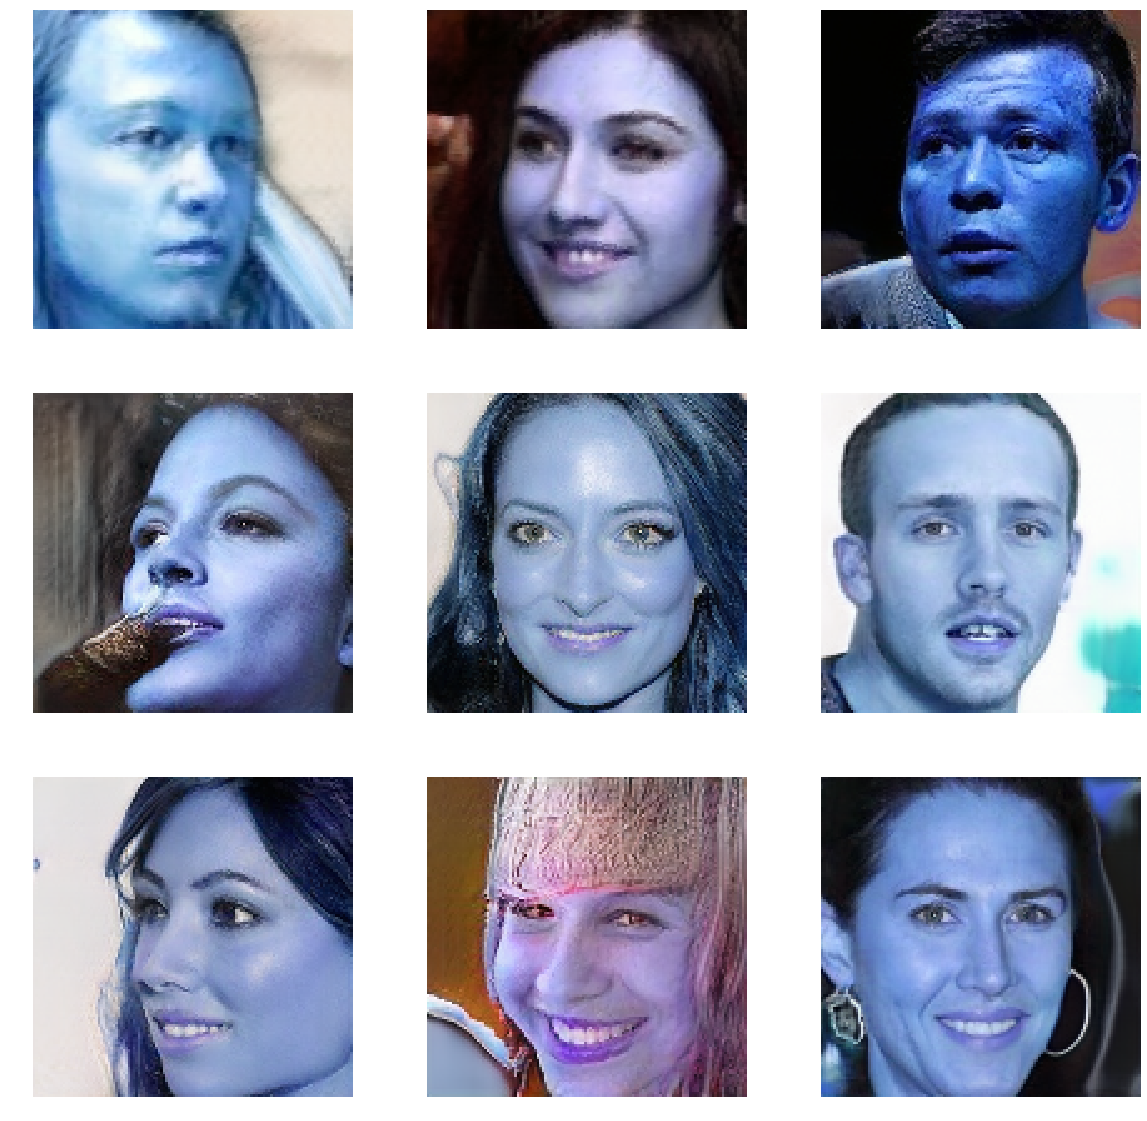

In [34]:
plotImages2(Progan_seed_4)

### ProGAN seed5

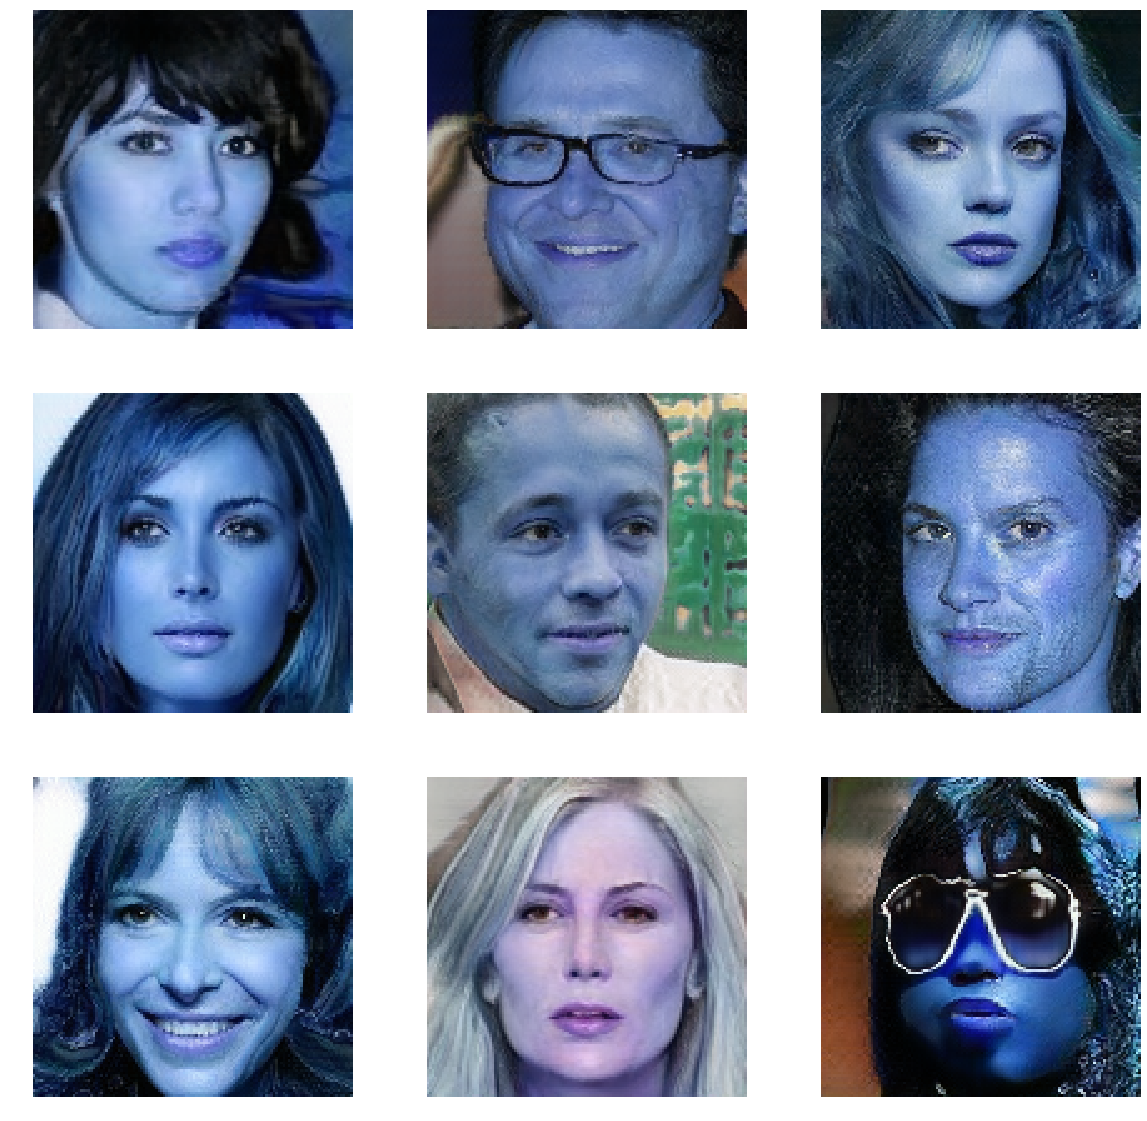

In [35]:
plotImages2(Progan_seed_5)

Similarly we get 10000 images generated from different ProGAN instances

# Classification 

#### Sampled 8 images each from original image and ProGAN seed images 

The total dataset for test is 88 images.Lets check the performance of the classifier

In [37]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [38]:
!python3 classifier/run.py \
--app test \
--model_path classifier/models/CelebA_ProGAN_seed_x10_128.pkl \
--testing_data_path GAN_classifier_datasets/test/

Initializing TensorFlow...




Loading network...
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Classifying 0/88 images: 01.png: predicted as being sampled from ProGAN_seed_0_generated_data 
Classifying 1/88 images: 02.png: predicted as being sampled from ProGAN_seed_0_generated_data 
Classifying 2/88 images: 03.png: predicted as being sampled from ProGAN_seed_0_generated_data 
Classifying 3/88 images: 04.png: predicted as being sampled from ProGAN_seed_0_generated_data 
Classifying 4/88 images: 05.png: predicted as being sampled from ProGAN_seed_0_generated_data 
Classifying 5/88 images: 06.png: predicted as being sampled from ProGAN_seed_0_generated_data 
Classifying 6/8

Classifying 82/88 images: 93.png: predicted as being sampled from ProGAN_seed_9_generated_data
Classifying 83/88 images: 94.png: predicted as being sampled from ProGAN_seed_9_generated_data
Classifying 84/88 images: 95.png: predicted as being sampled from ProGAN_seed_9_generated_data
Classifying 85/88 images: 96.png: predicted as being sampled from ProGAN_seed_9_generated_data
Classifying 86/88 images: 97.png: predicted as being sampled from ProGAN_seed_9_generated_data
Classifying 87/88 images: 98.png: predicted as being sampled from ProGAN_seed_9_generated_data
The percentage of images sampled from CelebA_real_data is 8/88 = 9.09%
The percentage of images sampled from ProGAN_seed_0_generated_data  is 8/88 = 9.09%
The percentage of images sampled from ProGAN_seed_1_generated_data is 8/88 = 9.09%
The percentage of images sampled from ProGAN_seed_2_generated_data is 8/88 = 9.09%
The percentage of images sampled from ProGAN_seed_3_generated_data is 8/88 = 9.09%
The percentage of images s

I labeled images starting with 0 as seed0 images,starting with 1 as seed1 images so on .<br><br>
Real images are labeled starting with 10 .<br><br>
The Overall Accuracy is 100% <br><br>

### Classifier visualization 

- Visualization of fingerprints for 3 test images (seed0 image and seed3 image and a original image)

In [39]:
!python3 classifier_visNet/run.py \
--app test \
--model_path classifier_visNet/models/CelebA_ProGAN_seed_x10_128.pkl \
--testing_data_path GAN_classifier_datasets/test/ \
--out_fingerprint_dir fingerprints/GAN_classifier_visNet/

Initializing TensorFlow...




Loading network...
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Classifying 0/3 images: 02.png: predicted as being sampled from ProGAN_seed_0_generated_data 
Classifying 1/3 images: 101.png: predicted as being sampled from CelebA_real_data
Classifying 2/3 images: 33.png: predicted as being sampled from ProGAN_seed_3_generated_data
The percentage of images sampled from CelebA_real_data is 1/3 = 33.33%
The percentage of images sampled from ProGAN_seed_0_generated_data  is 1/3 = 33.33%
The percentage of images sampled from ProGAN_seed_1_generated_data is 0/3 = 0.00%
The percentage of images sampled from ProGAN_seed_2_generated_data is 0/3 = 0.0

In [2]:
import cv2
from glob import glob
import matplotlib.pyplot as plt

In [1]:
# ganfingerprint_models =glob('fingerprints/GAN_classifier_visNet/**')

In [5]:
ganfingerprint_models =glob('fingerprints/GAN_classifier_visNet/model*?.png')

In [16]:
for i in ganfingerprint_models:
    print(i)

fingerprints/GAN_classifier_visNet/model_fingerprint_ProGAN_seed_8_generated_data.png
fingerprints/GAN_classifier_visNet/model_fingerprint_CelebA_real_data.png
fingerprints/GAN_classifier_visNet/model_fingerprint_ProGAN_seed_1_generated_data.png
fingerprints/GAN_classifier_visNet/model_fingerprint_ProGAN_seed_0_generated_data .png
fingerprints/GAN_classifier_visNet/model_fingerprint_ProGAN_seed_4_generated_data.png
fingerprints/GAN_classifier_visNet/model_fingerprint_ProGAN_seed_5_generated_data.png
fingerprints/GAN_classifier_visNet/model_fingerprint_ProGAN_seed_7_generated_data.png
fingerprints/GAN_classifier_visNet/model_fingerprint_ProGAN_seed_9_generated_data.png
fingerprints/GAN_classifier_visNet/model_fingerprint_ProGAN_seed_2_generated_data.png
fingerprints/GAN_classifier_visNet/model_fingerprint_ProGAN_seed_3_generated_data.png
fingerprints/GAN_classifier_visNet/model_fingerprint_ProGAN_seed_6_generated_data.png


In [21]:
from PIL import Image               # to load images
from IPython.display import display,Image # to display images

In [10]:
images = [cv2.imread(file) for file in ganfingerprint_models]

In [26]:
%matplotlib inline

In [29]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

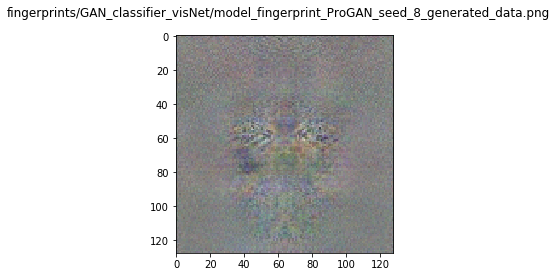

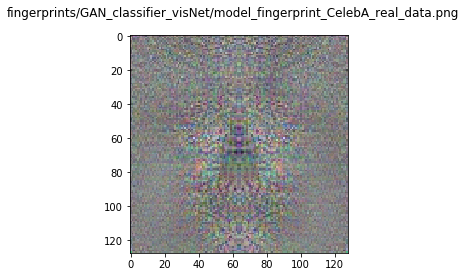

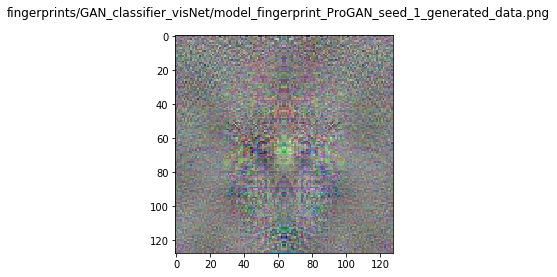

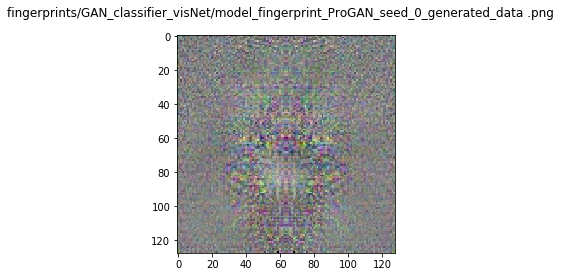

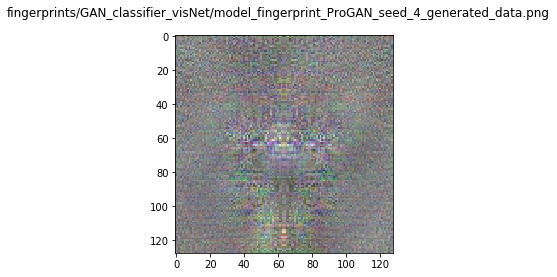

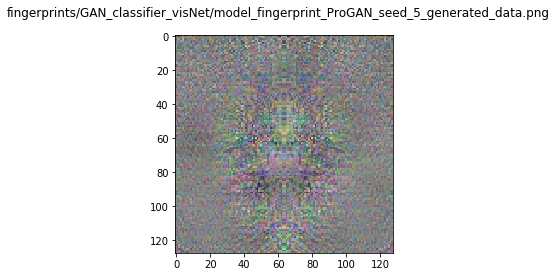

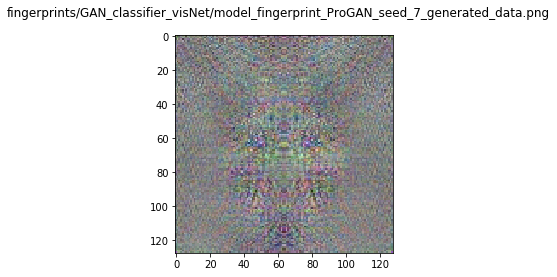

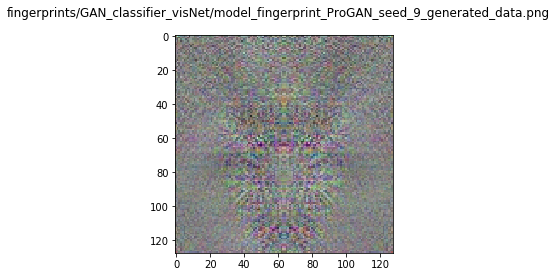

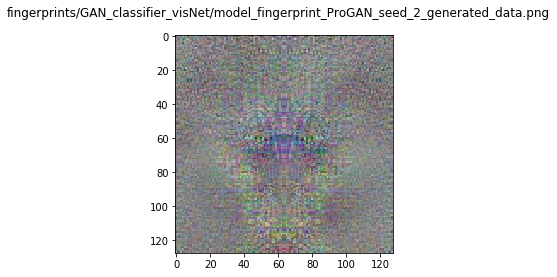

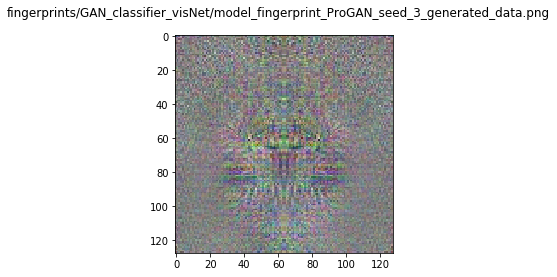

<Figure size 432x288 with 0 Axes>

In [33]:
for i,j in enumerate(images):
    plt.imshow(j)
    plt.figure(i+1)
    plt.suptitle(str(ganfingerprint_models[i]))

## Further approach

Our Future work is to train classifier with perturbed images and test with different images

In [40]:
!pwd

/home/ubuntu/GANFingerprints


### We generated images with different ProGAN instances from 0 to 9 but we are considering only 4 instances + 1 real for our classification problem

## Data preparation for classifier

In [46]:
!python3 classifier_visNet/data_preparation.py \
--in_dir ProGAN/gen/g_1/ \
--out_dir datasets/training/

Loading images from "ProGAN/gen/g_1/"
Creating dataset "datasets/training/"



Added 15000 images.                     


In [47]:
!python3 classifier_visNet/data_preparation.py \
--in_dir ProGAN/gen/g_1_v/ \
--out_dir datasets/validation/

Loading images from "ProGAN/gen/g_1_v/"
Creating dataset "datasets/validation/"



Added 1100 images.                      


In [ ]:
!python3 classifier/run.py \
--app train \
--training_data_dir datasets/training/ \
--validation_data_dir datasets/validation/ \
--out_model_dir models/gaussian_classifier/ \
--training_seed 0

Initializing TensorFlow...




Streaming data using dataset.TFRecordDataset...


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [3, 128, 128]
Dynamic range = [0, 255]
Label size    = 5
Streaming data using dataset.TFRecordDataset...
Dataset shape = [3, 128, 128]
Dynamic range = [0, 255]
Label size    = 5
Constructing networks...


C_im                        Params      OutputShape             WeightShape             
---                         ---

tick 2     kimg 2.0      lod 0.00  resolution 128  minibatch 32   time 11s          sec/tick 3.9     sec/kimg 3.77    maintenance 1.0
tick 3     kimg 3.1      lod 0.00  resolution 128  minibatch 32   time 15s          sec/tick 3.8     sec/kimg 3.75    maintenance 0.0
tick 4     kimg 4.1      lod 0.00  resolution 128  minibatch 32   time 19s          sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
tick 5     kimg 5.1      lod 0.00  resolution 128  minibatch 32   time 23s          sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6     kimg 6.1      lod 0.00  resolution 128  minibatch 32   time 27s          sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 7     kimg 7.2      lod 0.00  resolution 128  minibatch 32   time 31s          sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 8     kimg 8.2      lod 0.00  resolution 128  minibatch 32   time 34s          sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 9     kimg 9.2      lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.419200
Validation Accuracy = 0.209800
tick 61    kimg 62.5     lod 0.00  resolution 128  minibatch 32   time 5m 03s       sec/tick 3.9     sec/kimg 3.78    maintenance 10.6
tick 62    kimg 63.5     lod 0.00  resolution 128  minibatch 32   time 5m 07s       sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 63    kimg 64.5     lod 0.00  resolution 128  minibatch 32   time 5m 11s       sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 64    kimg 65.5     lod 0.00  resolution 128  minibatch 32   time 5m 14s       sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 65    kimg 66.6     lod 0.00  resolution 128  minibatch 32   time 5m 18s       sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
tick 66    kimg 67.6     lod 0.00  resolution 128  minibatch 32   time 5m 22s       sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 67    kimg 68.6     lod 0.00  resolution 128  minibatch 32   time 5m 26s       sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 120   kimg 122.9    lod 0.00  resolution 128  minibatch 32   time 9m 45s       sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.425000
Validation Accuracy = 0.232600
tick 121   kimg 123.9    lod 0.00  resolution 128  minibatch 32   time 9m 59s       sec/tick 3.9     sec/kimg 3.78    maintenance 10.7
tick 122   kimg 124.9    lod 0.00  resolution 128  minibatch 32   time 10m 03s      sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 123   kimg 126.0    lod 0.00  resolution 128  minibatch 32   time 10m 07s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 124   kimg 127.0    lod 0.00  resolution 128  minibatch 32   time 10m 11s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 125   kimg 128.0    lod 0.00  resolution 128  minibatch 32   time 10m 15s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 126   kimg 129.0    lod 0.00  resolution 128  minibatch 32   time 10m 19s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 179   kimg 183.3    lod 0.00  resolution 128  minibatch 32   time 14m 37s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 180   kimg 184.3    lod 0.00  resolution 128  minibatch 32   time 14m 41s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.465800
Validation Accuracy = 0.272000
tick 181   kimg 185.3    lod 0.00  resolution 128  minibatch 32   time 14m 56s      sec/tick 3.9     sec/kimg 3.78    maintenance 10.7
tick 182   kimg 186.4    lod 0.00  resolution 128  minibatch 32   time 14m 59s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 183   kimg 187.4    lod 0.00  resolution 128  minibatch 32   time 15m 03s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 184   kimg 188.4    lod 0.00  resolution 128  minibatch 32   time 15m 07s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 185   kimg 189.4    lod 0.00  resolution 128  minibatch 32   time 15m 11s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 238   kimg 243.7    lod 0.00  resolution 128  minibatch 32   time 19m 30s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 239   kimg 244.7    lod 0.00  resolution 128  minibatch 32   time 19m 34s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 240   kimg 245.8    lod 0.00  resolution 128  minibatch 32   time 19m 38s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.511400
Validation Accuracy = 0.330400
tick 241   kimg 246.8    lod 0.00  resolution 128  minibatch 32   time 19m 53s      sec/tick 3.9     sec/kimg 3.78    maintenance 10.7
tick 242   kimg 247.8    lod 0.00  resolution 128  minibatch 32   time 19m 56s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 243   kimg 248.8    lod 0.00  resolution 128  minibatch 32   time 20m 00s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 244   kimg 249.9    lod 0.00  resolution 128  minibatch 32   time 20m 04s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 297   kimg 304.1    lod 0.00  resolution 128  minibatch 32   time 24m 23s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 298   kimg 305.2    lod 0.00  resolution 128  minibatch 32   time 24m 27s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 299   kimg 306.2    lod 0.00  resolution 128  minibatch 32   time 24m 31s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 300   kimg 307.2    lod 0.00  resolution 128  minibatch 32   time 24m 34s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.586600
Validation Accuracy = 0.387000
tick 301   kimg 308.2    lod 0.00  resolution 128  minibatch 32   time 24m 49s      sec/tick 3.9     sec/kimg 3.78    maintenance 10.7
tick 302   kimg 309.2    lod 0.00  resolution 128  minibatch 32   time 24m 53s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 303   kimg 310.3    lod 0.00  resolution 128  minibatch 32   time 24m 57s      sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 356   kimg 364.5    lod 0.00  resolution 128  minibatch 32   time 29m 16s      sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 357   kimg 365.6    lod 0.00  resolution 128  minibatch 32   time 29m 19s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 358   kimg 366.6    lod 0.00  resolution 128  minibatch 32   time 29m 23s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 359   kimg 367.6    lod 0.00  resolution 128  minibatch 32   time 29m 27s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 360   kimg 368.6    lod 0.00  resolution 128  minibatch 32   time 29m 31s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.679600
Validation Accuracy = 0.505400
tick 361   kimg 369.7    lod 0.00  resolution 128  minibatch 32   time 29m 46s      sec/tick 3.9     sec/kimg 3.79    maintenance 10.6
tick 362   kimg 370.7    lod 0.00  resolution 128  minibatch 32   time 29m 49s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 415   kimg 425.0    lod 0.00  resolution 128  minibatch 32   time 34m 08s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 416   kimg 426.0    lod 0.00  resolution 128  minibatch 32   time 34m 12s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 417   kimg 427.0    lod 0.00  resolution 128  minibatch 32   time 34m 16s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 418   kimg 428.0    lod 0.00  resolution 128  minibatch 32   time 34m 20s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 419   kimg 429.1    lod 0.00  resolution 128  minibatch 32   time 34m 24s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 420   kimg 430.1    lod 0.00  resolution 128  minibatch 32   time 34m 28s      sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
Training Accuracy = 0.750600
Validation Accuracy = 0.569600
tick 421   kimg 431.1    lod 0.00  resolution 128  minibatch 32   time 34m 42s      sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
t

tick 474   kimg 485.4    lod 0.00  resolution 128  minibatch 32   time 39m 01s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 475   kimg 486.4    lod 0.00  resolution 128  minibatch 32   time 39m 05s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 476   kimg 487.4    lod 0.00  resolution 128  minibatch 32   time 39m 09s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 477   kimg 488.4    lod 0.00  resolution 128  minibatch 32   time 39m 12s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 478   kimg 489.5    lod 0.00  resolution 128  minibatch 32   time 39m 16s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 479   kimg 490.5    lod 0.00  resolution 128  minibatch 32   time 39m 20s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 480   kimg 491.5    lod 0.00  resolution 128  minibatch 32   time 39m 24s      sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
Training Accuracy = 0.818400
Validation Accuracy = 0.649200
ti

tick 533   kimg 545.8    lod 0.00  resolution 128  minibatch 32   time 43m 53s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 534   kimg 546.8    lod 0.00  resolution 128  minibatch 32   time 43m 57s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 535   kimg 547.8    lod 0.00  resolution 128  minibatch 32   time 44m 01s      sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 536   kimg 548.9    lod 0.00  resolution 128  minibatch 32   time 44m 05s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 537   kimg 549.9    lod 0.00  resolution 128  minibatch 32   time 44m 08s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 538   kimg 550.9    lod 0.00  resolution 128  minibatch 32   time 44m 12s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 539   kimg 551.9    lod 0.00  resolution 128  minibatch 32   time 44m 16s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 540   kimg 553.0    lod 0.00  resolution 128  minibatch 3

tick 592   kimg 606.2    lod 0.00  resolution 128  minibatch 32   time 48m 45s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 593   kimg 607.2    lod 0.00  resolution 128  minibatch 32   time 48m 49s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 594   kimg 608.3    lod 0.00  resolution 128  minibatch 32   time 48m 53s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 595   kimg 609.3    lod 0.00  resolution 128  minibatch 32   time 48m 57s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 596   kimg 610.3    lod 0.00  resolution 128  minibatch 32   time 49m 01s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 597   kimg 611.3    lod 0.00  resolution 128  minibatch 32   time 49m 05s      sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 598   kimg 612.4    lod 0.00  resolution 128  minibatch 32   time 49m 09s      sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 599   kimg 613.4    lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.942600
Validation Accuracy = 0.743600
tick 651   kimg 666.6    lod 0.00  resolution 128  minibatch 32   time 53m 38s      sec/tick 3.9     sec/kimg 3.78    maintenance 10.6
tick 652   kimg 667.6    lod 0.00  resolution 128  minibatch 32   time 53m 42s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 653   kimg 668.7    lod 0.00  resolution 128  minibatch 32   time 53m 46s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 654   kimg 669.7    lod 0.00  resolution 128  minibatch 32   time 53m 50s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 655   kimg 670.7    lod 0.00  resolution 128  minibatch 32   time 53m 53s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 656   kimg 671.7    lod 0.00  resolution 128  minibatch 32   time 53m 57s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 657   kimg 672.8    lod 0.00  resolution 128  minibatch 32   time 54m 01s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 710   kimg 727.0    lod 0.00  resolution 128  minibatch 32   time 58m 20s      sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.933000
Validation Accuracy = 0.737000
tick 711   kimg 728.1    lod 0.00  resolution 128  minibatch 32   time 58m 34s      sec/tick 3.9     sec/kimg 3.78    maintenance 10.5
tick 712   kimg 729.1    lod 0.00  resolution 128  minibatch 32   time 58m 38s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 713   kimg 730.1    lod 0.00  resolution 128  minibatch 32   time 58m 42s      sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 714   kimg 731.1    lod 0.00  resolution 128  minibatch 32   time 58m 46s      sec/tick 3.8     sec/kimg 3.76    maintenance 0.0
tick 715   kimg 732.2    lod 0.00  resolution 128  minibatch 32   time 58m 50s      sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 716   kimg 733.2    lod 0.00  resolution 128  minibatch 32   time 58m 54s      sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 769   kimg 787.5    lod 0.00  resolution 128  minibatch 32   time 1h 03m 12s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 770   kimg 788.5    lod 0.00  resolution 128  minibatch 32   time 1h 03m 16s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.951600
Validation Accuracy = 0.753600
tick 771   kimg 789.5    lod 0.00  resolution 128  minibatch 32   time 1h 03m 31s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.6
tick 772   kimg 790.5    lod 0.00  resolution 128  minibatch 32   time 1h 03m 34s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 773   kimg 791.6    lod 0.00  resolution 128  minibatch 32   time 1h 03m 38s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 774   kimg 792.6    lod 0.00  resolution 128  minibatch 32   time 1h 03m 42s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 775   kimg 793.6    lod 0.00  resolution 128  minibatch 32   time 1h 03m 46s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 828   kimg 847.9    lod 0.00  resolution 128  minibatch 32   time 1h 08m 05s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 829   kimg 848.9    lod 0.00  resolution 128  minibatch 32   time 1h 08m 09s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 830   kimg 849.9    lod 0.00  resolution 128  minibatch 32   time 1h 08m 13s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.971400
Validation Accuracy = 0.770000
tick 831   kimg 850.9    lod 0.00  resolution 128  minibatch 32   time 1h 08m 27s   sec/tick 3.9     sec/kimg 3.77    maintenance 10.5
tick 832   kimg 852.0    lod 0.00  resolution 128  minibatch 32   time 1h 08m 31s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 833   kimg 853.0    lod 0.00  resolution 128  minibatch 32   time 1h 08m 35s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 834   kimg 854.0    lod 0.00  resolution 128  minibatch 32   time 1h 08m 39s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 887   kimg 908.3    lod 0.00  resolution 128  minibatch 32   time 1h 12m 58s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 888   kimg 909.3    lod 0.00  resolution 128  minibatch 32   time 1h 13m 02s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 889   kimg 910.3    lod 0.00  resolution 128  minibatch 32   time 1h 13m 05s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 890   kimg 911.4    lod 0.00  resolution 128  minibatch 32   time 1h 13m 09s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.966000
Validation Accuracy = 0.765800
tick 891   kimg 912.4    lod 0.00  resolution 128  minibatch 32   time 1h 13m 24s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.5
tick 892   kimg 913.4    lod 0.00  resolution 128  minibatch 32   time 1h 13m 28s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 893   kimg 914.4    lod 0.00  resolution 128  minibatch 32   time 1h 13m 32s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 946   kimg 968.7    lod 0.00  resolution 128  minibatch 32   time 1h 17m 50s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 947   kimg 969.7    lod 0.00  resolution 128  minibatch 32   time 1h 17m 54s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 948   kimg 970.8    lod 0.00  resolution 128  minibatch 32   time 1h 17m 58s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 949   kimg 971.8    lod 0.00  resolution 128  minibatch 32   time 1h 18m 02s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 950   kimg 972.8    lod 0.00  resolution 128  minibatch 32   time 1h 18m 06s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
Training Accuracy = 0.948400
Validation Accuracy = 0.757600
tick 951   kimg 973.8    lod 0.00  resolution 128  minibatch 32   time 1h 18m 20s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.6
tick 952   kimg 974.8    lod 0.00  resolution 128  minibatch 32   time 1h 18m 24s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 1005  kimg 1029.1   lod 0.00  resolution 128  minibatch 32   time 1h 22m 43s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1006  kimg 1030.1   lod 0.00  resolution 128  minibatch 32   time 1h 22m 47s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1007  kimg 1031.2   lod 0.00  resolution 128  minibatch 32   time 1h 22m 51s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1008  kimg 1032.2   lod 0.00  resolution 128  minibatch 32   time 1h 22m 55s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1009  kimg 1033.2   lod 0.00  resolution 128  minibatch 32   time 1h 22m 59s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1010  kimg 1034.2   lod 0.00  resolution 128  minibatch 32   time 1h 23m 03s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.977600
Validation Accuracy = 0.775600
tick 1011  kimg 1035.3   lod 0.00  resolution 128  minibatch 32   time 1h 23m 17s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.5
t

tick 1064  kimg 1089.5   lod 0.00  resolution 128  minibatch 32   time 1h 27m 36s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1065  kimg 1090.6   lod 0.00  resolution 128  minibatch 32   time 1h 27m 40s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1066  kimg 1091.6   lod 0.00  resolution 128  minibatch 32   time 1h 27m 44s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1067  kimg 1092.6   lod 0.00  resolution 128  minibatch 32   time 1h 27m 47s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1068  kimg 1093.6   lod 0.00  resolution 128  minibatch 32   time 1h 27m 51s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 1069  kimg 1094.7   lod 0.00  resolution 128  minibatch 32   time 1h 27m 55s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1070  kimg 1095.7   lod 0.00  resolution 128  minibatch 32   time 1h 27m 59s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.973600
Validation Accuracy = 0.776400
ti

tick 1123  kimg 1150.0   lod 0.00  resolution 128  minibatch 32   time 1h 32m 28s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1124  kimg 1151.0   lod 0.00  resolution 128  minibatch 32   time 1h 32m 32s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1125  kimg 1152.0   lod 0.00  resolution 128  minibatch 32   time 1h 32m 36s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1126  kimg 1153.0   lod 0.00  resolution 128  minibatch 32   time 1h 32m 40s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1127  kimg 1154.0   lod 0.00  resolution 128  minibatch 32   time 1h 32m 44s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1128  kimg 1155.1   lod 0.00  resolution 128  minibatch 32   time 1h 32m 48s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1129  kimg 1156.1   lod 0.00  resolution 128  minibatch 32   time 1h 32m 52s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1130  kimg 1157.1   lod 0.00  resolution 128  minibatch 3

tick 1182  kimg 1210.4   lod 0.00  resolution 128  minibatch 32   time 1h 37m 21s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1183  kimg 1211.4   lod 0.00  resolution 128  minibatch 32   time 1h 37m 25s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1184  kimg 1212.4   lod 0.00  resolution 128  minibatch 32   time 1h 37m 29s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 1185  kimg 1213.4   lod 0.00  resolution 128  minibatch 32   time 1h 37m 32s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1186  kimg 1214.5   lod 0.00  resolution 128  minibatch 32   time 1h 37m 36s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1187  kimg 1215.5   lod 0.00  resolution 128  minibatch 32   time 1h 37m 40s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 1188  kimg 1216.5   lod 0.00  resolution 128  minibatch 32   time 1h 37m 44s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1189  kimg 1217.5   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.982200
Validation Accuracy = 0.788400
tick 1241  kimg 1270.8   lod 0.00  resolution 128  minibatch 32   time 1h 42m 13s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.6
tick 1242  kimg 1271.8   lod 0.00  resolution 128  minibatch 32   time 1h 42m 17s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1243  kimg 1272.8   lod 0.00  resolution 128  minibatch 32   time 1h 42m 21s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 1244  kimg 1273.9   lod 0.00  resolution 128  minibatch 32   time 1h 42m 25s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1245  kimg 1274.9   lod 0.00  resolution 128  minibatch 32   time 1h 42m 29s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1246  kimg 1275.9   lod 0.00  resolution 128  minibatch 32   time 1h 42m 33s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1247  kimg 1276.9   lod 0.00  resolution 128  minibatch 32   time 1h 42m 37s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
t

tick 1300  kimg 1331.2   lod 0.00  resolution 128  minibatch 32   time 1h 46m 55s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.969400
Validation Accuracy = 0.769600
tick 1301  kimg 1332.2   lod 0.00  resolution 128  minibatch 32   time 1h 47m 10s   sec/tick 3.9     sec/kimg 3.77    maintenance 10.5
tick 1302  kimg 1333.2   lod 0.00  resolution 128  minibatch 32   time 1h 47m 13s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1303  kimg 1334.3   lod 0.00  resolution 128  minibatch 32   time 1h 47m 17s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1304  kimg 1335.3   lod 0.00  resolution 128  minibatch 32   time 1h 47m 21s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1305  kimg 1336.3   lod 0.00  resolution 128  minibatch 32   time 1h 47m 25s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1306  kimg 1337.3   lod 0.00  resolution 128  minibatch 32   time 1h 47m 29s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 1359  kimg 1391.6   lod 0.00  resolution 128  minibatch 32   time 1h 51m 48s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1360  kimg 1392.6   lod 0.00  resolution 128  minibatch 32   time 1h 51m 51s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.982800
Validation Accuracy = 0.786800
tick 1361  kimg 1393.7   lod 0.00  resolution 128  minibatch 32   time 1h 52m 06s   sec/tick 3.9     sec/kimg 3.77    maintenance 10.7
tick 1362  kimg 1394.7   lod 0.00  resolution 128  minibatch 32   time 1h 52m 10s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1363  kimg 1395.7   lod 0.00  resolution 128  minibatch 32   time 1h 52m 14s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1364  kimg 1396.7   lod 0.00  resolution 128  minibatch 32   time 1h 52m 18s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1365  kimg 1397.8   lod 0.00  resolution 128  minibatch 32   time 1h 52m 22s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 1418  kimg 1452.0   lod 0.00  resolution 128  minibatch 32   time 1h 56m 40s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1419  kimg 1453.1   lod 0.00  resolution 128  minibatch 32   time 1h 56m 44s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1420  kimg 1454.1   lod 0.00  resolution 128  minibatch 32   time 1h 56m 48s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.971200
Validation Accuracy = 0.779600
tick 1421  kimg 1455.1   lod 0.00  resolution 128  minibatch 32   time 1h 57m 02s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 1422  kimg 1456.1   lod 0.00  resolution 128  minibatch 32   time 1h 57m 06s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1423  kimg 1457.2   lod 0.00  resolution 128  minibatch 32   time 1h 57m 10s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1424  kimg 1458.2   lod 0.00  resolution 128  minibatch 32   time 1h 57m 14s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
t

tick 1477  kimg 1512.4   lod 0.00  resolution 128  minibatch 32   time 2h 01m 33s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1478  kimg 1513.5   lod 0.00  resolution 128  minibatch 32   time 2h 01m 36s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1479  kimg 1514.5   lod 0.00  resolution 128  minibatch 32   time 2h 01m 40s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 1480  kimg 1515.5   lod 0.00  resolution 128  minibatch 32   time 2h 01m 44s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
Training Accuracy = 0.986600
Validation Accuracy = 0.787800
tick 1481  kimg 1516.5   lod 0.00  resolution 128  minibatch 32   time 2h 01m 59s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.5
tick 1482  kimg 1517.6   lod 0.00  resolution 128  minibatch 32   time 2h 02m 02s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1483  kimg 1518.6   lod 0.00  resolution 128  minibatch 32   time 2h 02m 06s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
t

tick 1536  kimg 1572.9   lod 0.00  resolution 128  minibatch 32   time 2h 06m 25s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 1537  kimg 1573.9   lod 0.00  resolution 128  minibatch 32   time 2h 06m 29s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1538  kimg 1574.9   lod 0.00  resolution 128  minibatch 32   time 2h 06m 33s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1539  kimg 1575.9   lod 0.00  resolution 128  minibatch 32   time 2h 06m 37s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 1540  kimg 1577.0   lod 0.00  resolution 128  minibatch 32   time 2h 06m 41s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.987000
Validation Accuracy = 0.787200
tick 1541  kimg 1578.0   lod 0.00  resolution 128  minibatch 32   time 2h 06m 55s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.6
tick 1542  kimg 1579.0   lod 0.00  resolution 128  minibatch 32   time 2h 06m 59s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 1595  kimg 1633.3   lod 0.00  resolution 128  minibatch 32   time 2h 11m 18s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1596  kimg 1634.3   lod 0.00  resolution 128  minibatch 32   time 2h 11m 22s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1597  kimg 1635.3   lod 0.00  resolution 128  minibatch 32   time 2h 11m 25s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1598  kimg 1636.4   lod 0.00  resolution 128  minibatch 32   time 2h 11m 29s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1599  kimg 1637.4   lod 0.00  resolution 128  minibatch 32   time 2h 11m 33s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1600  kimg 1638.4   lod 0.00  resolution 128  minibatch 32   time 2h 11m 37s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
Training Accuracy = 0.978000
Validation Accuracy = 0.770600
tick 1601  kimg 1639.4   lod 0.00  resolution 128  minibatch 32   time 2h 11m 52s   sec/tick 3.9     sec/kimg 3.77    maintenance 10.7
t

tick 1654  kimg 1693.7   lod 0.00  resolution 128  minibatch 32   time 2h 16m 10s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1655  kimg 1694.7   lod 0.00  resolution 128  minibatch 32   time 2h 16m 14s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1656  kimg 1695.7   lod 0.00  resolution 128  minibatch 32   time 2h 16m 18s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1657  kimg 1696.8   lod 0.00  resolution 128  minibatch 32   time 2h 16m 22s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1658  kimg 1697.8   lod 0.00  resolution 128  minibatch 32   time 2h 16m 26s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1659  kimg 1698.8   lod 0.00  resolution 128  minibatch 32   time 2h 16m 30s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1660  kimg 1699.8   lod 0.00  resolution 128  minibatch 32   time 2h 16m 34s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.990800
Validation Accuracy = 0.787600
ti

tick 1713  kimg 1754.1   lod 0.00  resolution 128  minibatch 32   time 2h 21m 03s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1714  kimg 1755.1   lod 0.00  resolution 128  minibatch 32   time 2h 21m 07s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 1715  kimg 1756.2   lod 0.00  resolution 128  minibatch 32   time 2h 21m 10s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
tick 1716  kimg 1757.2   lod 0.00  resolution 128  minibatch 32   time 2h 21m 14s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1717  kimg 1758.2   lod 0.00  resolution 128  minibatch 32   time 2h 21m 18s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1718  kimg 1759.2   lod 0.00  resolution 128  minibatch 32   time 2h 21m 22s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1719  kimg 1760.3   lod 0.00  resolution 128  minibatch 32   time 2h 21m 26s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1720  kimg 1761.3   lod 0.00  resolution 128  minibatch 3

tick 1772  kimg 1814.5   lod 0.00  resolution 128  minibatch 32   time 2h 25m 55s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 1773  kimg 1815.6   lod 0.00  resolution 128  minibatch 32   time 2h 25m 59s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 1774  kimg 1816.6   lod 0.00  resolution 128  minibatch 32   time 2h 26m 03s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1775  kimg 1817.6   lod 0.00  resolution 128  minibatch 32   time 2h 26m 07s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1776  kimg 1818.6   lod 0.00  resolution 128  minibatch 32   time 2h 26m 10s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1777  kimg 1819.6   lod 0.00  resolution 128  minibatch 32   time 2h 26m 14s   sec/tick 3.8     sec/kimg 3.76    maintenance 0.0
tick 1778  kimg 1820.7   lod 0.00  resolution 128  minibatch 32   time 2h 26m 18s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 1779  kimg 1821.7   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.987000
Validation Accuracy = 0.786400
tick 1831  kimg 1874.9   lod 0.00  resolution 128  minibatch 32   time 2h 30m 47s   sec/tick 3.9     sec/kimg 3.77    maintenance 10.6
tick 1832  kimg 1876.0   lod 0.00  resolution 128  minibatch 32   time 2h 30m 51s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1833  kimg 1877.0   lod 0.00  resolution 128  minibatch 32   time 2h 30m 55s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1834  kimg 1878.0   lod 0.00  resolution 128  minibatch 32   time 2h 30m 59s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1835  kimg 1879.0   lod 0.00  resolution 128  minibatch 32   time 2h 31m 03s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1836  kimg 1880.1   lod 0.00  resolution 128  minibatch 32   time 2h 31m 07s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1837  kimg 1881.1   lod 0.00  resolution 128  minibatch 32   time 2h 31m 11s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 1890  kimg 1935.4   lod 0.00  resolution 128  minibatch 32   time 2h 35m 29s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
Training Accuracy = 0.992600
Validation Accuracy = 0.794400
tick 1891  kimg 1936.4   lod 0.00  resolution 128  minibatch 32   time 2h 35m 44s   sec/tick 3.9     sec/kimg 3.77    maintenance 10.5
tick 1892  kimg 1937.4   lod 0.00  resolution 128  minibatch 32   time 2h 35m 48s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1893  kimg 1938.4   lod 0.00  resolution 128  minibatch 32   time 2h 35m 52s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 1894  kimg 1939.5   lod 0.00  resolution 128  minibatch 32   time 2h 35m 55s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1895  kimg 1940.5   lod 0.00  resolution 128  minibatch 32   time 2h 35m 59s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1896  kimg 1941.5   lod 0.00  resolution 128  minibatch 32   time 2h 36m 03s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 1949  kimg 1995.8   lod 0.00  resolution 128  minibatch 32   time 2h 40m 22s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1950  kimg 1996.8   lod 0.00  resolution 128  minibatch 32   time 2h 40m 26s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
Training Accuracy = 0.985200
Validation Accuracy = 0.784200
tick 1951  kimg 1997.8   lod 0.00  resolution 128  minibatch 32   time 2h 40m 41s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.6
tick 1952  kimg 1998.8   lod 0.00  resolution 128  minibatch 32   time 2h 40m 45s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 1953  kimg 1999.9   lod 0.00  resolution 128  minibatch 32   time 2h 40m 48s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1954  kimg 2000.9   lod 0.00  resolution 128  minibatch 32   time 2h 40m 52s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1955  kimg 2001.9   lod 0.00  resolution 128  minibatch 32   time 2h 40m 56s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 2008  kimg 2056.2   lod 0.00  resolution 128  minibatch 32   time 2h 45m 15s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 2009  kimg 2057.2   lod 0.00  resolution 128  minibatch 32   time 2h 45m 19s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2010  kimg 2058.2   lod 0.00  resolution 128  minibatch 32   time 2h 45m 23s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
Training Accuracy = 0.971600
Validation Accuracy = 0.781000
tick 2011  kimg 2059.3   lod 0.00  resolution 128  minibatch 32   time 2h 45m 37s   sec/tick 3.9     sec/kimg 3.76    maintenance 10.6
tick 2012  kimg 2060.3   lod 0.00  resolution 128  minibatch 32   time 2h 45m 41s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
tick 2013  kimg 2061.3   lod 0.00  resolution 128  minibatch 32   time 2h 45m 45s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 2014  kimg 2062.3   lod 0.00  resolution 128  minibatch 32   time 2h 45m 49s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 2067  kimg 2116.6   lod 0.00  resolution 128  minibatch 32   time 2h 50m 07s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2068  kimg 2117.6   lod 0.00  resolution 128  minibatch 32   time 2h 50m 11s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2069  kimg 2118.7   lod 0.00  resolution 128  minibatch 32   time 2h 50m 15s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2070  kimg 2119.7   lod 0.00  resolution 128  minibatch 32   time 2h 50m 19s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.992200
Validation Accuracy = 0.793000
tick 2071  kimg 2120.7   lod 0.00  resolution 128  minibatch 32   time 2h 50m 33s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.6
tick 2072  kimg 2121.7   lod 0.00  resolution 128  minibatch 32   time 2h 50m 37s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2073  kimg 2122.8   lod 0.00  resolution 128  minibatch 32   time 2h 50m 41s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 2126  kimg 2177.0   lod 0.00  resolution 128  minibatch 32   time 2h 55m 00s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2127  kimg 2178.0   lod 0.00  resolution 128  minibatch 32   time 2h 55m 04s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2128  kimg 2179.1   lod 0.00  resolution 128  minibatch 32   time 2h 55m 07s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2129  kimg 2180.1   lod 0.00  resolution 128  minibatch 32   time 2h 55m 11s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2130  kimg 2181.1   lod 0.00  resolution 128  minibatch 32   time 2h 55m 15s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.985800
Validation Accuracy = 0.784600
tick 2131  kimg 2182.1   lod 0.00  resolution 128  minibatch 32   time 2h 55m 30s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.6
tick 2132  kimg 2183.2   lod 0.00  resolution 128  minibatch 32   time 2h 55m 34s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 2185  kimg 2237.4   lod 0.00  resolution 128  minibatch 32   time 2h 59m 52s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2186  kimg 2238.5   lod 0.00  resolution 128  minibatch 32   time 2h 59m 56s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 2187  kimg 2239.5   lod 0.00  resolution 128  minibatch 32   time 3h 00m 00s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2188  kimg 2240.5   lod 0.00  resolution 128  minibatch 32   time 3h 00m 04s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2189  kimg 2241.5   lod 0.00  resolution 128  minibatch 32   time 3h 00m 08s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2190  kimg 2242.6   lod 0.00  resolution 128  minibatch 32   time 3h 00m 12s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
Training Accuracy = 0.990400
Validation Accuracy = 0.785200
tick 2191  kimg 2243.6   lod 0.00  resolution 128  minibatch 32   time 3h 00m 26s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.5
t

tick 2244  kimg 2297.9   lod 0.00  resolution 128  minibatch 32   time 3h 04m 45s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2245  kimg 2298.9   lod 0.00  resolution 128  minibatch 32   time 3h 04m 49s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2246  kimg 2299.9   lod 0.00  resolution 128  minibatch 32   time 3h 04m 53s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2247  kimg 2300.9   lod 0.00  resolution 128  minibatch 32   time 3h 04m 57s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2248  kimg 2302.0   lod 0.00  resolution 128  minibatch 32   time 3h 05m 01s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2249  kimg 2303.0   lod 0.00  resolution 128  minibatch 32   time 3h 05m 05s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2250  kimg 2304.0   lod 0.00  resolution 128  minibatch 32   time 3h 05m 09s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.987200
Validation Accuracy = 0.791400
ti

tick 2303  kimg 2358.3   lod 0.00  resolution 128  minibatch 32   time 3h 09m 38s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 2304  kimg 2359.3   lod 0.00  resolution 128  minibatch 32   time 3h 09m 42s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2305  kimg 2360.3   lod 0.00  resolution 128  minibatch 32   time 3h 09m 46s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2306  kimg 2361.3   lod 0.00  resolution 128  minibatch 32   time 3h 09m 50s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2307  kimg 2362.4   lod 0.00  resolution 128  minibatch 32   time 3h 09m 54s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2308  kimg 2363.4   lod 0.00  resolution 128  minibatch 32   time 3h 09m 58s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2309  kimg 2364.4   lod 0.00  resolution 128  minibatch 32   time 3h 10m 01s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2310  kimg 2365.4   lod 0.00  resolution 128  minibatch 3

tick 2362  kimg 2418.7   lod 0.00  resolution 128  minibatch 32   time 3h 14m 31s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 2363  kimg 2419.7   lod 0.00  resolution 128  minibatch 32   time 3h 14m 35s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2364  kimg 2420.7   lod 0.00  resolution 128  minibatch 32   time 3h 14m 39s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2365  kimg 2421.8   lod 0.00  resolution 128  minibatch 32   time 3h 14m 43s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2366  kimg 2422.8   lod 0.00  resolution 128  minibatch 32   time 3h 14m 47s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2367  kimg 2423.8   lod 0.00  resolution 128  minibatch 32   time 3h 14m 51s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2368  kimg 2424.8   lod 0.00  resolution 128  minibatch 32   time 3h 14m 54s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2369  kimg 2425.9   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.989000
Validation Accuracy = 0.792000
tick 2421  kimg 2479.1   lod 0.00  resolution 128  minibatch 32   time 3h 19m 23s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.5
tick 2422  kimg 2480.1   lod 0.00  resolution 128  minibatch 32   time 3h 19m 27s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2423  kimg 2481.2   lod 0.00  resolution 128  minibatch 32   time 3h 19m 31s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2424  kimg 2482.2   lod 0.00  resolution 128  minibatch 32   time 3h 19m 35s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 2425  kimg 2483.2   lod 0.00  resolution 128  minibatch 32   time 3h 19m 39s   sec/tick 3.8     sec/kimg 3.76    maintenance 0.0
tick 2426  kimg 2484.2   lod 0.00  resolution 128  minibatch 32   time 3h 19m 43s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 2427  kimg 2485.2   lod 0.00  resolution 128  minibatch 32   time 3h 19m 47s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 2480  kimg 2539.5   lod 0.00  resolution 128  minibatch 32   time 3h 24m 05s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.990000
Validation Accuracy = 0.790400
tick 2481  kimg 2540.5   lod 0.00  resolution 128  minibatch 32   time 3h 24m 20s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.8
tick 2482  kimg 2541.6   lod 0.00  resolution 128  minibatch 32   time 3h 24m 24s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2483  kimg 2542.6   lod 0.00  resolution 128  minibatch 32   time 3h 24m 28s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2484  kimg 2543.6   lod 0.00  resolution 128  minibatch 32   time 3h 24m 32s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2485  kimg 2544.6   lod 0.00  resolution 128  minibatch 32   time 3h 24m 36s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2486  kimg 2545.7   lod 0.00  resolution 128  minibatch 32   time 3h 24m 40s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 2539  kimg 2599.9   lod 0.00  resolution 128  minibatch 32   time 3h 28m 58s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2540  kimg 2601.0   lod 0.00  resolution 128  minibatch 32   time 3h 29m 02s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.990800
Validation Accuracy = 0.791200
tick 2541  kimg 2602.0   lod 0.00  resolution 128  minibatch 32   time 3h 29m 16s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.5
tick 2542  kimg 2603.0   lod 0.00  resolution 128  minibatch 32   time 3h 29m 20s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2543  kimg 2604.0   lod 0.00  resolution 128  minibatch 32   time 3h 29m 24s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2544  kimg 2605.1   lod 0.00  resolution 128  minibatch 32   time 3h 29m 28s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2545  kimg 2606.1   lod 0.00  resolution 128  minibatch 32   time 3h 29m 32s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 2598  kimg 2660.4   lod 0.00  resolution 128  minibatch 32   time 3h 33m 51s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
tick 2599  kimg 2661.4   lod 0.00  resolution 128  minibatch 32   time 3h 33m 55s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
tick 2600  kimg 2662.4   lod 0.00  resolution 128  minibatch 32   time 3h 33m 58s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
Training Accuracy = 0.993400
Validation Accuracy = 0.795200
tick 2601  kimg 2663.4   lod 0.00  resolution 128  minibatch 32   time 3h 34m 13s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.5
tick 2602  kimg 2664.4   lod 0.00  resolution 128  minibatch 32   time 3h 34m 17s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2603  kimg 2665.5   lod 0.00  resolution 128  minibatch 32   time 3h 34m 21s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2604  kimg 2666.5   lod 0.00  resolution 128  minibatch 32   time 3h 34m 24s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 2657  kimg 2720.8   lod 0.00  resolution 128  minibatch 32   time 3h 38m 44s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2658  kimg 2721.8   lod 0.00  resolution 128  minibatch 32   time 3h 38m 48s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2659  kimg 2722.8   lod 0.00  resolution 128  minibatch 32   time 3h 38m 52s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2660  kimg 2723.8   lod 0.00  resolution 128  minibatch 32   time 3h 38m 56s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.989600
Validation Accuracy = 0.795000
tick 2661  kimg 2724.9   lod 0.00  resolution 128  minibatch 32   time 3h 39m 10s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.7
tick 2662  kimg 2725.9   lod 0.00  resolution 128  minibatch 32   time 3h 39m 14s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2663  kimg 2726.9   lod 0.00  resolution 128  minibatch 32   time 3h 39m 18s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 2716  kimg 2781.2   lod 0.00  resolution 128  minibatch 32   time 3h 43m 37s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 2717  kimg 2782.2   lod 0.00  resolution 128  minibatch 32   time 3h 43m 41s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 2718  kimg 2783.2   lod 0.00  resolution 128  minibatch 32   time 3h 43m 45s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
tick 2719  kimg 2784.3   lod 0.00  resolution 128  minibatch 32   time 3h 43m 49s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 2720  kimg 2785.3   lod 0.00  resolution 128  minibatch 32   time 3h 43m 53s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.988200
Validation Accuracy = 0.788600
tick 2721  kimg 2786.3   lod 0.00  resolution 128  minibatch 32   time 3h 44m 07s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.6
tick 2722  kimg 2787.3   lod 0.00  resolution 128  minibatch 32   time 3h 44m 11s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 2775  kimg 2841.6   lod 0.00  resolution 128  minibatch 32   time 3h 48m 30s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2776  kimg 2842.6   lod 0.00  resolution 128  minibatch 32   time 3h 48m 34s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2777  kimg 2843.6   lod 0.00  resolution 128  minibatch 32   time 3h 48m 38s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2778  kimg 2844.7   lod 0.00  resolution 128  minibatch 32   time 3h 48m 42s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2779  kimg 2845.7   lod 0.00  resolution 128  minibatch 32   time 3h 48m 46s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2780  kimg 2846.7   lod 0.00  resolution 128  minibatch 32   time 3h 48m 50s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.997000
Validation Accuracy = 0.796800
tick 2781  kimg 2847.7   lod 0.00  resolution 128  minibatch 32   time 3h 49m 04s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.6
t

tick 2834  kimg 2902.0   lod 0.00  resolution 128  minibatch 32   time 3h 53m 23s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2835  kimg 2903.0   lod 0.00  resolution 128  minibatch 32   time 3h 53m 27s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2836  kimg 2904.1   lod 0.00  resolution 128  minibatch 32   time 3h 53m 31s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2837  kimg 2905.1   lod 0.00  resolution 128  minibatch 32   time 3h 53m 35s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2838  kimg 2906.1   lod 0.00  resolution 128  minibatch 32   time 3h 53m 39s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2839  kimg 2907.1   lod 0.00  resolution 128  minibatch 32   time 3h 53m 42s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2840  kimg 2908.2   lod 0.00  resolution 128  minibatch 32   time 3h 53m 46s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
Training Accuracy = 0.995800
Validation Accuracy = 0.798600
ti

tick 2893  kimg 2962.4   lod 0.00  resolution 128  minibatch 32   time 3h 58m 16s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2894  kimg 2963.5   lod 0.00  resolution 128  minibatch 32   time 3h 58m 20s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2895  kimg 2964.5   lod 0.00  resolution 128  minibatch 32   time 3h 58m 23s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2896  kimg 2965.5   lod 0.00  resolution 128  minibatch 32   time 3h 58m 27s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2897  kimg 2966.5   lod 0.00  resolution 128  minibatch 32   time 3h 58m 31s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2898  kimg 2967.6   lod 0.00  resolution 128  minibatch 32   time 3h 58m 35s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2899  kimg 2968.6   lod 0.00  resolution 128  minibatch 32   time 3h 58m 39s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2900  kimg 2969.6   lod 0.00  resolution 128  minibatch 3

tick 2952  kimg 3022.8   lod 0.00  resolution 128  minibatch 32   time 4h 03m 08s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2953  kimg 3023.9   lod 0.00  resolution 128  minibatch 32   time 4h 03m 12s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2954  kimg 3024.9   lod 0.00  resolution 128  minibatch 32   time 4h 03m 16s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 2955  kimg 3025.9   lod 0.00  resolution 128  minibatch 32   time 4h 03m 20s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 2956  kimg 3026.9   lod 0.00  resolution 128  minibatch 32   time 4h 03m 24s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 2957  kimg 3028.0   lod 0.00  resolution 128  minibatch 32   time 4h 03m 28s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2958  kimg 3029.0   lod 0.00  resolution 128  minibatch 32   time 4h 03m 31s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2959  kimg 3030.0   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.991400
Validation Accuracy = 0.792800
tick 3011  kimg 3083.3   lod 0.00  resolution 128  minibatch 32   time 4h 08m 01s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.6
tick 3012  kimg 3084.3   lod 0.00  resolution 128  minibatch 32   time 4h 08m 05s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3013  kimg 3085.3   lod 0.00  resolution 128  minibatch 32   time 4h 08m 09s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3014  kimg 3086.3   lod 0.00  resolution 128  minibatch 32   time 4h 08m 13s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3015  kimg 3087.4   lod 0.00  resolution 128  minibatch 32   time 4h 08m 16s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3016  kimg 3088.4   lod 0.00  resolution 128  minibatch 32   time 4h 08m 20s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3017  kimg 3089.4   lod 0.00  resolution 128  minibatch 32   time 4h 08m 24s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 3070  kimg 3143.7   lod 0.00  resolution 128  minibatch 32   time 4h 12m 43s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.994000
Validation Accuracy = 0.794800
tick 3071  kimg 3144.7   lod 0.00  resolution 128  minibatch 32   time 4h 12m 58s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.6
tick 3072  kimg 3145.7   lod 0.00  resolution 128  minibatch 32   time 4h 13m 02s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3073  kimg 3146.8   lod 0.00  resolution 128  minibatch 32   time 4h 13m 06s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3074  kimg 3147.8   lod 0.00  resolution 128  minibatch 32   time 4h 13m 10s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3075  kimg 3148.8   lod 0.00  resolution 128  minibatch 32   time 4h 13m 13s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3076  kimg 3149.8   lod 0.00  resolution 128  minibatch 32   time 4h 13m 17s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 3129  kimg 3204.1   lod 0.00  resolution 128  minibatch 32   time 4h 17m 36s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
tick 3130  kimg 3205.1   lod 0.00  resolution 128  minibatch 32   time 4h 17m 40s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.993200
Validation Accuracy = 0.791600
tick 3131  kimg 3206.1   lod 0.00  resolution 128  minibatch 32   time 4h 17m 55s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.5
tick 3132  kimg 3207.2   lod 0.00  resolution 128  minibatch 32   time 4h 17m 58s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3133  kimg 3208.2   lod 0.00  resolution 128  minibatch 32   time 4h 18m 02s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3134  kimg 3209.2   lod 0.00  resolution 128  minibatch 32   time 4h 18m 06s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3135  kimg 3210.2   lod 0.00  resolution 128  minibatch 32   time 4h 18m 10s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 3188  kimg 3264.5   lod 0.00  resolution 128  minibatch 32   time 4h 22m 29s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3189  kimg 3265.5   lod 0.00  resolution 128  minibatch 32   time 4h 22m 33s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 3190  kimg 3266.6   lod 0.00  resolution 128  minibatch 32   time 4h 22m 37s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
Training Accuracy = 0.991800
Validation Accuracy = 0.793200
tick 3191  kimg 3267.6   lod 0.00  resolution 128  minibatch 32   time 4h 22m 51s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.6
tick 3192  kimg 3268.6   lod 0.00  resolution 128  minibatch 32   time 4h 22m 55s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3193  kimg 3269.6   lod 0.00  resolution 128  minibatch 32   time 4h 22m 59s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3194  kimg 3270.7   lod 0.00  resolution 128  minibatch 32   time 4h 23m 03s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 3247  kimg 3324.9   lod 0.00  resolution 128  minibatch 32   time 4h 27m 21s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3248  kimg 3326.0   lod 0.00  resolution 128  minibatch 32   time 4h 27m 25s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3249  kimg 3327.0   lod 0.00  resolution 128  minibatch 32   time 4h 27m 29s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3250  kimg 3328.0   lod 0.00  resolution 128  minibatch 32   time 4h 27m 33s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.992000
Validation Accuracy = 0.796200
tick 3251  kimg 3329.0   lod 0.00  resolution 128  minibatch 32   time 4h 27m 47s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.5
tick 3252  kimg 3330.0   lod 0.00  resolution 128  minibatch 32   time 4h 27m 51s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3253  kimg 3331.1   lod 0.00  resolution 128  minibatch 32   time 4h 27m 55s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 3306  kimg 3385.3   lod 0.00  resolution 128  minibatch 32   time 4h 32m 14s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3307  kimg 3386.4   lod 0.00  resolution 128  minibatch 32   time 4h 32m 18s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3308  kimg 3387.4   lod 0.00  resolution 128  minibatch 32   time 4h 32m 22s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3309  kimg 3388.4   lod 0.00  resolution 128  minibatch 32   time 4h 32m 26s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3310  kimg 3389.4   lod 0.00  resolution 128  minibatch 32   time 4h 32m 30s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
Training Accuracy = 0.992000
Validation Accuracy = 0.798800
tick 3311  kimg 3390.5   lod 0.00  resolution 128  minibatch 32   time 4h 32m 44s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.5
tick 3312  kimg 3391.5   lod 0.00  resolution 128  minibatch 32   time 4h 32m 48s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 3365  kimg 3445.8   lod 0.00  resolution 128  minibatch 32   time 4h 37m 07s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3366  kimg 3446.8   lod 0.00  resolution 128  minibatch 32   time 4h 37m 11s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3367  kimg 3447.8   lod 0.00  resolution 128  minibatch 32   time 4h 37m 15s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3368  kimg 3448.8   lod 0.00  resolution 128  minibatch 32   time 4h 37m 19s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3369  kimg 3449.9   lod 0.00  resolution 128  minibatch 32   time 4h 37m 22s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3370  kimg 3450.9   lod 0.00  resolution 128  minibatch 32   time 4h 37m 26s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.993400
Validation Accuracy = 0.798800
tick 3371  kimg 3451.9   lod 0.00  resolution 128  minibatch 32   time 4h 37m 41s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.7
t

tick 3424  kimg 3506.2   lod 0.00  resolution 128  minibatch 32   time 4h 42m 00s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 3425  kimg 3507.2   lod 0.00  resolution 128  minibatch 32   time 4h 42m 04s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3426  kimg 3508.2   lod 0.00  resolution 128  minibatch 32   time 4h 42m 08s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3427  kimg 3509.2   lod 0.00  resolution 128  minibatch 32   time 4h 42m 12s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3428  kimg 3510.3   lod 0.00  resolution 128  minibatch 32   time 4h 42m 16s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3429  kimg 3511.3   lod 0.00  resolution 128  minibatch 32   time 4h 42m 19s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3430  kimg 3512.3   lod 0.00  resolution 128  minibatch 32   time 4h 42m 23s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.992800
Validation Accuracy = 0.792200
ti

tick 3483  kimg 3566.6   lod 0.00  resolution 128  minibatch 32   time 4h 46m 53s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3484  kimg 3567.6   lod 0.00  resolution 128  minibatch 32   time 4h 46m 56s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3485  kimg 3568.6   lod 0.00  resolution 128  minibatch 32   time 4h 47m 00s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3486  kimg 3569.7   lod 0.00  resolution 128  minibatch 32   time 4h 47m 04s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3487  kimg 3570.7   lod 0.00  resolution 128  minibatch 32   time 4h 47m 08s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3488  kimg 3571.7   lod 0.00  resolution 128  minibatch 32   time 4h 47m 12s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3489  kimg 3572.7   lod 0.00  resolution 128  minibatch 32   time 4h 47m 16s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3490  kimg 3573.8   lod 0.00  resolution 128  minibatch 3

tick 3542  kimg 3627.0   lod 0.00  resolution 128  minibatch 32   time 4h 51m 45s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3543  kimg 3628.0   lod 0.00  resolution 128  minibatch 32   time 4h 51m 49s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 3544  kimg 3629.1   lod 0.00  resolution 128  minibatch 32   time 4h 51m 53s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
tick 3545  kimg 3630.1   lod 0.00  resolution 128  minibatch 32   time 4h 51m 57s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 3546  kimg 3631.1   lod 0.00  resolution 128  minibatch 32   time 4h 52m 01s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 3547  kimg 3632.1   lod 0.00  resolution 128  minibatch 32   time 4h 52m 05s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3548  kimg 3633.2   lod 0.00  resolution 128  minibatch 32   time 4h 52m 08s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3549  kimg 3634.2   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.994600
Validation Accuracy = 0.790400
tick 3601  kimg 3687.4   lod 0.00  resolution 128  minibatch 32   time 4h 56m 38s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.7
tick 3602  kimg 3688.4   lod 0.00  resolution 128  minibatch 32   time 4h 56m 42s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3603  kimg 3689.5   lod 0.00  resolution 128  minibatch 32   time 4h 56m 46s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3604  kimg 3690.5   lod 0.00  resolution 128  minibatch 32   time 4h 56m 49s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3605  kimg 3691.5   lod 0.00  resolution 128  minibatch 32   time 4h 56m 53s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3606  kimg 3692.5   lod 0.00  resolution 128  minibatch 32   time 4h 56m 57s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3607  kimg 3693.6   lod 0.00  resolution 128  minibatch 32   time 4h 57m 01s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 3660  kimg 3747.8   lod 0.00  resolution 128  minibatch 32   time 5h 01m 20s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.989800
Validation Accuracy = 0.788000
tick 3661  kimg 3748.9   lod 0.00  resolution 128  minibatch 32   time 5h 01m 34s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.5
tick 3662  kimg 3749.9   lod 0.00  resolution 128  minibatch 32   time 5h 01m 38s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3663  kimg 3750.9   lod 0.00  resolution 128  minibatch 32   time 5h 01m 42s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3664  kimg 3751.9   lod 0.00  resolution 128  minibatch 32   time 5h 01m 46s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3665  kimg 3753.0   lod 0.00  resolution 128  minibatch 32   time 5h 01m 50s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3666  kimg 3754.0   lod 0.00  resolution 128  minibatch 32   time 5h 01m 54s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 3719  kimg 3808.3   lod 0.00  resolution 128  minibatch 32   time 5h 06m 12s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 3720  kimg 3809.3   lod 0.00  resolution 128  minibatch 32   time 5h 06m 16s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.982200
Validation Accuracy = 0.790600
tick 3721  kimg 3810.3   lod 0.00  resolution 128  minibatch 32   time 5h 06m 31s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.6
tick 3722  kimg 3811.3   lod 0.00  resolution 128  minibatch 32   time 5h 06m 34s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3723  kimg 3812.4   lod 0.00  resolution 128  minibatch 32   time 5h 06m 38s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3724  kimg 3813.4   lod 0.00  resolution 128  minibatch 32   time 5h 06m 42s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 3725  kimg 3814.4   lod 0.00  resolution 128  minibatch 32   time 5h 06m 46s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 3778  kimg 3868.7   lod 0.00  resolution 128  minibatch 32   time 5h 11m 05s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3779  kimg 3869.7   lod 0.00  resolution 128  minibatch 32   time 5h 11m 08s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3780  kimg 3870.7   lod 0.00  resolution 128  minibatch 32   time 5h 11m 12s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.994200
Validation Accuracy = 0.798000
tick 3781  kimg 3871.7   lod 0.00  resolution 128  minibatch 32   time 5h 11m 27s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.5
tick 3782  kimg 3872.8   lod 0.00  resolution 128  minibatch 32   time 5h 11m 31s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 3783  kimg 3873.8   lod 0.00  resolution 128  minibatch 32   time 5h 11m 34s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 3784  kimg 3874.8   lod 0.00  resolution 128  minibatch 32   time 5h 11m 38s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 3837  kimg 3929.1   lod 0.00  resolution 128  minibatch 32   time 5h 15m 57s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3838  kimg 3930.1   lod 0.00  resolution 128  minibatch 32   time 5h 16m 01s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3839  kimg 3931.1   lod 0.00  resolution 128  minibatch 32   time 5h 16m 05s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3840  kimg 3932.2   lod 0.00  resolution 128  minibatch 32   time 5h 16m 09s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.994800
Validation Accuracy = 0.794000
tick 3841  kimg 3933.2   lod 0.00  resolution 128  minibatch 32   time 5h 16m 23s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.7
tick 3842  kimg 3934.2   lod 0.00  resolution 128  minibatch 32   time 5h 16m 27s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3843  kimg 3935.2   lod 0.00  resolution 128  minibatch 32   time 5h 16m 31s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
t

tick 3896  kimg 3989.5   lod 0.00  resolution 128  minibatch 32   time 5h 20m 50s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3897  kimg 3990.5   lod 0.00  resolution 128  minibatch 32   time 5h 20m 54s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3898  kimg 3991.6   lod 0.00  resolution 128  minibatch 32   time 5h 20m 58s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3899  kimg 3992.6   lod 0.00  resolution 128  minibatch 32   time 5h 21m 02s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3900  kimg 3993.6   lod 0.00  resolution 128  minibatch 32   time 5h 21m 05s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.994600
Validation Accuracy = 0.797800
tick 3901  kimg 3994.6   lod 0.00  resolution 128  minibatch 32   time 5h 21m 20s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.5
tick 3902  kimg 3995.6   lod 0.00  resolution 128  minibatch 32   time 5h 21m 24s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 3955  kimg 4049.9   lod 0.00  resolution 128  minibatch 32   time 5h 25m 42s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 3956  kimg 4050.9   lod 0.00  resolution 128  minibatch 32   time 5h 25m 46s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 3957  kimg 4052.0   lod 0.00  resolution 128  minibatch 32   time 5h 25m 50s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3958  kimg 4053.0   lod 0.00  resolution 128  minibatch 32   time 5h 25m 54s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3959  kimg 4054.0   lod 0.00  resolution 128  minibatch 32   time 5h 25m 58s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3960  kimg 4055.0   lod 0.00  resolution 128  minibatch 32   time 5h 26m 02s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.996800
Validation Accuracy = 0.799000
tick 3961  kimg 4056.1   lod 0.00  resolution 128  minibatch 32   time 5h 26m 16s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.5
t

tick 4014  kimg 4110.3   lod 0.00  resolution 128  minibatch 32   time 5h 30m 35s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4015  kimg 4111.4   lod 0.00  resolution 128  minibatch 32   time 5h 30m 38s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4016  kimg 4112.4   lod 0.00  resolution 128  minibatch 32   time 5h 30m 42s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4017  kimg 4113.4   lod 0.00  resolution 128  minibatch 32   time 5h 30m 46s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4018  kimg 4114.4   lod 0.00  resolution 128  minibatch 32   time 5h 30m 50s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4019  kimg 4115.5   lod 0.00  resolution 128  minibatch 32   time 5h 30m 54s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4020  kimg 4116.5   lod 0.00  resolution 128  minibatch 32   time 5h 30m 58s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.995400
Validation Accuracy = 0.796200
ti

tick 4073  kimg 4170.8   lod 0.00  resolution 128  minibatch 32   time 5h 35m 27s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4074  kimg 4171.8   lod 0.00  resolution 128  minibatch 32   time 5h 35m 31s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4075  kimg 4172.8   lod 0.00  resolution 128  minibatch 32   time 5h 35m 35s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4076  kimg 4173.8   lod 0.00  resolution 128  minibatch 32   time 5h 35m 39s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4077  kimg 4174.8   lod 0.00  resolution 128  minibatch 32   time 5h 35m 43s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 4078  kimg 4175.9   lod 0.00  resolution 128  minibatch 32   time 5h 35m 47s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 4079  kimg 4176.9   lod 0.00  resolution 128  minibatch 32   time 5h 35m 50s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4080  kimg 4177.9   lod 0.00  resolution 128  minibatch 3

tick 4132  kimg 4231.2   lod 0.00  resolution 128  minibatch 32   time 5h 40m 19s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4133  kimg 4232.2   lod 0.00  resolution 128  minibatch 32   time 5h 40m 23s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4134  kimg 4233.2   lod 0.00  resolution 128  minibatch 32   time 5h 40m 27s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4135  kimg 4234.2   lod 0.00  resolution 128  minibatch 32   time 5h 40m 31s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4136  kimg 4235.3   lod 0.00  resolution 128  minibatch 32   time 5h 40m 35s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4137  kimg 4236.3   lod 0.00  resolution 128  minibatch 32   time 5h 40m 39s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4138  kimg 4237.3   lod 0.00  resolution 128  minibatch 32   time 5h 40m 43s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4139  kimg 4238.3   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.997800
Validation Accuracy = 0.800600
tick 4191  kimg 4291.6   lod 0.00  resolution 128  minibatch 32   time 5h 45m 12s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 4192  kimg 4292.6   lod 0.00  resolution 128  minibatch 32   time 5h 45m 16s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4193  kimg 4293.6   lod 0.00  resolution 128  minibatch 32   time 5h 45m 20s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4194  kimg 4294.7   lod 0.00  resolution 128  minibatch 32   time 5h 45m 24s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4195  kimg 4295.7   lod 0.00  resolution 128  minibatch 32   time 5h 45m 28s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4196  kimg 4296.7   lod 0.00  resolution 128  minibatch 32   time 5h 45m 32s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4197  kimg 4297.7   lod 0.00  resolution 128  minibatch 32   time 5h 45m 36s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 4250  kimg 4352.0   lod 0.00  resolution 128  minibatch 32   time 5h 49m 55s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.994800
Validation Accuracy = 0.795400
tick 4251  kimg 4353.0   lod 0.00  resolution 128  minibatch 32   time 5h 50m 10s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.6
tick 4252  kimg 4354.0   lod 0.00  resolution 128  minibatch 32   time 5h 50m 14s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 4253  kimg 4355.1   lod 0.00  resolution 128  minibatch 32   time 5h 50m 18s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4254  kimg 4356.1   lod 0.00  resolution 128  minibatch 32   time 5h 50m 21s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4255  kimg 4357.1   lod 0.00  resolution 128  minibatch 32   time 5h 50m 25s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4256  kimg 4358.1   lod 0.00  resolution 128  minibatch 32   time 5h 50m 29s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 4309  kimg 4412.4   lod 0.00  resolution 128  minibatch 32   time 5h 54m 49s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4310  kimg 4413.4   lod 0.00  resolution 128  minibatch 32   time 5h 54m 53s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.994800
Validation Accuracy = 0.796600
tick 4311  kimg 4414.5   lod 0.00  resolution 128  minibatch 32   time 5h 55m 07s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.7
tick 4312  kimg 4415.5   lod 0.00  resolution 128  minibatch 32   time 5h 55m 11s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4313  kimg 4416.5   lod 0.00  resolution 128  minibatch 32   time 5h 55m 15s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4314  kimg 4417.5   lod 0.00  resolution 128  minibatch 32   time 5h 55m 19s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4315  kimg 4418.6   lod 0.00  resolution 128  minibatch 32   time 5h 55m 23s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 4368  kimg 4472.8   lod 0.00  resolution 128  minibatch 32   time 5h 59m 42s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4369  kimg 4473.9   lod 0.00  resolution 128  minibatch 32   time 5h 59m 46s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4370  kimg 4474.9   lod 0.00  resolution 128  minibatch 32   time 5h 59m 50s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.993800
Validation Accuracy = 0.798600
tick 4371  kimg 4475.9   lod 0.00  resolution 128  minibatch 32   time 6h 00m 05s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.7
tick 4372  kimg 4476.9   lod 0.00  resolution 128  minibatch 32   time 6h 00m 09s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4373  kimg 4478.0   lod 0.00  resolution 128  minibatch 32   time 6h 00m 13s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4374  kimg 4479.0   lod 0.00  resolution 128  minibatch 32   time 6h 00m 17s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 4427  kimg 4533.2   lod 0.00  resolution 128  minibatch 32   time 6h 04m 36s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 4428  kimg 4534.3   lod 0.00  resolution 128  minibatch 32   time 6h 04m 39s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4429  kimg 4535.3   lod 0.00  resolution 128  minibatch 32   time 6h 04m 43s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 4430  kimg 4536.3   lod 0.00  resolution 128  minibatch 32   time 6h 04m 47s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.992600
Validation Accuracy = 0.792000
tick 4431  kimg 4537.3   lod 0.00  resolution 128  minibatch 32   time 6h 05m 02s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.7
tick 4432  kimg 4538.4   lod 0.00  resolution 128  minibatch 32   time 6h 05m 06s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 4433  kimg 4539.4   lod 0.00  resolution 128  minibatch 32   time 6h 05m 10s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 4486  kimg 4593.7   lod 0.00  resolution 128  minibatch 32   time 6h 09m 29s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 4487  kimg 4594.7   lod 0.00  resolution 128  minibatch 32   time 6h 09m 33s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 4488  kimg 4595.7   lod 0.00  resolution 128  minibatch 32   time 6h 09m 37s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 4489  kimg 4596.7   lod 0.00  resolution 128  minibatch 32   time 6h 09m 41s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 4490  kimg 4597.8   lod 0.00  resolution 128  minibatch 32   time 6h 09m 45s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.993400
Validation Accuracy = 0.795200
tick 4491  kimg 4598.8   lod 0.00  resolution 128  minibatch 32   time 6h 09m 59s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.6
tick 4492  kimg 4599.8   lod 0.00  resolution 128  minibatch 32   time 6h 10m 03s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 4545  kimg 4654.1   lod 0.00  resolution 128  minibatch 32   time 6h 14m 22s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4546  kimg 4655.1   lod 0.00  resolution 128  minibatch 32   time 6h 14m 26s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4547  kimg 4656.1   lod 0.00  resolution 128  minibatch 32   time 6h 14m 30s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 4548  kimg 4657.2   lod 0.00  resolution 128  minibatch 32   time 6h 14m 34s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4549  kimg 4658.2   lod 0.00  resolution 128  minibatch 32   time 6h 14m 38s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4550  kimg 4659.2   lod 0.00  resolution 128  minibatch 32   time 6h 14m 42s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
Training Accuracy = 0.991400
Validation Accuracy = 0.797000
tick 4551  kimg 4660.2   lod 0.00  resolution 128  minibatch 32   time 6h 14m 56s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
t

tick 4604  kimg 4714.5   lod 0.00  resolution 128  minibatch 32   time 6h 19m 15s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4605  kimg 4715.5   lod 0.00  resolution 128  minibatch 32   time 6h 19m 19s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4606  kimg 4716.5   lod 0.00  resolution 128  minibatch 32   time 6h 19m 23s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4607  kimg 4717.6   lod 0.00  resolution 128  minibatch 32   time 6h 19m 27s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4608  kimg 4718.6   lod 0.00  resolution 128  minibatch 32   time 6h 19m 31s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4609  kimg 4719.6   lod 0.00  resolution 128  minibatch 32   time 6h 19m 34s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 4610  kimg 4720.6   lod 0.00  resolution 128  minibatch 32   time 6h 19m 38s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.992600
Validation Accuracy = 0.794400
ti

tick 4663  kimg 4774.9   lod 0.00  resolution 128  minibatch 32   time 6h 24m 08s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 4664  kimg 4775.9   lod 0.00  resolution 128  minibatch 32   time 6h 24m 12s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4665  kimg 4777.0   lod 0.00  resolution 128  minibatch 32   time 6h 24m 16s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 4666  kimg 4778.0   lod 0.00  resolution 128  minibatch 32   time 6h 24m 20s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4667  kimg 4779.0   lod 0.00  resolution 128  minibatch 32   time 6h 24m 24s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 4668  kimg 4780.0   lod 0.00  resolution 128  minibatch 32   time 6h 24m 28s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4669  kimg 4781.1   lod 0.00  resolution 128  minibatch 32   time 6h 24m 32s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4670  kimg 4782.1   lod 0.00  resolution 128  minibatch 3

tick 4722  kimg 4835.3   lod 0.00  resolution 128  minibatch 32   time 6h 29m 01s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4723  kimg 4836.4   lod 0.00  resolution 128  minibatch 32   time 6h 29m 05s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4724  kimg 4837.4   lod 0.00  resolution 128  minibatch 32   time 6h 29m 09s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4725  kimg 4838.4   lod 0.00  resolution 128  minibatch 32   time 6h 29m 13s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4726  kimg 4839.4   lod 0.00  resolution 128  minibatch 32   time 6h 29m 17s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4727  kimg 4840.4   lod 0.00  resolution 128  minibatch 32   time 6h 29m 20s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4728  kimg 4841.5   lod 0.00  resolution 128  minibatch 32   time 6h 29m 24s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4729  kimg 4842.5   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.994200
Validation Accuracy = 0.798600
tick 4781  kimg 4895.7   lod 0.00  resolution 128  minibatch 32   time 6h 33m 54s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.7
tick 4782  kimg 4896.8   lod 0.00  resolution 128  minibatch 32   time 6h 33m 58s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4783  kimg 4897.8   lod 0.00  resolution 128  minibatch 32   time 6h 34m 02s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4784  kimg 4898.8   lod 0.00  resolution 128  minibatch 32   time 6h 34m 06s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4785  kimg 4899.8   lod 0.00  resolution 128  minibatch 32   time 6h 34m 09s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4786  kimg 4900.9   lod 0.00  resolution 128  minibatch 32   time 6h 34m 13s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4787  kimg 4901.9   lod 0.00  resolution 128  minibatch 32   time 6h 34m 17s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 4840  kimg 4956.2   lod 0.00  resolution 128  minibatch 32   time 6h 38m 36s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.996000
Validation Accuracy = 0.800000
tick 4841  kimg 4957.2   lod 0.00  resolution 128  minibatch 32   time 6h 38m 51s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.6
tick 4842  kimg 4958.2   lod 0.00  resolution 128  minibatch 32   time 6h 38m 55s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4843  kimg 4959.2   lod 0.00  resolution 128  minibatch 32   time 6h 38m 59s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4844  kimg 4960.3   lod 0.00  resolution 128  minibatch 32   time 6h 39m 02s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4845  kimg 4961.3   lod 0.00  resolution 128  minibatch 32   time 6h 39m 06s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4846  kimg 4962.3   lod 0.00  resolution 128  minibatch 32   time 6h 39m 10s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 4899  kimg 5016.6   lod 0.00  resolution 128  minibatch 32   time 6h 43m 29s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4900  kimg 5017.6   lod 0.00  resolution 128  minibatch 32   time 6h 43m 33s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.994400
Validation Accuracy = 0.798800
tick 4901  kimg 5018.6   lod 0.00  resolution 128  minibatch 32   time 6h 43m 48s   sec/tick 3.9     sec/kimg 3.77    maintenance 10.7
tick 4902  kimg 5019.6   lod 0.00  resolution 128  minibatch 32   time 6h 43m 51s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4903  kimg 5020.7   lod 0.00  resolution 128  minibatch 32   time 6h 43m 55s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4904  kimg 5021.7   lod 0.00  resolution 128  minibatch 32   time 6h 43m 59s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 4905  kimg 5022.7   lod 0.00  resolution 128  minibatch 32   time 6h 44m 03s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 4958  kimg 5077.0   lod 0.00  resolution 128  minibatch 32   time 6h 48m 22s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4959  kimg 5078.0   lod 0.00  resolution 128  minibatch 32   time 6h 48m 26s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4960  kimg 5079.0   lod 0.00  resolution 128  minibatch 32   time 6h 48m 30s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.995200
Validation Accuracy = 0.798200
tick 4961  kimg 5080.1   lod 0.00  resolution 128  minibatch 32   time 6h 48m 44s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.6
tick 4962  kimg 5081.1   lod 0.00  resolution 128  minibatch 32   time 6h 48m 48s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 4963  kimg 5082.1   lod 0.00  resolution 128  minibatch 32   time 6h 48m 52s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 4964  kimg 5083.1   lod 0.00  resolution 128  minibatch 32   time 6h 48m 56s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 5017  kimg 5137.4   lod 0.00  resolution 128  minibatch 32   time 6h 53m 15s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5018  kimg 5138.4   lod 0.00  resolution 128  minibatch 32   time 6h 53m 19s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5019  kimg 5139.5   lod 0.00  resolution 128  minibatch 32   time 6h 53m 22s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5020  kimg 5140.5   lod 0.00  resolution 128  minibatch 32   time 6h 53m 26s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.996800
Validation Accuracy = 0.799000
tick 5021  kimg 5141.5   lod 0.00  resolution 128  minibatch 32   time 6h 53m 41s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.7
tick 5022  kimg 5142.5   lod 0.00  resolution 128  minibatch 32   time 6h 53m 45s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5023  kimg 5143.6   lod 0.00  resolution 128  minibatch 32   time 6h 53m 49s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 5076  kimg 5197.8   lod 0.00  resolution 128  minibatch 32   time 6h 58m 08s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5077  kimg 5198.8   lod 0.00  resolution 128  minibatch 32   time 6h 58m 11s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5078  kimg 5199.9   lod 0.00  resolution 128  minibatch 32   time 6h 58m 15s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 5079  kimg 5200.9   lod 0.00  resolution 128  minibatch 32   time 6h 58m 19s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 5080  kimg 5201.9   lod 0.00  resolution 128  minibatch 32   time 6h 58m 23s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.995800
Validation Accuracy = 0.799000
tick 5081  kimg 5202.9   lod 0.00  resolution 128  minibatch 32   time 6h 58m 38s   sec/tick 3.9     sec/kimg 3.77    maintenance 10.6
tick 5082  kimg 5204.0   lod 0.00  resolution 128  minibatch 32   time 6h 58m 41s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 5135  kimg 5258.2   lod 0.00  resolution 128  minibatch 32   time 7h 03m 00s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5136  kimg 5259.3   lod 0.00  resolution 128  minibatch 32   time 7h 03m 04s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5137  kimg 5260.3   lod 0.00  resolution 128  minibatch 32   time 7h 03m 08s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5138  kimg 5261.3   lod 0.00  resolution 128  minibatch 32   time 7h 03m 12s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5139  kimg 5262.3   lod 0.00  resolution 128  minibatch 32   time 7h 03m 16s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5140  kimg 5263.4   lod 0.00  resolution 128  minibatch 32   time 7h 03m 20s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.998800
Validation Accuracy = 0.800800
tick 5141  kimg 5264.4   lod 0.00  resolution 128  minibatch 32   time 7h 03m 34s   sec/tick 3.9     sec/kimg 3.77    maintenance 10.5
t

tick 5194  kimg 5318.7   lod 0.00  resolution 128  minibatch 32   time 7h 07m 53s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5195  kimg 5319.7   lod 0.00  resolution 128  minibatch 32   time 7h 07m 57s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5196  kimg 5320.7   lod 0.00  resolution 128  minibatch 32   time 7h 08m 01s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5197  kimg 5321.7   lod 0.00  resolution 128  minibatch 32   time 7h 08m 05s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5198  kimg 5322.8   lod 0.00  resolution 128  minibatch 32   time 7h 08m 09s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5199  kimg 5323.8   lod 0.00  resolution 128  minibatch 32   time 7h 08m 12s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5200  kimg 5324.8   lod 0.00  resolution 128  minibatch 32   time 7h 08m 16s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.991000
Validation Accuracy = 0.794600
ti

tick 5253  kimg 5379.1   lod 0.00  resolution 128  minibatch 32   time 7h 12m 46s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5254  kimg 5380.1   lod 0.00  resolution 128  minibatch 32   time 7h 12m 50s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5255  kimg 5381.1   lod 0.00  resolution 128  minibatch 32   time 7h 12m 54s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5256  kimg 5382.1   lod 0.00  resolution 128  minibatch 32   time 7h 12m 57s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5257  kimg 5383.2   lod 0.00  resolution 128  minibatch 32   time 7h 13m 01s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5258  kimg 5384.2   lod 0.00  resolution 128  minibatch 32   time 7h 13m 05s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5259  kimg 5385.2   lod 0.00  resolution 128  minibatch 32   time 7h 13m 09s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5260  kimg 5386.2   lod 0.00  resolution 128  minibatch 3

tick 5312  kimg 5439.5   lod 0.00  resolution 128  minibatch 32   time 7h 17m 38s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5313  kimg 5440.5   lod 0.00  resolution 128  minibatch 32   time 7h 17m 42s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5314  kimg 5441.5   lod 0.00  resolution 128  minibatch 32   time 7h 17m 46s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5315  kimg 5442.6   lod 0.00  resolution 128  minibatch 32   time 7h 17m 50s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5316  kimg 5443.6   lod 0.00  resolution 128  minibatch 32   time 7h 17m 54s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5317  kimg 5444.6   lod 0.00  resolution 128  minibatch 32   time 7h 17m 58s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5318  kimg 5445.6   lod 0.00  resolution 128  minibatch 32   time 7h 18m 01s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5319  kimg 5446.7   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.988600
Validation Accuracy = 0.788600
tick 5371  kimg 5499.9   lod 0.00  resolution 128  minibatch 32   time 7h 22m 31s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.6
tick 5372  kimg 5500.9   lod 0.00  resolution 128  minibatch 32   time 7h 22m 35s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5373  kimg 5502.0   lod 0.00  resolution 128  minibatch 32   time 7h 22m 39s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5374  kimg 5503.0   lod 0.00  resolution 128  minibatch 32   time 7h 22m 42s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
tick 5375  kimg 5504.0   lod 0.00  resolution 128  minibatch 32   time 7h 22m 46s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5376  kimg 5505.0   lod 0.00  resolution 128  minibatch 32   time 7h 22m 50s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5377  kimg 5506.0   lod 0.00  resolution 128  minibatch 32   time 7h 22m 54s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 5430  kimg 5560.3   lod 0.00  resolution 128  minibatch 32   time 7h 27m 12s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
Training Accuracy = 0.994800
Validation Accuracy = 0.794600
tick 5431  kimg 5561.3   lod 0.00  resolution 128  minibatch 32   time 7h 27m 26s   sec/tick 3.9     sec/kimg 3.76    maintenance 10.5
tick 5432  kimg 5562.4   lod 0.00  resolution 128  minibatch 32   time 7h 27m 30s   sec/tick 3.8     sec/kimg 3.76    maintenance 0.0
tick 5433  kimg 5563.4   lod 0.00  resolution 128  minibatch 32   time 7h 27m 34s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5434  kimg 5564.4   lod 0.00  resolution 128  minibatch 32   time 7h 27m 38s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5435  kimg 5565.4   lod 0.00  resolution 128  minibatch 32   time 7h 27m 42s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5436  kimg 5566.5   lod 0.00  resolution 128  minibatch 32   time 7h 27m 45s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 5489  kimg 5620.7   lod 0.00  resolution 128  minibatch 32   time 7h 32m 03s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5490  kimg 5621.8   lod 0.00  resolution 128  minibatch 32   time 7h 32m 07s   sec/tick 3.8     sec/kimg 3.76    maintenance 0.0
Training Accuracy = 0.996600
Validation Accuracy = 0.796600
tick 5491  kimg 5622.8   lod 0.00  resolution 128  minibatch 32   time 7h 32m 22s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.5
tick 5492  kimg 5623.8   lod 0.00  resolution 128  minibatch 32   time 7h 32m 25s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5493  kimg 5624.8   lod 0.00  resolution 128  minibatch 32   time 7h 32m 29s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5494  kimg 5625.9   lod 0.00  resolution 128  minibatch 32   time 7h 32m 33s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5495  kimg 5626.9   lod 0.00  resolution 128  minibatch 32   time 7h 32m 37s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 5548  kimg 5681.2   lod 0.00  resolution 128  minibatch 32   time 7h 36m 55s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5549  kimg 5682.2   lod 0.00  resolution 128  minibatch 32   time 7h 36m 59s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5550  kimg 5683.2   lod 0.00  resolution 128  minibatch 32   time 7h 37m 03s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
Training Accuracy = 0.986600
Validation Accuracy = 0.787800
tick 5551  kimg 5684.2   lod 0.00  resolution 128  minibatch 32   time 7h 37m 17s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.5
tick 5552  kimg 5685.2   lod 0.00  resolution 128  minibatch 32   time 7h 37m 21s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5553  kimg 5686.3   lod 0.00  resolution 128  minibatch 32   time 7h 37m 25s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5554  kimg 5687.3   lod 0.00  resolution 128  minibatch 32   time 7h 37m 29s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 5607  kimg 5741.6   lod 0.00  resolution 128  minibatch 32   time 7h 41m 47s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5608  kimg 5742.6   lod 0.00  resolution 128  minibatch 32   time 7h 41m 51s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5609  kimg 5743.6   lod 0.00  resolution 128  minibatch 32   time 7h 41m 55s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5610  kimg 5744.6   lod 0.00  resolution 128  minibatch 32   time 7h 41m 59s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
Training Accuracy = 0.996800
Validation Accuracy = 0.799200
tick 5611  kimg 5745.7   lod 0.00  resolution 128  minibatch 32   time 7h 42m 13s   sec/tick 3.9     sec/kimg 3.77    maintenance 10.5
tick 5612  kimg 5746.7   lod 0.00  resolution 128  minibatch 32   time 7h 42m 17s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5613  kimg 5747.7   lod 0.00  resolution 128  minibatch 32   time 7h 42m 21s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 5666  kimg 5802.0   lod 0.00  resolution 128  minibatch 32   time 7h 46m 39s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5667  kimg 5803.0   lod 0.00  resolution 128  minibatch 32   time 7h 46m 43s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5668  kimg 5804.0   lod 0.00  resolution 128  minibatch 32   time 7h 46m 47s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5669  kimg 5805.1   lod 0.00  resolution 128  minibatch 32   time 7h 46m 51s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5670  kimg 5806.1   lod 0.00  resolution 128  minibatch 32   time 7h 46m 55s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.994200
Validation Accuracy = 0.798200
tick 5671  kimg 5807.1   lod 0.00  resolution 128  minibatch 32   time 7h 47m 09s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.6
tick 5672  kimg 5808.1   lod 0.00  resolution 128  minibatch 32   time 7h 47m 13s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 5725  kimg 5862.4   lod 0.00  resolution 128  minibatch 32   time 7h 51m 32s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5726  kimg 5863.4   lod 0.00  resolution 128  minibatch 32   time 7h 51m 36s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 5727  kimg 5864.4   lod 0.00  resolution 128  minibatch 32   time 7h 51m 40s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5728  kimg 5865.5   lod 0.00  resolution 128  minibatch 32   time 7h 51m 44s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5729  kimg 5866.5   lod 0.00  resolution 128  minibatch 32   time 7h 51m 47s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5730  kimg 5867.5   lod 0.00  resolution 128  minibatch 32   time 7h 51m 51s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
Training Accuracy = 0.993400
Validation Accuracy = 0.794200
tick 5731  kimg 5868.5   lod 0.00  resolution 128  minibatch 32   time 7h 52m 06s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.5
t

tick 5784  kimg 5922.8   lod 0.00  resolution 128  minibatch 32   time 7h 56m 25s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 5785  kimg 5923.8   lod 0.00  resolution 128  minibatch 32   time 7h 56m 29s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5786  kimg 5924.9   lod 0.00  resolution 128  minibatch 32   time 7h 56m 33s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5787  kimg 5925.9   lod 0.00  resolution 128  minibatch 32   time 7h 56m 37s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5788  kimg 5926.9   lod 0.00  resolution 128  minibatch 32   time 7h 56m 40s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 5789  kimg 5927.9   lod 0.00  resolution 128  minibatch 32   time 7h 56m 44s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5790  kimg 5929.0   lod 0.00  resolution 128  minibatch 32   time 7h 56m 48s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.993800
Validation Accuracy = 0.795800
ti

tick 5843  kimg 5983.2   lod 0.00  resolution 128  minibatch 32   time 8h 01m 18s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5844  kimg 5984.3   lod 0.00  resolution 128  minibatch 32   time 8h 01m 21s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5845  kimg 5985.3   lod 0.00  resolution 128  minibatch 32   time 8h 01m 25s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5846  kimg 5986.3   lod 0.00  resolution 128  minibatch 32   time 8h 01m 29s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5847  kimg 5987.3   lod 0.00  resolution 128  minibatch 32   time 8h 01m 33s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5848  kimg 5988.4   lod 0.00  resolution 128  minibatch 32   time 8h 01m 37s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5849  kimg 5989.4   lod 0.00  resolution 128  minibatch 32   time 8h 01m 41s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5850  kimg 5990.4   lod 0.00  resolution 128  minibatch 3

tick 5902  kimg 6043.6   lod 0.00  resolution 128  minibatch 32   time 8h 06m 10s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5903  kimg 6044.7   lod 0.00  resolution 128  minibatch 32   time 8h 06m 14s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5904  kimg 6045.7   lod 0.00  resolution 128  minibatch 32   time 8h 06m 18s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5905  kimg 6046.7   lod 0.00  resolution 128  minibatch 32   time 8h 06m 22s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5906  kimg 6047.7   lod 0.00  resolution 128  minibatch 32   time 8h 06m 26s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5907  kimg 6048.8   lod 0.00  resolution 128  minibatch 32   time 8h 06m 30s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5908  kimg 6049.8   lod 0.00  resolution 128  minibatch 32   time 8h 06m 34s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 5909  kimg 6050.8   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.995800
Validation Accuracy = 0.798000
tick 5961  kimg 6104.1   lod 0.00  resolution 128  minibatch 32   time 8h 11m 03s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.7
tick 5962  kimg 6105.1   lod 0.00  resolution 128  minibatch 32   time 8h 11m 07s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5963  kimg 6106.1   lod 0.00  resolution 128  minibatch 32   time 8h 11m 11s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5964  kimg 6107.1   lod 0.00  resolution 128  minibatch 32   time 8h 11m 15s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 5965  kimg 6108.2   lod 0.00  resolution 128  minibatch 32   time 8h 11m 19s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 5966  kimg 6109.2   lod 0.00  resolution 128  minibatch 32   time 8h 11m 23s   sec/tick 3.8     sec/kimg 3.76    maintenance 0.0
tick 5967  kimg 6110.2   lod 0.00  resolution 128  minibatch 32   time 8h 11m 27s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 6020  kimg 6164.5   lod 0.00  resolution 128  minibatch 32   time 8h 15m 46s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.995800
Validation Accuracy = 0.798000
tick 6021  kimg 6165.5   lod 0.00  resolution 128  minibatch 32   time 8h 16m 00s   sec/tick 3.9     sec/kimg 3.77    maintenance 10.7
tick 6022  kimg 6166.5   lod 0.00  resolution 128  minibatch 32   time 8h 16m 04s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6023  kimg 6167.6   lod 0.00  resolution 128  minibatch 32   time 8h 16m 08s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6024  kimg 6168.6   lod 0.00  resolution 128  minibatch 32   time 8h 16m 12s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6025  kimg 6169.6   lod 0.00  resolution 128  minibatch 32   time 8h 16m 16s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6026  kimg 6170.6   lod 0.00  resolution 128  minibatch 32   time 8h 16m 20s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 6079  kimg 6224.9   lod 0.00  resolution 128  minibatch 32   time 8h 20m 39s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6080  kimg 6225.9   lod 0.00  resolution 128  minibatch 32   time 8h 20m 43s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.996200
Validation Accuracy = 0.795000
tick 6081  kimg 6226.9   lod 0.00  resolution 128  minibatch 32   time 8h 20m 57s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.7
tick 6082  kimg 6228.0   lod 0.00  resolution 128  minibatch 32   time 8h 21m 01s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6083  kimg 6229.0   lod 0.00  resolution 128  minibatch 32   time 8h 21m 05s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6084  kimg 6230.0   lod 0.00  resolution 128  minibatch 32   time 8h 21m 09s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6085  kimg 6231.0   lod 0.00  resolution 128  minibatch 32   time 8h 21m 13s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 6138  kimg 6285.3   lod 0.00  resolution 128  minibatch 32   time 8h 25m 32s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6139  kimg 6286.3   lod 0.00  resolution 128  minibatch 32   time 8h 25m 36s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6140  kimg 6287.4   lod 0.00  resolution 128  minibatch 32   time 8h 25m 40s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.992000
Validation Accuracy = 0.796800
tick 6141  kimg 6288.4   lod 0.00  resolution 128  minibatch 32   time 8h 25m 54s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.6
tick 6142  kimg 6289.4   lod 0.00  resolution 128  minibatch 32   time 8h 25m 58s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6143  kimg 6290.4   lod 0.00  resolution 128  minibatch 32   time 8h 26m 02s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6144  kimg 6291.5   lod 0.00  resolution 128  minibatch 32   time 8h 26m 06s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 6197  kimg 6345.7   lod 0.00  resolution 128  minibatch 32   time 8h 30m 25s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6198  kimg 6346.8   lod 0.00  resolution 128  minibatch 32   time 8h 30m 29s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 6199  kimg 6347.8   lod 0.00  resolution 128  minibatch 32   time 8h 30m 33s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6200  kimg 6348.8   lod 0.00  resolution 128  minibatch 32   time 8h 30m 37s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.992200
Validation Accuracy = 0.798200
tick 6201  kimg 6349.8   lod 0.00  resolution 128  minibatch 32   time 8h 30m 51s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.7
tick 6202  kimg 6350.8   lod 0.00  resolution 128  minibatch 32   time 8h 30m 55s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6203  kimg 6351.9   lod 0.00  resolution 128  minibatch 32   time 8h 30m 59s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 6256  kimg 6406.1   lod 0.00  resolution 128  minibatch 32   time 8h 35m 18s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6257  kimg 6407.2   lod 0.00  resolution 128  minibatch 32   time 8h 35m 22s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6258  kimg 6408.2   lod 0.00  resolution 128  minibatch 32   time 8h 35m 26s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6259  kimg 6409.2   lod 0.00  resolution 128  minibatch 32   time 8h 35m 30s   sec/tick 3.8     sec/kimg 3.76    maintenance 0.0
tick 6260  kimg 6410.2   lod 0.00  resolution 128  minibatch 32   time 8h 35m 34s   sec/tick 3.8     sec/kimg 3.76    maintenance 0.0
Training Accuracy = 0.992200
Validation Accuracy = 0.790400
tick 6261  kimg 6411.3   lod 0.00  resolution 128  minibatch 32   time 8h 35m 48s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.6
tick 6262  kimg 6412.3   lod 0.00  resolution 128  minibatch 32   time 8h 35m 52s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 6315  kimg 6466.6   lod 0.00  resolution 128  minibatch 32   time 8h 40m 11s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6316  kimg 6467.6   lod 0.00  resolution 128  minibatch 32   time 8h 40m 15s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6317  kimg 6468.6   lod 0.00  resolution 128  minibatch 32   time 8h 40m 19s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6318  kimg 6469.6   lod 0.00  resolution 128  minibatch 32   time 8h 40m 23s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6319  kimg 6470.7   lod 0.00  resolution 128  minibatch 32   time 8h 40m 27s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6320  kimg 6471.7   lod 0.00  resolution 128  minibatch 32   time 8h 40m 31s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.985200
Validation Accuracy = 0.788800
tick 6321  kimg 6472.7   lod 0.00  resolution 128  minibatch 32   time 8h 40m 45s   sec/tick 3.9     sec/kimg 3.77    maintenance 10.7
t

tick 6374  kimg 6527.0   lod 0.00  resolution 128  minibatch 32   time 8h 45m 04s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6375  kimg 6528.0   lod 0.00  resolution 128  minibatch 32   time 8h 45m 08s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6376  kimg 6529.0   lod 0.00  resolution 128  minibatch 32   time 8h 45m 12s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6377  kimg 6530.0   lod 0.00  resolution 128  minibatch 32   time 8h 45m 16s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6378  kimg 6531.1   lod 0.00  resolution 128  minibatch 32   time 8h 45m 20s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6379  kimg 6532.1   lod 0.00  resolution 128  minibatch 32   time 8h 45m 24s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6380  kimg 6533.1   lod 0.00  resolution 128  minibatch 32   time 8h 45m 28s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.991200
Validation Accuracy = 0.792400
ti

tick 6433  kimg 6587.4   lod 0.00  resolution 128  minibatch 32   time 8h 49m 58s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6434  kimg 6588.4   lod 0.00  resolution 128  minibatch 32   time 8h 50m 01s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6435  kimg 6589.4   lod 0.00  resolution 128  minibatch 32   time 8h 50m 05s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6436  kimg 6590.5   lod 0.00  resolution 128  minibatch 32   time 8h 50m 09s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6437  kimg 6591.5   lod 0.00  resolution 128  minibatch 32   time 8h 50m 13s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6438  kimg 6592.5   lod 0.00  resolution 128  minibatch 32   time 8h 50m 17s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6439  kimg 6593.5   lod 0.00  resolution 128  minibatch 32   time 8h 50m 21s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6440  kimg 6594.6   lod 0.00  resolution 128  minibatch 3

tick 6492  kimg 6647.8   lod 0.00  resolution 128  minibatch 32   time 8h 54m 51s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6493  kimg 6648.8   lod 0.00  resolution 128  minibatch 32   time 8h 54m 54s   sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
tick 6494  kimg 6649.9   lod 0.00  resolution 128  minibatch 32   time 8h 54m 58s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6495  kimg 6650.9   lod 0.00  resolution 128  minibatch 32   time 8h 55m 02s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6496  kimg 6651.9   lod 0.00  resolution 128  minibatch 32   time 8h 55m 06s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6497  kimg 6652.9   lod 0.00  resolution 128  minibatch 32   time 8h 55m 10s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6498  kimg 6654.0   lod 0.00  resolution 128  minibatch 32   time 8h 55m 14s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6499  kimg 6655.0   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.996600
Validation Accuracy = 0.797000
tick 6551  kimg 6708.2   lod 0.00  resolution 128  minibatch 32   time 8h 59m 44s   sec/tick 3.9     sec/kimg 3.77    maintenance 10.7
tick 6552  kimg 6709.2   lod 0.00  resolution 128  minibatch 32   time 8h 59m 47s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6553  kimg 6710.3   lod 0.00  resolution 128  minibatch 32   time 8h 59m 51s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6554  kimg 6711.3   lod 0.00  resolution 128  minibatch 32   time 8h 59m 55s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6555  kimg 6712.3   lod 0.00  resolution 128  minibatch 32   time 8h 59m 59s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6556  kimg 6713.3   lod 0.00  resolution 128  minibatch 32   time 9h 00m 03s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6557  kimg 6714.4   lod 0.00  resolution 128  minibatch 32   time 9h 00m 07s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
t

tick 6610  kimg 6768.6   lod 0.00  resolution 128  minibatch 32   time 9h 04m 26s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
Training Accuracy = 0.996400
Validation Accuracy = 0.797000
tick 6611  kimg 6769.7   lod 0.00  resolution 128  minibatch 32   time 9h 04m 41s   sec/tick 3.9     sec/kimg 3.76    maintenance 10.5
tick 6612  kimg 6770.7   lod 0.00  resolution 128  minibatch 32   time 9h 04m 44s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6613  kimg 6771.7   lod 0.00  resolution 128  minibatch 32   time 9h 04m 48s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6614  kimg 6772.7   lod 0.00  resolution 128  minibatch 32   time 9h 04m 52s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6615  kimg 6773.8   lod 0.00  resolution 128  minibatch 32   time 9h 04m 56s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6616  kimg 6774.8   lod 0.00  resolution 128  minibatch 32   time 9h 05m 00s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
t

tick 6669  kimg 6829.1   lod 0.00  resolution 128  minibatch 32   time 9h 09m 19s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 6670  kimg 6830.1   lod 0.00  resolution 128  minibatch 32   time 9h 09m 23s   sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
Training Accuracy = 0.992400
Validation Accuracy = 0.791600
tick 6671  kimg 6831.1   lod 0.00  resolution 128  minibatch 32   time 9h 09m 38s   sec/tick 3.8     sec/kimg 3.76    maintenance 10.5
tick 6672  kimg 6832.1   lod 0.00  resolution 128  minibatch 32   time 9h 09m 41s   sec/tick 3.8     sec/kimg 3.76    maintenance 0.0
tick 6673  kimg 6833.2   lod 0.00  resolution 128  minibatch 32   time 9h 09m 45s   sec/tick 3.8     sec/kimg 3.76    maintenance 0.0
tick 6674  kimg 6834.2   lod 0.00  resolution 128  minibatch 32   time 9h 09m 49s   sec/tick 3.8     sec/kimg 3.76    maintenance 0.0
tick 6675  kimg 6835.2   lod 0.00  resolution 128  minibatch 32   time 9h 09m 53s   sec/tick 3.8     sec/kimg 3.76    maintenance 0.0
t

tick 6728  kimg 6889.5   lod 0.00  resolution 128  minibatch 32   time 9h 14m 12s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6729  kimg 6890.5   lod 0.00  resolution 128  minibatch 32   time 9h 14m 16s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6730  kimg 6891.5   lod 0.00  resolution 128  minibatch 32   time 9h 14m 20s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.988800
Validation Accuracy = 0.789000
tick 6731  kimg 6892.5   lod 0.00  resolution 128  minibatch 32   time 9h 14m 34s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.7
tick 6732  kimg 6893.6   lod 0.00  resolution 128  minibatch 32   time 9h 14m 38s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6733  kimg 6894.6   lod 0.00  resolution 128  minibatch 32   time 9h 14m 42s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6734  kimg 6895.6   lod 0.00  resolution 128  minibatch 32   time 9h 14m 46s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 6795  kimg 6958.1   lod 0.00  resolution 128  minibatch 32   time 9h 19m 47s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 6796  kimg 6959.1   lod 0.00  resolution 128  minibatch 32   time 9h 19m 51s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6797  kimg 6960.1   lod 0.00  resolution 128  minibatch 32   time 9h 19m 54s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 6798  kimg 6961.2   lod 0.00  resolution 128  minibatch 32   time 9h 19m 58s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6799  kimg 6962.2   lod 0.00  resolution 128  minibatch 32   time 9h 20m 02s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6800  kimg 6963.2   lod 0.00  resolution 128  minibatch 32   time 9h 20m 06s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.993600
Validation Accuracy = 0.797800
tick 6801  kimg 6964.2   lod 0.00  resolution 128  minibatch 32   time 9h 20m 21s   sec/tick 3.9     sec/kimg 3.78    maintenance 10.7
t

tick 6874  kimg 7039.0   lod 0.00  resolution 128  minibatch 32   time 9h 26m 18s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6875  kimg 7040.0   lod 0.00  resolution 128  minibatch 32   time 9h 26m 22s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6876  kimg 7041.0   lod 0.00  resolution 128  minibatch 32   time 9h 26m 26s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6877  kimg 7042.0   lod 0.00  resolution 128  minibatch 32   time 9h 26m 30s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6878  kimg 7043.1   lod 0.00  resolution 128  minibatch 32   time 9h 26m 34s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 6879  kimg 7044.1   lod 0.00  resolution 128  minibatch 32   time 9h 26m 38s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 6880  kimg 7045.1   lod 0.00  resolution 128  minibatch 32   time 9h 26m 42s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.997400
Validation Accuracy = 0.799800
ti

## Train for classification of pixel images

In [10]:
!python3 classifier/data_preparation.py \
--in_dir data/pixel_dp/validation/ \
--out_dir datasets/validation/

Loading images from "data/pixel_dp/validation/"
Creating dataset "datasets/validation/"



Added 2200 images.                      


In [5]:
!python3 classifier/run.py \
--app train \
--training_data_dir datasets/training/ \
--validation_data_dir datasets/validation/ \
--out_model_dir models/pixel/ \
--training_seed 0

Initializing TensorFlow...




Streaming data using dataset.TFRecordDataset...


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [3, 128, 128]
Dynamic range = [0, 255]
Label size    = 5
Streaming data using dataset.TFRecordDataset...
Dataset shape = [3, 128, 128]
Dynamic range = [0, 255]
Label size    = 5
Constructing networks...


C_im                        Params      OutputShape             WeightShape             
---                         ---

tick 2     kimg 2.0      lod 0.00  resolution 128  minibatch 32   time 12s          sec/tick 3.8     sec/kimg 3.75    maintenance 0.9
tick 3     kimg 3.1      lod 0.00  resolution 128  minibatch 32   time 15s          sec/tick 3.8     sec/kimg 3.74    maintenance 0.0
tick 4     kimg 4.1      lod 0.00  resolution 128  minibatch 32   time 19s          sec/tick 3.8     sec/kimg 3.73    maintenance 0.0
tick 5     kimg 5.1      lod 0.00  resolution 128  minibatch 32   time 23s          sec/tick 3.8     sec/kimg 3.74    maintenance 0.0
tick 6     kimg 6.1      lod 0.00  resolution 128  minibatch 32   time 27s          sec/tick 3.8     sec/kimg 3.75    maintenance 0.0
tick 7     kimg 7.2      lod 0.00  resolution 128  minibatch 32   time 31s          sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
tick 8     kimg 8.2      lod 0.00  resolution 128  minibatch 32   time 35s          sec/tick 3.8     sec/kimg 3.75    maintenance 0.0
tick 9     kimg 9.2      lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.234600
Validation Accuracy = 0.216600
tick 61    kimg 62.5     lod 0.00  resolution 128  minibatch 32   time 5m 05s       sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 62    kimg 63.5     lod 0.00  resolution 128  minibatch 32   time 5m 09s       sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 63    kimg 64.5     lod 0.00  resolution 128  minibatch 32   time 5m 13s       sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 64    kimg 65.5     lod 0.00  resolution 128  minibatch 32   time 5m 17s       sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 65    kimg 66.6     lod 0.00  resolution 128  minibatch 32   time 5m 21s       sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 66    kimg 67.6     lod 0.00  resolution 128  minibatch 32   time 5m 24s       sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 67    kimg 68.6     lod 0.00  resolution 128  minibatch 32   time 5m 28s       sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 120   kimg 122.9    lod 0.00  resolution 128  minibatch 32   time 9m 48s       sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
Training Accuracy = 0.318400
Validation Accuracy = 0.280200
tick 121   kimg 123.9    lod 0.00  resolution 128  minibatch 32   time 10m 03s      sec/tick 3.9     sec/kimg 3.80    maintenance 10.7
tick 122   kimg 124.9    lod 0.00  resolution 128  minibatch 32   time 10m 07s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 123   kimg 126.0    lod 0.00  resolution 128  minibatch 32   time 10m 11s      sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 124   kimg 127.0    lod 0.00  resolution 128  minibatch 32   time 10m 15s      sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 125   kimg 128.0    lod 0.00  resolution 128  minibatch 32   time 10m 19s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 126   kimg 129.0    lod 0.00  resolution 128  minibatch 32   time 10m 22s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 179   kimg 183.3    lod 0.00  resolution 128  minibatch 32   time 14m 43s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 180   kimg 184.3    lod 0.00  resolution 128  minibatch 32   time 14m 47s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.464800
Validation Accuracy = 0.325800
tick 181   kimg 185.3    lod 0.00  resolution 128  minibatch 32   time 15m 01s      sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 182   kimg 186.4    lod 0.00  resolution 128  minibatch 32   time 15m 05s      sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 183   kimg 187.4    lod 0.00  resolution 128  minibatch 32   time 15m 09s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 184   kimg 188.4    lod 0.00  resolution 128  minibatch 32   time 15m 13s      sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 185   kimg 189.4    lod 0.00  resolution 128  minibatch 32   time 15m 17s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 238   kimg 243.7    lod 0.00  resolution 128  minibatch 32   time 19m 36s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 239   kimg 244.7    lod 0.00  resolution 128  minibatch 32   time 19m 40s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 240   kimg 245.8    lod 0.00  resolution 128  minibatch 32   time 19m 44s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.621600
Validation Accuracy = 0.368000
tick 241   kimg 246.8    lod 0.00  resolution 128  minibatch 32   time 19m 59s      sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 242   kimg 247.8    lod 0.00  resolution 128  minibatch 32   time 20m 03s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 243   kimg 248.8    lod 0.00  resolution 128  minibatch 32   time 20m 07s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 244   kimg 249.9    lod 0.00  resolution 128  minibatch 32   time 20m 10s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 297   kimg 304.1    lod 0.00  resolution 128  minibatch 32   time 24m 30s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 298   kimg 305.2    lod 0.00  resolution 128  minibatch 32   time 24m 34s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 299   kimg 306.2    lod 0.00  resolution 128  minibatch 32   time 24m 38s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 300   kimg 307.2    lod 0.00  resolution 128  minibatch 32   time 24m 42s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.773000
Validation Accuracy = 0.382400
tick 301   kimg 308.2    lod 0.00  resolution 128  minibatch 32   time 24m 56s      sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 302   kimg 309.2    lod 0.00  resolution 128  minibatch 32   time 25m 00s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 303   kimg 310.3    lod 0.00  resolution 128  minibatch 32   time 25m 04s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 356   kimg 364.5    lod 0.00  resolution 128  minibatch 32   time 29m 24s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 357   kimg 365.6    lod 0.00  resolution 128  minibatch 32   time 29m 28s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 358   kimg 366.6    lod 0.00  resolution 128  minibatch 32   time 29m 32s      sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 359   kimg 367.6    lod 0.00  resolution 128  minibatch 32   time 29m 36s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 360   kimg 368.6    lod 0.00  resolution 128  minibatch 32   time 29m 40s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.843400
Validation Accuracy = 0.370800
tick 361   kimg 369.7    lod 0.00  resolution 128  minibatch 32   time 29m 54s      sec/tick 3.9     sec/kimg 3.80    maintenance 10.7
tick 362   kimg 370.7    lod 0.00  resolution 128  minibatch 32   time 29m 58s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 415   kimg 425.0    lod 0.00  resolution 128  minibatch 32   time 34m 18s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 416   kimg 426.0    lod 0.00  resolution 128  minibatch 32   time 34m 22s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 417   kimg 427.0    lod 0.00  resolution 128  minibatch 32   time 34m 26s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 418   kimg 428.0    lod 0.00  resolution 128  minibatch 32   time 34m 30s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 419   kimg 429.1    lod 0.00  resolution 128  minibatch 32   time 34m 33s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 420   kimg 430.1    lod 0.00  resolution 128  minibatch 32   time 34m 37s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.913000
Validation Accuracy = 0.401000
tick 421   kimg 431.1    lod 0.00  resolution 128  minibatch 32   time 34m 52s      sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
t

tick 474   kimg 485.4    lod 0.00  resolution 128  minibatch 32   time 39m 12s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 475   kimg 486.4    lod 0.00  resolution 128  minibatch 32   time 39m 15s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 476   kimg 487.4    lod 0.00  resolution 128  minibatch 32   time 39m 19s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 477   kimg 488.4    lod 0.00  resolution 128  minibatch 32   time 39m 23s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 478   kimg 489.5    lod 0.00  resolution 128  minibatch 32   time 39m 27s      sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 479   kimg 490.5    lod 0.00  resolution 128  minibatch 32   time 39m 31s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 480   kimg 491.5    lod 0.00  resolution 128  minibatch 32   time 39m 35s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.944400
Validation Accuracy = 0.400000
ti

tick 533   kimg 545.8    lod 0.00  resolution 128  minibatch 32   time 44m 06s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 534   kimg 546.8    lod 0.00  resolution 128  minibatch 32   time 44m 09s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 535   kimg 547.8    lod 0.00  resolution 128  minibatch 32   time 44m 13s      sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 536   kimg 548.9    lod 0.00  resolution 128  minibatch 32   time 44m 17s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 537   kimg 549.9    lod 0.00  resolution 128  minibatch 32   time 44m 21s      sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 538   kimg 550.9    lod 0.00  resolution 128  minibatch 32   time 44m 25s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 539   kimg 551.9    lod 0.00  resolution 128  minibatch 32   time 44m 29s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 540   kimg 553.0    lod 0.00  resolution 128  minibatch 3

tick 592   kimg 606.2    lod 0.00  resolution 128  minibatch 32   time 48m 59s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 593   kimg 607.2    lod 0.00  resolution 128  minibatch 32   time 49m 03s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 594   kimg 608.3    lod 0.00  resolution 128  minibatch 32   time 49m 07s      sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 595   kimg 609.3    lod 0.00  resolution 128  minibatch 32   time 49m 11s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 596   kimg 610.3    lod 0.00  resolution 128  minibatch 32   time 49m 15s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 597   kimg 611.3    lod 0.00  resolution 128  minibatch 32   time 49m 19s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 598   kimg 612.4    lod 0.00  resolution 128  minibatch 32   time 49m 23s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 599   kimg 613.4    lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.968600
Validation Accuracy = 0.402200
tick 651   kimg 666.6    lod 0.00  resolution 128  minibatch 32   time 53m 53s      sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 652   kimg 667.6    lod 0.00  resolution 128  minibatch 32   time 53m 57s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 653   kimg 668.7    lod 0.00  resolution 128  minibatch 32   time 54m 01s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 654   kimg 669.7    lod 0.00  resolution 128  minibatch 32   time 54m 05s      sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 655   kimg 670.7    lod 0.00  resolution 128  minibatch 32   time 54m 09s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 656   kimg 671.7    lod 0.00  resolution 128  minibatch 32   time 54m 13s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 657   kimg 672.8    lod 0.00  resolution 128  minibatch 32   time 54m 17s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 710   kimg 727.0    lod 0.00  resolution 128  minibatch 32   time 58m 37s      sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
Training Accuracy = 0.972000
Validation Accuracy = 0.405000
tick 711   kimg 728.1    lod 0.00  resolution 128  minibatch 32   time 58m 51s      sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 712   kimg 729.1    lod 0.00  resolution 128  minibatch 32   time 58m 55s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 713   kimg 730.1    lod 0.00  resolution 128  minibatch 32   time 58m 59s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 714   kimg 731.1    lod 0.00  resolution 128  minibatch 32   time 59m 03s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 715   kimg 732.2    lod 0.00  resolution 128  minibatch 32   time 59m 07s      sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 716   kimg 733.2    lod 0.00  resolution 128  minibatch 32   time 59m 11s      sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 769   kimg 787.5    lod 0.00  resolution 128  minibatch 32   time 1h 03m 31s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 770   kimg 788.5    lod 0.00  resolution 128  minibatch 32   time 1h 03m 34s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.921400
Validation Accuracy = 0.393600
tick 771   kimg 789.5    lod 0.00  resolution 128  minibatch 32   time 1h 03m 49s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 772   kimg 790.5    lod 0.00  resolution 128  minibatch 32   time 1h 03m 53s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 773   kimg 791.6    lod 0.00  resolution 128  minibatch 32   time 1h 03m 57s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 774   kimg 792.6    lod 0.00  resolution 128  minibatch 32   time 1h 04m 01s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 775   kimg 793.6    lod 0.00  resolution 128  minibatch 32   time 1h 04m 04s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 828   kimg 847.9    lod 0.00  resolution 128  minibatch 32   time 1h 08m 24s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 829   kimg 848.9    lod 0.00  resolution 128  minibatch 32   time 1h 08m 28s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 830   kimg 849.9    lod 0.00  resolution 128  minibatch 32   time 1h 08m 32s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.974800
Validation Accuracy = 0.400000
tick 831   kimg 850.9    lod 0.00  resolution 128  minibatch 32   time 1h 08m 47s   sec/tick 3.9     sec/kimg 3.81    maintenance 10.6
tick 832   kimg 852.0    lod 0.00  resolution 128  minibatch 32   time 1h 08m 51s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 833   kimg 853.0    lod 0.00  resolution 128  minibatch 32   time 1h 08m 54s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 834   kimg 854.0    lod 0.00  resolution 128  minibatch 32   time 1h 08m 58s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 887   kimg 908.3    lod 0.00  resolution 128  minibatch 32   time 1h 13m 18s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 888   kimg 909.3    lod 0.00  resolution 128  minibatch 32   time 1h 13m 22s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 889   kimg 910.3    lod 0.00  resolution 128  minibatch 32   time 1h 13m 26s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 890   kimg 911.4    lod 0.00  resolution 128  minibatch 32   time 1h 13m 30s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.988000
Validation Accuracy = 0.407800
tick 891   kimg 912.4    lod 0.00  resolution 128  minibatch 32   time 1h 13m 44s   sec/tick 3.9     sec/kimg 3.81    maintenance 10.6
tick 892   kimg 913.4    lod 0.00  resolution 128  minibatch 32   time 1h 13m 48s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 893   kimg 914.4    lod 0.00  resolution 128  minibatch 32   time 1h 13m 52s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 946   kimg 968.7    lod 0.00  resolution 128  minibatch 32   time 1h 18m 12s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 947   kimg 969.7    lod 0.00  resolution 128  minibatch 32   time 1h 18m 16s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 948   kimg 970.8    lod 0.00  resolution 128  minibatch 32   time 1h 18m 20s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 949   kimg 971.8    lod 0.00  resolution 128  minibatch 32   time 1h 18m 24s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 950   kimg 972.8    lod 0.00  resolution 128  minibatch 32   time 1h 18m 28s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
Training Accuracy = 0.982200
Validation Accuracy = 0.418800
tick 951   kimg 973.8    lod 0.00  resolution 128  minibatch 32   time 1h 18m 42s   sec/tick 3.9     sec/kimg 3.81    maintenance 10.6
tick 952   kimg 974.8    lod 0.00  resolution 128  minibatch 32   time 1h 18m 46s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 1005  kimg 1029.1   lod 0.00  resolution 128  minibatch 32   time 1h 23m 06s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1006  kimg 1030.1   lod 0.00  resolution 128  minibatch 32   time 1h 23m 10s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1007  kimg 1031.2   lod 0.00  resolution 128  minibatch 32   time 1h 23m 14s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1008  kimg 1032.2   lod 0.00  resolution 128  minibatch 32   time 1h 23m 18s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1009  kimg 1033.2   lod 0.00  resolution 128  minibatch 32   time 1h 23m 22s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1010  kimg 1034.2   lod 0.00  resolution 128  minibatch 32   time 1h 23m 26s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.972800
Validation Accuracy = 0.402400
tick 1011  kimg 1035.3   lod 0.00  resolution 128  minibatch 32   time 1h 23m 40s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
t

tick 1064  kimg 1089.5   lod 0.00  resolution 128  minibatch 32   time 1h 28m 00s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1065  kimg 1090.6   lod 0.00  resolution 128  minibatch 32   time 1h 28m 04s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1066  kimg 1091.6   lod 0.00  resolution 128  minibatch 32   time 1h 28m 08s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1067  kimg 1092.6   lod 0.00  resolution 128  minibatch 32   time 1h 28m 12s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1068  kimg 1093.6   lod 0.00  resolution 128  minibatch 32   time 1h 28m 16s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1069  kimg 1094.7   lod 0.00  resolution 128  minibatch 32   time 1h 28m 20s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1070  kimg 1095.7   lod 0.00  resolution 128  minibatch 32   time 1h 28m 23s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.986000
Validation Accuracy = 0.408400
ti

tick 1123  kimg 1150.0   lod 0.00  resolution 128  minibatch 32   time 1h 32m 54s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1124  kimg 1151.0   lod 0.00  resolution 128  minibatch 32   time 1h 32m 58s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1125  kimg 1152.0   lod 0.00  resolution 128  minibatch 32   time 1h 33m 02s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1126  kimg 1153.0   lod 0.00  resolution 128  minibatch 32   time 1h 33m 06s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1127  kimg 1154.0   lod 0.00  resolution 128  minibatch 32   time 1h 33m 10s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1128  kimg 1155.1   lod 0.00  resolution 128  minibatch 32   time 1h 33m 14s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1129  kimg 1156.1   lod 0.00  resolution 128  minibatch 32   time 1h 33m 17s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1130  kimg 1157.1   lod 0.00  resolution 128  minibatch 3

tick 1182  kimg 1210.4   lod 0.00  resolution 128  minibatch 32   time 1h 37m 48s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1183  kimg 1211.4   lod 0.00  resolution 128  minibatch 32   time 1h 37m 52s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1184  kimg 1212.4   lod 0.00  resolution 128  minibatch 32   time 1h 37m 56s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1185  kimg 1213.4   lod 0.00  resolution 128  minibatch 32   time 1h 38m 00s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1186  kimg 1214.5   lod 0.00  resolution 128  minibatch 32   time 1h 38m 04s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1187  kimg 1215.5   lod 0.00  resolution 128  minibatch 32   time 1h 38m 08s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1188  kimg 1216.5   lod 0.00  resolution 128  minibatch 32   time 1h 38m 11s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1189  kimg 1217.5   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.970600
Validation Accuracy = 0.376200
tick 1241  kimg 1270.8   lod 0.00  resolution 128  minibatch 32   time 1h 42m 42s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.7
tick 1242  kimg 1271.8   lod 0.00  resolution 128  minibatch 32   time 1h 42m 46s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1243  kimg 1272.8   lod 0.00  resolution 128  minibatch 32   time 1h 42m 50s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1244  kimg 1273.9   lod 0.00  resolution 128  minibatch 32   time 1h 42m 54s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1245  kimg 1274.9   lod 0.00  resolution 128  minibatch 32   time 1h 42m 57s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1246  kimg 1275.9   lod 0.00  resolution 128  minibatch 32   time 1h 43m 01s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1247  kimg 1276.9   lod 0.00  resolution 128  minibatch 32   time 1h 43m 05s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
t

tick 1300  kimg 1331.2   lod 0.00  resolution 128  minibatch 32   time 1h 47m 25s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.986000
Validation Accuracy = 0.413400
tick 1301  kimg 1332.2   lod 0.00  resolution 128  minibatch 32   time 1h 47m 39s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 1302  kimg 1333.2   lod 0.00  resolution 128  minibatch 32   time 1h 47m 43s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1303  kimg 1334.3   lod 0.00  resolution 128  minibatch 32   time 1h 47m 47s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1304  kimg 1335.3   lod 0.00  resolution 128  minibatch 32   time 1h 47m 51s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1305  kimg 1336.3   lod 0.00  resolution 128  minibatch 32   time 1h 47m 55s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1306  kimg 1337.3   lod 0.00  resolution 128  minibatch 32   time 1h 47m 59s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 1359  kimg 1391.6   lod 0.00  resolution 128  minibatch 32   time 1h 52m 19s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1360  kimg 1392.6   lod 0.00  resolution 128  minibatch 32   time 1h 52m 22s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.976600
Validation Accuracy = 0.411800
tick 1361  kimg 1393.7   lod 0.00  resolution 128  minibatch 32   time 1h 52m 37s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.7
tick 1362  kimg 1394.7   lod 0.00  resolution 128  minibatch 32   time 1h 52m 41s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1363  kimg 1395.7   lod 0.00  resolution 128  minibatch 32   time 1h 52m 45s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1364  kimg 1396.7   lod 0.00  resolution 128  minibatch 32   time 1h 52m 49s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1365  kimg 1397.8   lod 0.00  resolution 128  minibatch 32   time 1h 52m 53s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 1418  kimg 1452.0   lod 0.00  resolution 128  minibatch 32   time 1h 57m 12s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1419  kimg 1453.1   lod 0.00  resolution 128  minibatch 32   time 1h 57m 16s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1420  kimg 1454.1   lod 0.00  resolution 128  minibatch 32   time 1h 57m 20s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.985800
Validation Accuracy = 0.430400
tick 1421  kimg 1455.1   lod 0.00  resolution 128  minibatch 32   time 1h 57m 35s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 1422  kimg 1456.1   lod 0.00  resolution 128  minibatch 32   time 1h 57m 39s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1423  kimg 1457.2   lod 0.00  resolution 128  minibatch 32   time 1h 57m 42s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1424  kimg 1458.2   lod 0.00  resolution 128  minibatch 32   time 1h 57m 46s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 1477  kimg 1512.4   lod 0.00  resolution 128  minibatch 32   time 2h 02m 06s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1478  kimg 1513.5   lod 0.00  resolution 128  minibatch 32   time 2h 02m 10s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 1479  kimg 1514.5   lod 0.00  resolution 128  minibatch 32   time 2h 02m 14s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1480  kimg 1515.5   lod 0.00  resolution 128  minibatch 32   time 2h 02m 18s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.986800
Validation Accuracy = 0.398000
tick 1481  kimg 1516.5   lod 0.00  resolution 128  minibatch 32   time 2h 02m 32s   sec/tick 3.9     sec/kimg 3.81    maintenance 10.7
tick 1482  kimg 1517.6   lod 0.00  resolution 128  minibatch 32   time 2h 02m 36s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1483  kimg 1518.6   lod 0.00  resolution 128  minibatch 32   time 2h 02m 40s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 1536  kimg 1572.9   lod 0.00  resolution 128  minibatch 32   time 2h 07m 00s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1537  kimg 1573.9   lod 0.00  resolution 128  minibatch 32   time 2h 07m 04s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1538  kimg 1574.9   lod 0.00  resolution 128  minibatch 32   time 2h 07m 08s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1539  kimg 1575.9   lod 0.00  resolution 128  minibatch 32   time 2h 07m 11s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1540  kimg 1577.0   lod 0.00  resolution 128  minibatch 32   time 2h 07m 15s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.993200
Validation Accuracy = 0.423400
tick 1541  kimg 1578.0   lod 0.00  resolution 128  minibatch 32   time 2h 07m 30s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 1542  kimg 1579.0   lod 0.00  resolution 128  minibatch 32   time 2h 07m 34s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 1595  kimg 1633.3   lod 0.00  resolution 128  minibatch 32   time 2h 11m 53s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1596  kimg 1634.3   lod 0.00  resolution 128  minibatch 32   time 2h 11m 57s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1597  kimg 1635.3   lod 0.00  resolution 128  minibatch 32   time 2h 12m 01s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1598  kimg 1636.4   lod 0.00  resolution 128  minibatch 32   time 2h 12m 05s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1599  kimg 1637.4   lod 0.00  resolution 128  minibatch 32   time 2h 12m 09s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1600  kimg 1638.4   lod 0.00  resolution 128  minibatch 32   time 2h 12m 13s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.992200
Validation Accuracy = 0.401800
tick 1601  kimg 1639.4   lod 0.00  resolution 128  minibatch 32   time 2h 12m 27s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
t

tick 1654  kimg 1693.7   lod 0.00  resolution 128  minibatch 32   time 2h 16m 47s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1655  kimg 1694.7   lod 0.00  resolution 128  minibatch 32   time 2h 16m 51s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1656  kimg 1695.7   lod 0.00  resolution 128  minibatch 32   time 2h 16m 55s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1657  kimg 1696.8   lod 0.00  resolution 128  minibatch 32   time 2h 16m 59s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1658  kimg 1697.8   lod 0.00  resolution 128  minibatch 32   time 2h 17m 03s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1659  kimg 1698.8   lod 0.00  resolution 128  minibatch 32   time 2h 17m 07s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1660  kimg 1699.8   lod 0.00  resolution 128  minibatch 32   time 2h 17m 11s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.984000
Validation Accuracy = 0.413600
ti

tick 1713  kimg 1754.1   lod 0.00  resolution 128  minibatch 32   time 2h 21m 41s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1714  kimg 1755.1   lod 0.00  resolution 128  minibatch 32   time 2h 21m 45s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1715  kimg 1756.2   lod 0.00  resolution 128  minibatch 32   time 2h 21m 49s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1716  kimg 1757.2   lod 0.00  resolution 128  minibatch 32   time 2h 21m 53s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1717  kimg 1758.2   lod 0.00  resolution 128  minibatch 32   time 2h 21m 57s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1718  kimg 1759.2   lod 0.00  resolution 128  minibatch 32   time 2h 22m 00s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1719  kimg 1760.3   lod 0.00  resolution 128  minibatch 32   time 2h 22m 04s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1720  kimg 1761.3   lod 0.00  resolution 128  minibatch 3

tick 1772  kimg 1814.5   lod 0.00  resolution 128  minibatch 32   time 2h 26m 35s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1773  kimg 1815.6   lod 0.00  resolution 128  minibatch 32   time 2h 26m 39s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1774  kimg 1816.6   lod 0.00  resolution 128  minibatch 32   time 2h 26m 43s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1775  kimg 1817.6   lod 0.00  resolution 128  minibatch 32   time 2h 26m 46s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1776  kimg 1818.6   lod 0.00  resolution 128  minibatch 32   time 2h 26m 50s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1777  kimg 1819.6   lod 0.00  resolution 128  minibatch 32   time 2h 26m 54s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1778  kimg 1820.7   lod 0.00  resolution 128  minibatch 32   time 2h 26m 58s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1779  kimg 1821.7   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.981800
Validation Accuracy = 0.404800
tick 1831  kimg 1874.9   lod 0.00  resolution 128  minibatch 32   time 2h 31m 28s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 1832  kimg 1876.0   lod 0.00  resolution 128  minibatch 32   time 2h 31m 32s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1833  kimg 1877.0   lod 0.00  resolution 128  minibatch 32   time 2h 31m 36s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1834  kimg 1878.0   lod 0.00  resolution 128  minibatch 32   time 2h 31m 40s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1835  kimg 1879.0   lod 0.00  resolution 128  minibatch 32   time 2h 31m 44s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1836  kimg 1880.1   lod 0.00  resolution 128  minibatch 32   time 2h 31m 48s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1837  kimg 1881.1   lod 0.00  resolution 128  minibatch 32   time 2h 31m 52s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 1890  kimg 1935.4   lod 0.00  resolution 128  minibatch 32   time 2h 36m 12s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.993000
Validation Accuracy = 0.423000
tick 1891  kimg 1936.4   lod 0.00  resolution 128  minibatch 32   time 2h 36m 26s   sec/tick 3.9     sec/kimg 3.81    maintenance 10.6
tick 1892  kimg 1937.4   lod 0.00  resolution 128  minibatch 32   time 2h 36m 30s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1893  kimg 1938.4   lod 0.00  resolution 128  minibatch 32   time 2h 36m 34s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1894  kimg 1939.5   lod 0.00  resolution 128  minibatch 32   time 2h 36m 38s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1895  kimg 1940.5   lod 0.00  resolution 128  minibatch 32   time 2h 36m 42s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1896  kimg 1941.5   lod 0.00  resolution 128  minibatch 32   time 2h 36m 46s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 1949  kimg 1995.8   lod 0.00  resolution 128  minibatch 32   time 2h 41m 06s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1950  kimg 1996.8   lod 0.00  resolution 128  minibatch 32   time 2h 41m 09s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.992600
Validation Accuracy = 0.408000
tick 1951  kimg 1997.8   lod 0.00  resolution 128  minibatch 32   time 2h 41m 24s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 1952  kimg 1998.8   lod 0.00  resolution 128  minibatch 32   time 2h 41m 28s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1953  kimg 1999.9   lod 0.00  resolution 128  minibatch 32   time 2h 41m 32s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1954  kimg 2000.9   lod 0.00  resolution 128  minibatch 32   time 2h 41m 36s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 1955  kimg 2001.9   lod 0.00  resolution 128  minibatch 32   time 2h 41m 40s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 2008  kimg 2056.2   lod 0.00  resolution 128  minibatch 32   time 2h 45m 59s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2009  kimg 2057.2   lod 0.00  resolution 128  minibatch 32   time 2h 46m 03s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2010  kimg 2058.2   lod 0.00  resolution 128  minibatch 32   time 2h 46m 07s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.985000
Validation Accuracy = 0.415000
tick 2011  kimg 2059.3   lod 0.00  resolution 128  minibatch 32   time 2h 46m 22s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 2012  kimg 2060.3   lod 0.00  resolution 128  minibatch 32   time 2h 46m 26s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2013  kimg 2061.3   lod 0.00  resolution 128  minibatch 32   time 2h 46m 30s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2014  kimg 2062.3   lod 0.00  resolution 128  minibatch 32   time 2h 46m 33s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 2067  kimg 2116.6   lod 0.00  resolution 128  minibatch 32   time 2h 50m 53s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2068  kimg 2117.6   lod 0.00  resolution 128  minibatch 32   time 2h 50m 57s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2069  kimg 2118.7   lod 0.00  resolution 128  minibatch 32   time 2h 51m 01s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2070  kimg 2119.7   lod 0.00  resolution 128  minibatch 32   time 2h 51m 05s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
Training Accuracy = 0.985200
Validation Accuracy = 0.414600
tick 2071  kimg 2120.7   lod 0.00  resolution 128  minibatch 32   time 2h 51m 19s   sec/tick 3.9     sec/kimg 3.81    maintenance 10.6
tick 2072  kimg 2121.7   lod 0.00  resolution 128  minibatch 32   time 2h 51m 23s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2073  kimg 2122.8   lod 0.00  resolution 128  minibatch 32   time 2h 51m 27s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 2126  kimg 2177.0   lod 0.00  resolution 128  minibatch 32   time 2h 55m 47s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2127  kimg 2178.0   lod 0.00  resolution 128  minibatch 32   time 2h 55m 51s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2128  kimg 2179.1   lod 0.00  resolution 128  minibatch 32   time 2h 55m 55s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2129  kimg 2180.1   lod 0.00  resolution 128  minibatch 32   time 2h 55m 59s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2130  kimg 2181.1   lod 0.00  resolution 128  minibatch 32   time 2h 56m 03s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.988000
Validation Accuracy = 0.420200
tick 2131  kimg 2182.1   lod 0.00  resolution 128  minibatch 32   time 2h 56m 17s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 2132  kimg 2183.2   lod 0.00  resolution 128  minibatch 32   time 2h 56m 21s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 2185  kimg 2237.4   lod 0.00  resolution 128  minibatch 32   time 3h 00m 41s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2186  kimg 2238.5   lod 0.00  resolution 128  minibatch 32   time 3h 00m 45s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2187  kimg 2239.5   lod 0.00  resolution 128  minibatch 32   time 3h 00m 48s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2188  kimg 2240.5   lod 0.00  resolution 128  minibatch 32   time 3h 00m 52s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2189  kimg 2241.5   lod 0.00  resolution 128  minibatch 32   time 3h 00m 56s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2190  kimg 2242.6   lod 0.00  resolution 128  minibatch 32   time 3h 01m 00s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.990000
Validation Accuracy = 0.414600
tick 2191  kimg 2243.6   lod 0.00  resolution 128  minibatch 32   time 3h 01m 15s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
t

tick 2244  kimg 2297.9   lod 0.00  resolution 128  minibatch 32   time 3h 05m 35s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2245  kimg 2298.9   lod 0.00  resolution 128  minibatch 32   time 3h 05m 38s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2246  kimg 2299.9   lod 0.00  resolution 128  minibatch 32   time 3h 05m 42s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2247  kimg 2300.9   lod 0.00  resolution 128  minibatch 32   time 3h 05m 46s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2248  kimg 2302.0   lod 0.00  resolution 128  minibatch 32   time 3h 05m 50s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2249  kimg 2303.0   lod 0.00  resolution 128  minibatch 32   time 3h 05m 54s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2250  kimg 2304.0   lod 0.00  resolution 128  minibatch 32   time 3h 05m 58s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.982800
Validation Accuracy = 0.413600
ti

tick 2303  kimg 2358.3   lod 0.00  resolution 128  minibatch 32   time 3h 10m 28s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2304  kimg 2359.3   lod 0.00  resolution 128  minibatch 32   time 3h 10m 32s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2305  kimg 2360.3   lod 0.00  resolution 128  minibatch 32   time 3h 10m 36s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2306  kimg 2361.3   lod 0.00  resolution 128  minibatch 32   time 3h 10m 40s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2307  kimg 2362.4   lod 0.00  resolution 128  minibatch 32   time 3h 10m 44s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2308  kimg 2363.4   lod 0.00  resolution 128  minibatch 32   time 3h 10m 48s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2309  kimg 2364.4   lod 0.00  resolution 128  minibatch 32   time 3h 10m 52s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2310  kimg 2365.4   lod 0.00  resolution 128  minibatch 3

tick 2362  kimg 2418.7   lod 0.00  resolution 128  minibatch 32   time 3h 15m 22s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2363  kimg 2419.7   lod 0.00  resolution 128  minibatch 32   time 3h 15m 26s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2364  kimg 2420.7   lod 0.00  resolution 128  minibatch 32   time 3h 15m 30s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2365  kimg 2421.8   lod 0.00  resolution 128  minibatch 32   time 3h 15m 34s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2366  kimg 2422.8   lod 0.00  resolution 128  minibatch 32   time 3h 15m 38s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2367  kimg 2423.8   lod 0.00  resolution 128  minibatch 32   time 3h 15m 42s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2368  kimg 2424.8   lod 0.00  resolution 128  minibatch 32   time 3h 15m 45s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2369  kimg 2425.9   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.984000
Validation Accuracy = 0.400200
tick 2421  kimg 2479.1   lod 0.00  resolution 128  minibatch 32   time 3h 20m 16s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 2422  kimg 2480.1   lod 0.00  resolution 128  minibatch 32   time 3h 20m 20s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2423  kimg 2481.2   lod 0.00  resolution 128  minibatch 32   time 3h 20m 24s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2424  kimg 2482.2   lod 0.00  resolution 128  minibatch 32   time 3h 20m 27s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2425  kimg 2483.2   lod 0.00  resolution 128  minibatch 32   time 3h 20m 31s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2426  kimg 2484.2   lod 0.00  resolution 128  minibatch 32   time 3h 20m 35s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2427  kimg 2485.2   lod 0.00  resolution 128  minibatch 32   time 3h 20m 39s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 2480  kimg 2539.5   lod 0.00  resolution 128  minibatch 32   time 3h 24m 59s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.991000
Validation Accuracy = 0.421200
tick 2481  kimg 2540.5   lod 0.00  resolution 128  minibatch 32   time 3h 25m 13s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.6
tick 2482  kimg 2541.6   lod 0.00  resolution 128  minibatch 32   time 3h 25m 17s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2483  kimg 2542.6   lod 0.00  resolution 128  minibatch 32   time 3h 25m 21s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2484  kimg 2543.6   lod 0.00  resolution 128  minibatch 32   time 3h 25m 25s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2485  kimg 2544.6   lod 0.00  resolution 128  minibatch 32   time 3h 25m 29s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2486  kimg 2545.7   lod 0.00  resolution 128  minibatch 32   time 3h 25m 33s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 2539  kimg 2599.9   lod 0.00  resolution 128  minibatch 32   time 3h 29m 53s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2540  kimg 2601.0   lod 0.00  resolution 128  minibatch 32   time 3h 29m 57s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.993200
Validation Accuracy = 0.427800
tick 2541  kimg 2602.0   lod 0.00  resolution 128  minibatch 32   time 3h 30m 11s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 2542  kimg 2603.0   lod 0.00  resolution 128  minibatch 32   time 3h 30m 15s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2543  kimg 2604.0   lod 0.00  resolution 128  minibatch 32   time 3h 30m 19s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2544  kimg 2605.1   lod 0.00  resolution 128  minibatch 32   time 3h 30m 23s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2545  kimg 2606.1   lod 0.00  resolution 128  minibatch 32   time 3h 30m 27s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 2598  kimg 2660.4   lod 0.00  resolution 128  minibatch 32   time 3h 34m 46s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2599  kimg 2661.4   lod 0.00  resolution 128  minibatch 32   time 3h 34m 50s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2600  kimg 2662.4   lod 0.00  resolution 128  minibatch 32   time 3h 34m 54s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.992800
Validation Accuracy = 0.431800
tick 2601  kimg 2663.4   lod 0.00  resolution 128  minibatch 32   time 3h 35m 09s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.7
tick 2602  kimg 2664.4   lod 0.00  resolution 128  minibatch 32   time 3h 35m 13s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2603  kimg 2665.5   lod 0.00  resolution 128  minibatch 32   time 3h 35m 17s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2604  kimg 2666.5   lod 0.00  resolution 128  minibatch 32   time 3h 35m 20s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 2657  kimg 2720.8   lod 0.00  resolution 128  minibatch 32   time 3h 39m 40s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2658  kimg 2721.8   lod 0.00  resolution 128  minibatch 32   time 3h 39m 44s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2659  kimg 2722.8   lod 0.00  resolution 128  minibatch 32   time 3h 39m 48s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2660  kimg 2723.8   lod 0.00  resolution 128  minibatch 32   time 3h 39m 52s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.990200
Validation Accuracy = 0.421400
tick 2661  kimg 2724.9   lod 0.00  resolution 128  minibatch 32   time 3h 40m 06s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 2662  kimg 2725.9   lod 0.00  resolution 128  minibatch 32   time 3h 40m 10s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2663  kimg 2726.9   lod 0.00  resolution 128  minibatch 32   time 3h 40m 14s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 2716  kimg 2781.2   lod 0.00  resolution 128  minibatch 32   time 3h 44m 34s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2717  kimg 2782.2   lod 0.00  resolution 128  minibatch 32   time 3h 44m 38s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2718  kimg 2783.2   lod 0.00  resolution 128  minibatch 32   time 3h 44m 42s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2719  kimg 2784.3   lod 0.00  resolution 128  minibatch 32   time 3h 44m 46s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2720  kimg 2785.3   lod 0.00  resolution 128  minibatch 32   time 3h 44m 49s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.988600
Validation Accuracy = 0.409000
tick 2721  kimg 2786.3   lod 0.00  resolution 128  minibatch 32   time 3h 45m 04s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 2722  kimg 2787.3   lod 0.00  resolution 128  minibatch 32   time 3h 45m 08s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 2775  kimg 2841.6   lod 0.00  resolution 128  minibatch 32   time 3h 49m 28s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2776  kimg 2842.6   lod 0.00  resolution 128  minibatch 32   time 3h 49m 31s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2777  kimg 2843.6   lod 0.00  resolution 128  minibatch 32   time 3h 49m 35s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2778  kimg 2844.7   lod 0.00  resolution 128  minibatch 32   time 3h 49m 39s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2779  kimg 2845.7   lod 0.00  resolution 128  minibatch 32   time 3h 49m 43s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2780  kimg 2846.7   lod 0.00  resolution 128  minibatch 32   time 3h 49m 47s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.994400
Validation Accuracy = 0.423400
tick 2781  kimg 2847.7   lod 0.00  resolution 128  minibatch 32   time 3h 50m 02s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
t

tick 2834  kimg 2902.0   lod 0.00  resolution 128  minibatch 32   time 3h 54m 22s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2835  kimg 2903.0   lod 0.00  resolution 128  minibatch 32   time 3h 54m 26s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 2836  kimg 2904.1   lod 0.00  resolution 128  minibatch 32   time 3h 54m 30s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2837  kimg 2905.1   lod 0.00  resolution 128  minibatch 32   time 3h 54m 33s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2838  kimg 2906.1   lod 0.00  resolution 128  minibatch 32   time 3h 54m 37s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2839  kimg 2907.1   lod 0.00  resolution 128  minibatch 32   time 3h 54m 41s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2840  kimg 2908.2   lod 0.00  resolution 128  minibatch 32   time 3h 54m 45s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
Training Accuracy = 0.984600
Validation Accuracy = 0.414000
ti

tick 2893  kimg 2962.4   lod 0.00  resolution 128  minibatch 32   time 3h 59m 16s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2894  kimg 2963.5   lod 0.00  resolution 128  minibatch 32   time 3h 59m 20s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2895  kimg 2964.5   lod 0.00  resolution 128  minibatch 32   time 3h 59m 24s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 2896  kimg 2965.5   lod 0.00  resolution 128  minibatch 32   time 3h 59m 28s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 2897  kimg 2966.5   lod 0.00  resolution 128  minibatch 32   time 3h 59m 32s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2898  kimg 2967.6   lod 0.00  resolution 128  minibatch 32   time 3h 59m 36s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 2899  kimg 2968.6   lod 0.00  resolution 128  minibatch 32   time 3h 59m 40s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 2900  kimg 2969.6   lod 0.00  resolution 128  minibatch 3

tick 2952  kimg 3022.8   lod 0.00  resolution 128  minibatch 32   time 4h 04m 11s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 2953  kimg 3023.9   lod 0.00  resolution 128  minibatch 32   time 4h 04m 15s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 2954  kimg 3024.9   lod 0.00  resolution 128  minibatch 32   time 4h 04m 19s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2955  kimg 3025.9   lod 0.00  resolution 128  minibatch 32   time 4h 04m 23s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2956  kimg 3026.9   lod 0.00  resolution 128  minibatch 32   time 4h 04m 27s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2957  kimg 3028.0   lod 0.00  resolution 128  minibatch 32   time 4h 04m 31s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2958  kimg 3029.0   lod 0.00  resolution 128  minibatch 32   time 4h 04m 35s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2959  kimg 3030.0   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.993600
Validation Accuracy = 0.425600
tick 3011  kimg 3083.3   lod 0.00  resolution 128  minibatch 32   time 4h 09m 05s   sec/tick 3.9     sec/kimg 3.81    maintenance 10.7
tick 3012  kimg 3084.3   lod 0.00  resolution 128  minibatch 32   time 4h 09m 09s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3013  kimg 3085.3   lod 0.00  resolution 128  minibatch 32   time 4h 09m 13s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3014  kimg 3086.3   lod 0.00  resolution 128  minibatch 32   time 4h 09m 17s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3015  kimg 3087.4   lod 0.00  resolution 128  minibatch 32   time 4h 09m 21s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 3016  kimg 3088.4   lod 0.00  resolution 128  minibatch 32   time 4h 09m 25s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 3017  kimg 3089.4   lod 0.00  resolution 128  minibatch 32   time 4h 09m 29s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
t

tick 3070  kimg 3143.7   lod 0.00  resolution 128  minibatch 32   time 4h 13m 50s   sec/tick 4.0     sec/kimg 3.95    maintenance 0.0
Training Accuracy = 0.987200
Validation Accuracy = 0.418200
tick 3071  kimg 3144.7   lod 0.00  resolution 128  minibatch 32   time 4h 14m 05s   sec/tick 3.9     sec/kimg 3.81    maintenance 10.6
tick 3072  kimg 3145.7   lod 0.00  resolution 128  minibatch 32   time 4h 14m 09s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3073  kimg 3146.8   lod 0.00  resolution 128  minibatch 32   time 4h 14m 13s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3074  kimg 3147.8   lod 0.00  resolution 128  minibatch 32   time 4h 14m 16s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3075  kimg 3148.8   lod 0.00  resolution 128  minibatch 32   time 4h 14m 20s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3076  kimg 3149.8   lod 0.00  resolution 128  minibatch 32   time 4h 14m 24s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
t

tick 3129  kimg 3204.1   lod 0.00  resolution 128  minibatch 32   time 4h 18m 45s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3130  kimg 3205.1   lod 0.00  resolution 128  minibatch 32   time 4h 18m 49s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.994800
Validation Accuracy = 0.419400
tick 3131  kimg 3206.1   lod 0.00  resolution 128  minibatch 32   time 4h 19m 03s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.5
tick 3132  kimg 3207.2   lod 0.00  resolution 128  minibatch 32   time 4h 19m 07s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3133  kimg 3208.2   lod 0.00  resolution 128  minibatch 32   time 4h 19m 11s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3134  kimg 3209.2   lod 0.00  resolution 128  minibatch 32   time 4h 19m 15s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3135  kimg 3210.2   lod 0.00  resolution 128  minibatch 32   time 4h 19m 19s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 3188  kimg 3264.5   lod 0.00  resolution 128  minibatch 32   time 4h 23m 39s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3189  kimg 3265.5   lod 0.00  resolution 128  minibatch 32   time 4h 23m 43s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3190  kimg 3266.6   lod 0.00  resolution 128  minibatch 32   time 4h 23m 47s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
Training Accuracy = 0.994400
Validation Accuracy = 0.434200
tick 3191  kimg 3267.6   lod 0.00  resolution 128  minibatch 32   time 4h 24m 01s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 3192  kimg 3268.6   lod 0.00  resolution 128  minibatch 32   time 4h 24m 05s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3193  kimg 3269.6   lod 0.00  resolution 128  minibatch 32   time 4h 24m 09s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3194  kimg 3270.7   lod 0.00  resolution 128  minibatch 32   time 4h 24m 13s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 3247  kimg 3324.9   lod 0.00  resolution 128  minibatch 32   time 4h 28m 33s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3248  kimg 3326.0   lod 0.00  resolution 128  minibatch 32   time 4h 28m 37s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3249  kimg 3327.0   lod 0.00  resolution 128  minibatch 32   time 4h 28m 41s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3250  kimg 3328.0   lod 0.00  resolution 128  minibatch 32   time 4h 28m 45s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.994000
Validation Accuracy = 0.425800
tick 3251  kimg 3329.0   lod 0.00  resolution 128  minibatch 32   time 4h 28m 59s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.5
tick 3252  kimg 3330.0   lod 0.00  resolution 128  minibatch 32   time 4h 29m 03s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3253  kimg 3331.1   lod 0.00  resolution 128  minibatch 32   time 4h 29m 07s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 3306  kimg 3385.3   lod 0.00  resolution 128  minibatch 32   time 4h 33m 27s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3307  kimg 3386.4   lod 0.00  resolution 128  minibatch 32   time 4h 33m 30s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3308  kimg 3387.4   lod 0.00  resolution 128  minibatch 32   time 4h 33m 34s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3309  kimg 3388.4   lod 0.00  resolution 128  minibatch 32   time 4h 33m 38s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3310  kimg 3389.4   lod 0.00  resolution 128  minibatch 32   time 4h 33m 42s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.994000
Validation Accuracy = 0.416400
tick 3311  kimg 3390.5   lod 0.00  resolution 128  minibatch 32   time 4h 33m 57s   sec/tick 3.9     sec/kimg 3.81    maintenance 10.6
tick 3312  kimg 3391.5   lod 0.00  resolution 128  minibatch 32   time 4h 34m 01s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
t

tick 3365  kimg 3445.8   lod 0.00  resolution 128  minibatch 32   time 4h 38m 20s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3366  kimg 3446.8   lod 0.00  resolution 128  minibatch 32   time 4h 38m 24s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3367  kimg 3447.8   lod 0.00  resolution 128  minibatch 32   time 4h 38m 28s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3368  kimg 3448.8   lod 0.00  resolution 128  minibatch 32   time 4h 38m 32s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3369  kimg 3449.9   lod 0.00  resolution 128  minibatch 32   time 4h 38m 36s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3370  kimg 3450.9   lod 0.00  resolution 128  minibatch 32   time 4h 38m 40s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.992600
Validation Accuracy = 0.412200
tick 3371  kimg 3451.9   lod 0.00  resolution 128  minibatch 32   time 4h 38m 54s   sec/tick 3.9     sec/kimg 3.81    maintenance 10.6
t

tick 3424  kimg 3506.2   lod 0.00  resolution 128  minibatch 32   time 4h 43m 14s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3425  kimg 3507.2   lod 0.00  resolution 128  minibatch 32   time 4h 43m 18s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3426  kimg 3508.2   lod 0.00  resolution 128  minibatch 32   time 4h 43m 22s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3427  kimg 3509.2   lod 0.00  resolution 128  minibatch 32   time 4h 43m 26s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3428  kimg 3510.3   lod 0.00  resolution 128  minibatch 32   time 4h 43m 29s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3429  kimg 3511.3   lod 0.00  resolution 128  minibatch 32   time 4h 43m 33s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3430  kimg 3512.3   lod 0.00  resolution 128  minibatch 32   time 4h 43m 37s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.996600
Validation Accuracy = 0.427400
ti

tick 3483  kimg 3566.6   lod 0.00  resolution 128  minibatch 32   time 4h 48m 07s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3484  kimg 3567.6   lod 0.00  resolution 128  minibatch 32   time 4h 48m 11s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3485  kimg 3568.6   lod 0.00  resolution 128  minibatch 32   time 4h 48m 15s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3486  kimg 3569.7   lod 0.00  resolution 128  minibatch 32   time 4h 48m 19s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3487  kimg 3570.7   lod 0.00  resolution 128  minibatch 32   time 4h 48m 23s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3488  kimg 3571.7   lod 0.00  resolution 128  minibatch 32   time 4h 48m 27s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3489  kimg 3572.7   lod 0.00  resolution 128  minibatch 32   time 4h 48m 31s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3490  kimg 3573.8   lod 0.00  resolution 128  minibatch 3

tick 3542  kimg 3627.0   lod 0.00  resolution 128  minibatch 32   time 4h 53m 02s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3543  kimg 3628.0   lod 0.00  resolution 128  minibatch 32   time 4h 53m 05s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3544  kimg 3629.1   lod 0.00  resolution 128  minibatch 32   time 4h 53m 09s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3545  kimg 3630.1   lod 0.00  resolution 128  minibatch 32   time 4h 53m 13s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3546  kimg 3631.1   lod 0.00  resolution 128  minibatch 32   time 4h 53m 17s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3547  kimg 3632.1   lod 0.00  resolution 128  minibatch 32   time 4h 53m 21s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 3548  kimg 3633.2   lod 0.00  resolution 128  minibatch 32   time 4h 53m 25s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3549  kimg 3634.2   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.993400
Validation Accuracy = 0.429600
tick 3601  kimg 3687.4   lod 0.00  resolution 128  minibatch 32   time 4h 57m 56s   sec/tick 3.9     sec/kimg 3.81    maintenance 10.8
tick 3602  kimg 3688.4   lod 0.00  resolution 128  minibatch 32   time 4h 58m 00s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 3603  kimg 3689.5   lod 0.00  resolution 128  minibatch 32   time 4h 58m 04s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3604  kimg 3690.5   lod 0.00  resolution 128  minibatch 32   time 4h 58m 08s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3605  kimg 3691.5   lod 0.00  resolution 128  minibatch 32   time 4h 58m 12s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3606  kimg 3692.5   lod 0.00  resolution 128  minibatch 32   time 4h 58m 16s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 3607  kimg 3693.6   lod 0.00  resolution 128  minibatch 32   time 4h 58m 20s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
t

tick 3660  kimg 3747.8   lod 0.00  resolution 128  minibatch 32   time 5h 02m 40s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.995400
Validation Accuracy = 0.421600
tick 3661  kimg 3748.9   lod 0.00  resolution 128  minibatch 32   time 5h 02m 54s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 3662  kimg 3749.9   lod 0.00  resolution 128  minibatch 32   time 5h 02m 58s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3663  kimg 3750.9   lod 0.00  resolution 128  minibatch 32   time 5h 03m 02s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3664  kimg 3751.9   lod 0.00  resolution 128  minibatch 32   time 5h 03m 06s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 3665  kimg 3753.0   lod 0.00  resolution 128  minibatch 32   time 5h 03m 10s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 3666  kimg 3754.0   lod 0.00  resolution 128  minibatch 32   time 5h 03m 14s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 3719  kimg 3808.3   lod 0.00  resolution 128  minibatch 32   time 5h 07m 35s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 3720  kimg 3809.3   lod 0.00  resolution 128  minibatch 32   time 5h 07m 39s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
Training Accuracy = 0.990800
Validation Accuracy = 0.417000
tick 3721  kimg 3810.3   lod 0.00  resolution 128  minibatch 32   time 5h 07m 53s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.7
tick 3722  kimg 3811.3   lod 0.00  resolution 128  minibatch 32   time 5h 07m 57s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3723  kimg 3812.4   lod 0.00  resolution 128  minibatch 32   time 5h 08m 01s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3724  kimg 3813.4   lod 0.00  resolution 128  minibatch 32   time 5h 08m 05s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3725  kimg 3814.4   lod 0.00  resolution 128  minibatch 32   time 5h 08m 09s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
t

tick 3778  kimg 3868.7   lod 0.00  resolution 128  minibatch 32   time 5h 12m 28s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3779  kimg 3869.7   lod 0.00  resolution 128  minibatch 32   time 5h 12m 32s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3780  kimg 3870.7   lod 0.00  resolution 128  minibatch 32   time 5h 12m 36s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.993800
Validation Accuracy = 0.432200
tick 3781  kimg 3871.7   lod 0.00  resolution 128  minibatch 32   time 5h 12m 51s   sec/tick 3.9     sec/kimg 3.82    maintenance 10.5
tick 3782  kimg 3872.8   lod 0.00  resolution 128  minibatch 32   time 5h 12m 55s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3783  kimg 3873.8   lod 0.00  resolution 128  minibatch 32   time 5h 12m 59s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3784  kimg 3874.8   lod 0.00  resolution 128  minibatch 32   time 5h 13m 02s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 3837  kimg 3929.1   lod 0.00  resolution 128  minibatch 32   time 5h 17m 22s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3838  kimg 3930.1   lod 0.00  resolution 128  minibatch 32   time 5h 17m 26s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3839  kimg 3931.1   lod 0.00  resolution 128  minibatch 32   time 5h 17m 30s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3840  kimg 3932.2   lod 0.00  resolution 128  minibatch 32   time 5h 17m 34s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
Training Accuracy = 0.991800
Validation Accuracy = 0.416000
tick 3841  kimg 3933.2   lod 0.00  resolution 128  minibatch 32   time 5h 17m 48s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 3842  kimg 3934.2   lod 0.00  resolution 128  minibatch 32   time 5h 17m 52s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3843  kimg 3935.2   lod 0.00  resolution 128  minibatch 32   time 5h 17m 56s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 3896  kimg 3989.5   lod 0.00  resolution 128  minibatch 32   time 5h 22m 16s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3897  kimg 3990.5   lod 0.00  resolution 128  minibatch 32   time 5h 22m 20s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3898  kimg 3991.6   lod 0.00  resolution 128  minibatch 32   time 5h 22m 23s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3899  kimg 3992.6   lod 0.00  resolution 128  minibatch 32   time 5h 22m 27s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 3900  kimg 3993.6   lod 0.00  resolution 128  minibatch 32   time 5h 22m 31s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.984600
Validation Accuracy = 0.410000
tick 3901  kimg 3994.6   lod 0.00  resolution 128  minibatch 32   time 5h 22m 46s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 3902  kimg 3995.6   lod 0.00  resolution 128  minibatch 32   time 5h 22m 50s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

In [8]:
!python3 classifier/run.py \
--app train \
--training_data_dir datasets/training/ \
--validation_data_dir datasets/validation/ \
--out_model_dir models/g_dp/ \
--training_seed 0

Initializing TensorFlow...




Streaming data using dataset.TFRecordDataset...


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [3, 128, 128]
Dynamic range = [0, 255]
Label size    = 5
Streaming data using dataset.TFRecordDataset...
Dataset shape = [3, 128, 128]
Dynamic range = [0, 255]
Label size    = 5
Constructing networks...


C_im                        Params      OutputShape             WeightShape             
---                         ---

tick 2     kimg 2.0      lod 0.00  resolution 128  minibatch 32   time 11s          sec/tick 3.9     sec/kimg 3.78    maintenance 1.0
tick 3     kimg 3.1      lod 0.00  resolution 128  minibatch 32   time 15s          sec/tick 3.8     sec/kimg 3.76    maintenance 0.0
tick 4     kimg 4.1      lod 0.00  resolution 128  minibatch 32   time 19s          sec/tick 3.8     sec/kimg 3.76    maintenance 0.0
tick 5     kimg 5.1      lod 0.00  resolution 128  minibatch 32   time 23s          sec/tick 3.8     sec/kimg 3.76    maintenance 0.0
tick 6     kimg 6.1      lod 0.00  resolution 128  minibatch 32   time 27s          sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 7     kimg 7.2      lod 0.00  resolution 128  minibatch 32   time 30s          sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 8     kimg 8.2      lod 0.00  resolution 128  minibatch 32   time 34s          sec/tick 3.9     sec/kimg 3.77    maintenance 0.0
tick 9     kimg 9.2      lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.227200
Validation Accuracy = 0.200800
tick 61    kimg 62.5     lod 0.00  resolution 128  minibatch 32   time 5m 06s       sec/tick 3.9     sec/kimg 3.84    maintenance 10.8
tick 62    kimg 63.5     lod 0.00  resolution 128  minibatch 32   time 5m 10s       sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 63    kimg 64.5     lod 0.00  resolution 128  minibatch 32   time 5m 14s       sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 64    kimg 65.5     lod 0.00  resolution 128  minibatch 32   time 5m 18s       sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 65    kimg 66.6     lod 0.00  resolution 128  minibatch 32   time 5m 22s       sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 66    kimg 67.6     lod 0.00  resolution 128  minibatch 32   time 5m 25s       sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 67    kimg 68.6     lod 0.00  resolution 128  minibatch 32   time 5m 29s       sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 120   kimg 122.9    lod 0.00  resolution 128  minibatch 32   time 9m 52s       sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.266800
Validation Accuracy = 0.193800
tick 121   kimg 123.9    lod 0.00  resolution 128  minibatch 32   time 10m 06s      sec/tick 3.9     sec/kimg 3.82    maintenance 10.6
tick 122   kimg 124.9    lod 0.00  resolution 128  minibatch 32   time 10m 10s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 123   kimg 126.0    lod 0.00  resolution 128  minibatch 32   time 10m 14s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 124   kimg 127.0    lod 0.00  resolution 128  minibatch 32   time 10m 18s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 125   kimg 128.0    lod 0.00  resolution 128  minibatch 32   time 10m 22s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 126   kimg 129.0    lod 0.00  resolution 128  minibatch 32   time 10m 26s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
t

tick 179   kimg 183.3    lod 0.00  resolution 128  minibatch 32   time 14m 47s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 180   kimg 184.3    lod 0.00  resolution 128  minibatch 32   time 14m 51s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.468600
Validation Accuracy = 0.185800
tick 181   kimg 185.3    lod 0.00  resolution 128  minibatch 32   time 15m 05s      sec/tick 3.9     sec/kimg 3.82    maintenance 10.6
tick 182   kimg 186.4    lod 0.00  resolution 128  minibatch 32   time 15m 09s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 183   kimg 187.4    lod 0.00  resolution 128  minibatch 32   time 15m 13s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 184   kimg 188.4    lod 0.00  resolution 128  minibatch 32   time 15m 17s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 185   kimg 189.4    lod 0.00  resolution 128  minibatch 32   time 15m 21s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 238   kimg 243.7    lod 0.00  resolution 128  minibatch 32   time 19m 42s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 239   kimg 244.7    lod 0.00  resolution 128  minibatch 32   time 19m 46s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 240   kimg 245.8    lod 0.00  resolution 128  minibatch 32   time 19m 50s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.728000
Validation Accuracy = 0.201000
tick 241   kimg 246.8    lod 0.00  resolution 128  minibatch 32   time 20m 05s      sec/tick 3.9     sec/kimg 3.82    maintenance 10.7
tick 242   kimg 247.8    lod 0.00  resolution 128  minibatch 32   time 20m 09s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 243   kimg 248.8    lod 0.00  resolution 128  minibatch 32   time 20m 13s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 244   kimg 249.9    lod 0.00  resolution 128  minibatch 32   time 20m 17s      sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
t

tick 297   kimg 304.1    lod 0.00  resolution 128  minibatch 32   time 24m 38s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 298   kimg 305.2    lod 0.00  resolution 128  minibatch 32   time 24m 42s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 299   kimg 306.2    lod 0.00  resolution 128  minibatch 32   time 24m 46s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 300   kimg 307.2    lod 0.00  resolution 128  minibatch 32   time 24m 50s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.864000
Validation Accuracy = 0.204400
tick 301   kimg 308.2    lod 0.00  resolution 128  minibatch 32   time 25m 04s      sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 302   kimg 309.2    lod 0.00  resolution 128  minibatch 32   time 25m 08s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 303   kimg 310.3    lod 0.00  resolution 128  minibatch 32   time 25m 12s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
t

tick 356   kimg 364.5    lod 0.00  resolution 128  minibatch 32   time 29m 33s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 357   kimg 365.6    lod 0.00  resolution 128  minibatch 32   time 29m 37s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 358   kimg 366.6    lod 0.00  resolution 128  minibatch 32   time 29m 41s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 359   kimg 367.6    lod 0.00  resolution 128  minibatch 32   time 29m 45s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 360   kimg 368.6    lod 0.00  resolution 128  minibatch 32   time 29m 49s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.919200
Validation Accuracy = 0.200400
tick 361   kimg 369.7    lod 0.00  resolution 128  minibatch 32   time 30m 04s      sec/tick 3.9     sec/kimg 3.83    maintenance 10.7
tick 362   kimg 370.7    lod 0.00  resolution 128  minibatch 32   time 30m 08s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 415   kimg 425.0    lod 0.00  resolution 128  minibatch 32   time 34m 29s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 416   kimg 426.0    lod 0.00  resolution 128  minibatch 32   time 34m 33s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 417   kimg 427.0    lod 0.00  resolution 128  minibatch 32   time 34m 37s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 418   kimg 428.0    lod 0.00  resolution 128  minibatch 32   time 34m 40s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 419   kimg 429.1    lod 0.00  resolution 128  minibatch 32   time 34m 44s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 420   kimg 430.1    lod 0.00  resolution 128  minibatch 32   time 34m 48s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.928800
Validation Accuracy = 0.191600
tick 421   kimg 431.1    lod 0.00  resolution 128  minibatch 32   time 35m 03s      sec/tick 3.9     sec/kimg 3.83    maintenance 10.7
t

tick 474   kimg 485.4    lod 0.00  resolution 128  minibatch 32   time 39m 24s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 475   kimg 486.4    lod 0.00  resolution 128  minibatch 32   time 39m 28s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 476   kimg 487.4    lod 0.00  resolution 128  minibatch 32   time 39m 32s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 477   kimg 488.4    lod 0.00  resolution 128  minibatch 32   time 39m 36s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 478   kimg 489.5    lod 0.00  resolution 128  minibatch 32   time 39m 40s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 479   kimg 490.5    lod 0.00  resolution 128  minibatch 32   time 39m 44s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 480   kimg 491.5    lod 0.00  resolution 128  minibatch 32   time 39m 48s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.964000
Validation Accuracy = 0.206000
ti

tick 533   kimg 545.8    lod 0.00  resolution 128  minibatch 32   time 44m 20s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 534   kimg 546.8    lod 0.00  resolution 128  minibatch 32   time 44m 24s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 535   kimg 547.8    lod 0.00  resolution 128  minibatch 32   time 44m 27s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 536   kimg 548.9    lod 0.00  resolution 128  minibatch 32   time 44m 31s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 537   kimg 549.9    lod 0.00  resolution 128  minibatch 32   time 44m 35s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 538   kimg 550.9    lod 0.00  resolution 128  minibatch 32   time 44m 39s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 539   kimg 551.9    lod 0.00  resolution 128  minibatch 32   time 44m 43s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 540   kimg 553.0    lod 0.00  resolution 128  minibatch 3

tick 592   kimg 606.2    lod 0.00  resolution 128  minibatch 32   time 49m 15s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 593   kimg 607.2    lod 0.00  resolution 128  minibatch 32   time 49m 19s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 594   kimg 608.3    lod 0.00  resolution 128  minibatch 32   time 49m 23s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 595   kimg 609.3    lod 0.00  resolution 128  minibatch 32   time 49m 27s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 596   kimg 610.3    lod 0.00  resolution 128  minibatch 32   time 49m 31s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 597   kimg 611.3    lod 0.00  resolution 128  minibatch 32   time 49m 35s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 598   kimg 612.4    lod 0.00  resolution 128  minibatch 32   time 49m 38s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 599   kimg 613.4    lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.971000
Validation Accuracy = 0.196200
tick 651   kimg 666.6    lod 0.00  resolution 128  minibatch 32   time 54m 10s      sec/tick 3.9     sec/kimg 3.82    maintenance 10.6
tick 652   kimg 667.6    lod 0.00  resolution 128  minibatch 32   time 54m 14s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 653   kimg 668.7    lod 0.00  resolution 128  minibatch 32   time 54m 18s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 654   kimg 669.7    lod 0.00  resolution 128  minibatch 32   time 54m 22s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 655   kimg 670.7    lod 0.00  resolution 128  minibatch 32   time 54m 26s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 656   kimg 671.7    lod 0.00  resolution 128  minibatch 32   time 54m 30s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 657   kimg 672.8    lod 0.00  resolution 128  minibatch 32   time 54m 34s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 710   kimg 727.0    lod 0.00  resolution 128  minibatch 32   time 58m 55s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.967800
Validation Accuracy = 0.191800
tick 711   kimg 728.1    lod 0.00  resolution 128  minibatch 32   time 59m 10s      sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 712   kimg 729.1    lod 0.00  resolution 128  minibatch 32   time 59m 14s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 713   kimg 730.1    lod 0.00  resolution 128  minibatch 32   time 59m 17s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 714   kimg 731.1    lod 0.00  resolution 128  minibatch 32   time 59m 21s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 715   kimg 732.2    lod 0.00  resolution 128  minibatch 32   time 59m 25s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 716   kimg 733.2    lod 0.00  resolution 128  minibatch 32   time 59m 29s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 769   kimg 787.5    lod 0.00  resolution 128  minibatch 32   time 1h 03m 51s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 770   kimg 788.5    lod 0.00  resolution 128  minibatch 32   time 1h 03m 55s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.979600
Validation Accuracy = 0.205000
tick 771   kimg 789.5    lod 0.00  resolution 128  minibatch 32   time 1h 04m 09s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 772   kimg 790.5    lod 0.00  resolution 128  minibatch 32   time 1h 04m 13s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 773   kimg 791.6    lod 0.00  resolution 128  minibatch 32   time 1h 04m 17s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 774   kimg 792.6    lod 0.00  resolution 128  minibatch 32   time 1h 04m 21s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 775   kimg 793.6    lod 0.00  resolution 128  minibatch 32   time 1h 04m 25s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 828   kimg 847.9    lod 0.00  resolution 128  minibatch 32   time 1h 08m 46s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 829   kimg 848.9    lod 0.00  resolution 128  minibatch 32   time 1h 08m 50s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 830   kimg 849.9    lod 0.00  resolution 128  minibatch 32   time 1h 08m 54s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.983000
Validation Accuracy = 0.205400
tick 831   kimg 850.9    lod 0.00  resolution 128  minibatch 32   time 1h 09m 08s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 832   kimg 852.0    lod 0.00  resolution 128  minibatch 32   time 1h 09m 12s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 833   kimg 853.0    lod 0.00  resolution 128  minibatch 32   time 1h 09m 16s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 834   kimg 854.0    lod 0.00  resolution 128  minibatch 32   time 1h 09m 20s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 887   kimg 908.3    lod 0.00  resolution 128  minibatch 32   time 1h 13m 42s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 888   kimg 909.3    lod 0.00  resolution 128  minibatch 32   time 1h 13m 46s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 889   kimg 910.3    lod 0.00  resolution 128  minibatch 32   time 1h 13m 50s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 890   kimg 911.4    lod 0.00  resolution 128  minibatch 32   time 1h 13m 54s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.971000
Validation Accuracy = 0.200400
tick 891   kimg 912.4    lod 0.00  resolution 128  minibatch 32   time 1h 14m 08s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 892   kimg 913.4    lod 0.00  resolution 128  minibatch 32   time 1h 14m 12s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 893   kimg 914.4    lod 0.00  resolution 128  minibatch 32   time 1h 14m 16s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 946   kimg 968.7    lod 0.00  resolution 128  minibatch 32   time 1h 18m 37s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 947   kimg 969.7    lod 0.00  resolution 128  minibatch 32   time 1h 18m 41s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 948   kimg 970.8    lod 0.00  resolution 128  minibatch 32   time 1h 18m 45s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 949   kimg 971.8    lod 0.00  resolution 128  minibatch 32   time 1h 18m 49s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 950   kimg 972.8    lod 0.00  resolution 128  minibatch 32   time 1h 18m 53s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.977600
Validation Accuracy = 0.214600
tick 951   kimg 973.8    lod 0.00  resolution 128  minibatch 32   time 1h 19m 08s   sec/tick 3.9     sec/kimg 3.82    maintenance 10.6
tick 952   kimg 974.8    lod 0.00  resolution 128  minibatch 32   time 1h 19m 12s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 1005  kimg 1029.1   lod 0.00  resolution 128  minibatch 32   time 1h 23m 33s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1006  kimg 1030.1   lod 0.00  resolution 128  minibatch 32   time 1h 23m 37s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1007  kimg 1031.2   lod 0.00  resolution 128  minibatch 32   time 1h 23m 41s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1008  kimg 1032.2   lod 0.00  resolution 128  minibatch 32   time 1h 23m 45s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1009  kimg 1033.2   lod 0.00  resolution 128  minibatch 32   time 1h 23m 49s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1010  kimg 1034.2   lod 0.00  resolution 128  minibatch 32   time 1h 23m 53s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.986600
Validation Accuracy = 0.197400
tick 1011  kimg 1035.3   lod 0.00  resolution 128  minibatch 32   time 1h 24m 07s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
t

tick 1064  kimg 1089.5   lod 0.00  resolution 128  minibatch 32   time 1h 28m 29s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1065  kimg 1090.6   lod 0.00  resolution 128  minibatch 32   time 1h 28m 32s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1066  kimg 1091.6   lod 0.00  resolution 128  minibatch 32   time 1h 28m 36s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1067  kimg 1092.6   lod 0.00  resolution 128  minibatch 32   time 1h 28m 40s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1068  kimg 1093.6   lod 0.00  resolution 128  minibatch 32   time 1h 28m 44s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1069  kimg 1094.7   lod 0.00  resolution 128  minibatch 32   time 1h 28m 48s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1070  kimg 1095.7   lod 0.00  resolution 128  minibatch 32   time 1h 28m 52s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.982200
Validation Accuracy = 0.189000
ti

tick 1123  kimg 1150.0   lod 0.00  resolution 128  minibatch 32   time 1h 33m 24s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1124  kimg 1151.0   lod 0.00  resolution 128  minibatch 32   time 1h 33m 28s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1125  kimg 1152.0   lod 0.00  resolution 128  minibatch 32   time 1h 33m 32s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1126  kimg 1153.0   lod 0.00  resolution 128  minibatch 32   time 1h 33m 36s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1127  kimg 1154.0   lod 0.00  resolution 128  minibatch 32   time 1h 33m 40s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1128  kimg 1155.1   lod 0.00  resolution 128  minibatch 32   time 1h 33m 44s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1129  kimg 1156.1   lod 0.00  resolution 128  minibatch 32   time 1h 33m 48s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1130  kimg 1157.1   lod 0.00  resolution 128  minibatch 3

tick 1182  kimg 1210.4   lod 0.00  resolution 128  minibatch 32   time 1h 38m 20s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1183  kimg 1211.4   lod 0.00  resolution 128  minibatch 32   time 1h 38m 24s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1184  kimg 1212.4   lod 0.00  resolution 128  minibatch 32   time 1h 38m 28s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1185  kimg 1213.4   lod 0.00  resolution 128  minibatch 32   time 1h 38m 31s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1186  kimg 1214.5   lod 0.00  resolution 128  minibatch 32   time 1h 38m 35s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1187  kimg 1215.5   lod 0.00  resolution 128  minibatch 32   time 1h 38m 39s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1188  kimg 1216.5   lod 0.00  resolution 128  minibatch 32   time 1h 38m 43s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1189  kimg 1217.5   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.983200
Validation Accuracy = 0.205400
tick 1241  kimg 1270.8   lod 0.00  resolution 128  minibatch 32   time 1h 43m 15s   sec/tick 3.9     sec/kimg 3.82    maintenance 10.6
tick 1242  kimg 1271.8   lod 0.00  resolution 128  minibatch 32   time 1h 43m 19s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1243  kimg 1272.8   lod 0.00  resolution 128  minibatch 32   time 1h 43m 23s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1244  kimg 1273.9   lod 0.00  resolution 128  minibatch 32   time 1h 43m 27s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1245  kimg 1274.9   lod 0.00  resolution 128  minibatch 32   time 1h 43m 31s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1246  kimg 1275.9   lod 0.00  resolution 128  minibatch 32   time 1h 43m 35s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1247  kimg 1276.9   lod 0.00  resolution 128  minibatch 32   time 1h 43m 39s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
t

tick 1300  kimg 1331.2   lod 0.00  resolution 128  minibatch 32   time 1h 48m 00s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.993000
Validation Accuracy = 0.196800
tick 1301  kimg 1332.2   lod 0.00  resolution 128  minibatch 32   time 1h 48m 15s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 1302  kimg 1333.2   lod 0.00  resolution 128  minibatch 32   time 1h 48m 19s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1303  kimg 1334.3   lod 0.00  resolution 128  minibatch 32   time 1h 48m 22s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1304  kimg 1335.3   lod 0.00  resolution 128  minibatch 32   time 1h 48m 26s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1305  kimg 1336.3   lod 0.00  resolution 128  minibatch 32   time 1h 48m 30s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1306  kimg 1337.3   lod 0.00  resolution 128  minibatch 32   time 1h 48m 34s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 1359  kimg 1391.6   lod 0.00  resolution 128  minibatch 32   time 1h 52m 56s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1360  kimg 1392.6   lod 0.00  resolution 128  minibatch 32   time 1h 53m 00s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.985400
Validation Accuracy = 0.198200
tick 1361  kimg 1393.7   lod 0.00  resolution 128  minibatch 32   time 1h 53m 14s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.7
tick 1362  kimg 1394.7   lod 0.00  resolution 128  minibatch 32   time 1h 53m 18s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1363  kimg 1395.7   lod 0.00  resolution 128  minibatch 32   time 1h 53m 22s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1364  kimg 1396.7   lod 0.00  resolution 128  minibatch 32   time 1h 53m 26s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1365  kimg 1397.8   lod 0.00  resolution 128  minibatch 32   time 1h 53m 30s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
t

tick 1418  kimg 1452.0   lod 0.00  resolution 128  minibatch 32   time 1h 57m 51s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1419  kimg 1453.1   lod 0.00  resolution 128  minibatch 32   time 1h 57m 55s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1420  kimg 1454.1   lod 0.00  resolution 128  minibatch 32   time 1h 57m 59s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.986600
Validation Accuracy = 0.190800
tick 1421  kimg 1455.1   lod 0.00  resolution 128  minibatch 32   time 1h 58m 13s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 1422  kimg 1456.1   lod 0.00  resolution 128  minibatch 32   time 1h 58m 17s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1423  kimg 1457.2   lod 0.00  resolution 128  minibatch 32   time 1h 58m 21s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1424  kimg 1458.2   lod 0.00  resolution 128  minibatch 32   time 1h 58m 25s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 1477  kimg 1512.4   lod 0.00  resolution 128  minibatch 32   time 2h 02m 46s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1478  kimg 1513.5   lod 0.00  resolution 128  minibatch 32   time 2h 02m 50s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1479  kimg 1514.5   lod 0.00  resolution 128  minibatch 32   time 2h 02m 54s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1480  kimg 1515.5   lod 0.00  resolution 128  minibatch 32   time 2h 02m 58s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.985800
Validation Accuracy = 0.224200
tick 1481  kimg 1516.5   lod 0.00  resolution 128  minibatch 32   time 2h 03m 13s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.7
tick 1482  kimg 1517.6   lod 0.00  resolution 128  minibatch 32   time 2h 03m 17s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1483  kimg 1518.6   lod 0.00  resolution 128  minibatch 32   time 2h 03m 21s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 1536  kimg 1572.9   lod 0.00  resolution 128  minibatch 32   time 2h 07m 42s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1537  kimg 1573.9   lod 0.00  resolution 128  minibatch 32   time 2h 07m 46s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1538  kimg 1574.9   lod 0.00  resolution 128  minibatch 32   time 2h 07m 50s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1539  kimg 1575.9   lod 0.00  resolution 128  minibatch 32   time 2h 07m 54s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1540  kimg 1577.0   lod 0.00  resolution 128  minibatch 32   time 2h 07m 58s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.994200
Validation Accuracy = 0.198400
tick 1541  kimg 1578.0   lod 0.00  resolution 128  minibatch 32   time 2h 08m 13s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.6
tick 1542  kimg 1579.0   lod 0.00  resolution 128  minibatch 32   time 2h 08m 17s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 1595  kimg 1633.3   lod 0.00  resolution 128  minibatch 32   time 2h 12m 38s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1596  kimg 1634.3   lod 0.00  resolution 128  minibatch 32   time 2h 12m 42s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1597  kimg 1635.3   lod 0.00  resolution 128  minibatch 32   time 2h 12m 46s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1598  kimg 1636.4   lod 0.00  resolution 128  minibatch 32   time 2h 12m 50s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1599  kimg 1637.4   lod 0.00  resolution 128  minibatch 32   time 2h 12m 54s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1600  kimg 1638.4   lod 0.00  resolution 128  minibatch 32   time 2h 12m 58s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.988600
Validation Accuracy = 0.208600
tick 1601  kimg 1639.4   lod 0.00  resolution 128  minibatch 32   time 2h 13m 12s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.7
t

tick 1654  kimg 1693.7   lod 0.00  resolution 128  minibatch 32   time 2h 17m 34s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1655  kimg 1694.7   lod 0.00  resolution 128  minibatch 32   time 2h 17m 38s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1656  kimg 1695.7   lod 0.00  resolution 128  minibatch 32   time 2h 17m 42s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1657  kimg 1696.8   lod 0.00  resolution 128  minibatch 32   time 2h 17m 46s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1658  kimg 1697.8   lod 0.00  resolution 128  minibatch 32   time 2h 17m 50s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1659  kimg 1698.8   lod 0.00  resolution 128  minibatch 32   time 2h 17m 54s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1660  kimg 1699.8   lod 0.00  resolution 128  minibatch 32   time 2h 17m 58s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.991600
Validation Accuracy = 0.205400
ti

tick 1713  kimg 1754.1   lod 0.00  resolution 128  minibatch 32   time 2h 22m 30s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1714  kimg 1755.1   lod 0.00  resolution 128  minibatch 32   time 2h 22m 33s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1715  kimg 1756.2   lod 0.00  resolution 128  minibatch 32   time 2h 22m 37s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1716  kimg 1757.2   lod 0.00  resolution 128  minibatch 32   time 2h 22m 41s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1717  kimg 1758.2   lod 0.00  resolution 128  minibatch 32   time 2h 22m 45s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1718  kimg 1759.2   lod 0.00  resolution 128  minibatch 32   time 2h 22m 49s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1719  kimg 1760.3   lod 0.00  resolution 128  minibatch 32   time 2h 22m 53s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1720  kimg 1761.3   lod 0.00  resolution 128  minibatch 3

tick 1772  kimg 1814.5   lod 0.00  resolution 128  minibatch 32   time 2h 27m 26s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1773  kimg 1815.6   lod 0.00  resolution 128  minibatch 32   time 2h 27m 30s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1774  kimg 1816.6   lod 0.00  resolution 128  minibatch 32   time 2h 27m 33s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1775  kimg 1817.6   lod 0.00  resolution 128  minibatch 32   time 2h 27m 37s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1776  kimg 1818.6   lod 0.00  resolution 128  minibatch 32   time 2h 27m 41s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1777  kimg 1819.6   lod 0.00  resolution 128  minibatch 32   time 2h 27m 45s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1778  kimg 1820.7   lod 0.00  resolution 128  minibatch 32   time 2h 27m 49s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1779  kimg 1821.7   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.985800
Validation Accuracy = 0.194200
tick 1831  kimg 1874.9   lod 0.00  resolution 128  minibatch 32   time 2h 32m 21s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 1832  kimg 1876.0   lod 0.00  resolution 128  minibatch 32   time 2h 32m 25s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1833  kimg 1877.0   lod 0.00  resolution 128  minibatch 32   time 2h 32m 29s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1834  kimg 1878.0   lod 0.00  resolution 128  minibatch 32   time 2h 32m 33s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1835  kimg 1879.0   lod 0.00  resolution 128  minibatch 32   time 2h 32m 37s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1836  kimg 1880.1   lod 0.00  resolution 128  minibatch 32   time 2h 32m 41s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1837  kimg 1881.1   lod 0.00  resolution 128  minibatch 32   time 2h 32m 45s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
t

tick 1890  kimg 1935.4   lod 0.00  resolution 128  minibatch 32   time 2h 37m 07s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.993200
Validation Accuracy = 0.198600
tick 1891  kimg 1936.4   lod 0.00  resolution 128  minibatch 32   time 2h 37m 21s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 1892  kimg 1937.4   lod 0.00  resolution 128  minibatch 32   time 2h 37m 25s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1893  kimg 1938.4   lod 0.00  resolution 128  minibatch 32   time 2h 37m 29s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1894  kimg 1939.5   lod 0.00  resolution 128  minibatch 32   time 2h 37m 33s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1895  kimg 1940.5   lod 0.00  resolution 128  minibatch 32   time 2h 37m 37s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1896  kimg 1941.5   lod 0.00  resolution 128  minibatch 32   time 2h 37m 41s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 1949  kimg 1995.8   lod 0.00  resolution 128  minibatch 32   time 2h 42m 03s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1950  kimg 1996.8   lod 0.00  resolution 128  minibatch 32   time 2h 42m 07s   sec/tick 3.9     sec/kimg 3.86    maintenance 0.0
Training Accuracy = 0.988400
Validation Accuracy = 0.199400
tick 1951  kimg 1997.8   lod 0.00  resolution 128  minibatch 32   time 2h 42m 21s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 1952  kimg 1998.8   lod 0.00  resolution 128  minibatch 32   time 2h 42m 25s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1953  kimg 1999.9   lod 0.00  resolution 128  minibatch 32   time 2h 42m 29s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1954  kimg 2000.9   lod 0.00  resolution 128  minibatch 32   time 2h 42m 33s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1955  kimg 2001.9   lod 0.00  resolution 128  minibatch 32   time 2h 42m 37s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 2008  kimg 2056.2   lod 0.00  resolution 128  minibatch 32   time 2h 46m 59s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2009  kimg 2057.2   lod 0.00  resolution 128  minibatch 32   time 2h 47m 03s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2010  kimg 2058.2   lod 0.00  resolution 128  minibatch 32   time 2h 47m 07s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.985000
Validation Accuracy = 0.202200
tick 2011  kimg 2059.3   lod 0.00  resolution 128  minibatch 32   time 2h 47m 21s   sec/tick 4.0     sec/kimg 3.87    maintenance 10.7
tick 2012  kimg 2060.3   lod 0.00  resolution 128  minibatch 32   time 2h 47m 25s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2013  kimg 2061.3   lod 0.00  resolution 128  minibatch 32   time 2h 47m 29s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2014  kimg 2062.3   lod 0.00  resolution 128  minibatch 32   time 2h 47m 33s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 2067  kimg 2116.6   lod 0.00  resolution 128  minibatch 32   time 2h 51m 55s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2068  kimg 2117.6   lod 0.00  resolution 128  minibatch 32   time 2h 51m 59s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2069  kimg 2118.7   lod 0.00  resolution 128  minibatch 32   time 2h 52m 03s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2070  kimg 2119.7   lod 0.00  resolution 128  minibatch 32   time 2h 52m 07s   sec/tick 3.9     sec/kimg 3.86    maintenance 0.0
Training Accuracy = 0.986800
Validation Accuracy = 0.203000
tick 2071  kimg 2120.7   lod 0.00  resolution 128  minibatch 32   time 2h 52m 22s   sec/tick 3.9     sec/kimg 3.85    maintenance 10.7
tick 2072  kimg 2121.7   lod 0.00  resolution 128  minibatch 32   time 2h 52m 26s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2073  kimg 2122.8   lod 0.00  resolution 128  minibatch 32   time 2h 52m 30s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 2126  kimg 2177.0   lod 0.00  resolution 128  minibatch 32   time 2h 56m 51s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2127  kimg 2178.0   lod 0.00  resolution 128  minibatch 32   time 2h 56m 55s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2128  kimg 2179.1   lod 0.00  resolution 128  minibatch 32   time 2h 56m 59s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2129  kimg 2180.1   lod 0.00  resolution 128  minibatch 32   time 2h 57m 03s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2130  kimg 2181.1   lod 0.00  resolution 128  minibatch 32   time 2h 57m 07s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.990600
Validation Accuracy = 0.191200
tick 2131  kimg 2182.1   lod 0.00  resolution 128  minibatch 32   time 2h 57m 22s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.6
tick 2132  kimg 2183.2   lod 0.00  resolution 128  minibatch 32   time 2h 57m 26s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 2185  kimg 2237.4   lod 0.00  resolution 128  minibatch 32   time 3h 01m 47s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2186  kimg 2238.5   lod 0.00  resolution 128  minibatch 32   time 3h 01m 51s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2187  kimg 2239.5   lod 0.00  resolution 128  minibatch 32   time 3h 01m 55s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2188  kimg 2240.5   lod 0.00  resolution 128  minibatch 32   time 3h 01m 59s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2189  kimg 2241.5   lod 0.00  resolution 128  minibatch 32   time 3h 02m 03s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2190  kimg 2242.6   lod 0.00  resolution 128  minibatch 32   time 3h 02m 07s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.988000
Validation Accuracy = 0.201200
tick 2191  kimg 2243.6   lod 0.00  resolution 128  minibatch 32   time 3h 02m 22s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
t

tick 2244  kimg 2297.9   lod 0.00  resolution 128  minibatch 32   time 3h 06m 43s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2245  kimg 2298.9   lod 0.00  resolution 128  minibatch 32   time 3h 06m 47s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2246  kimg 2299.9   lod 0.00  resolution 128  minibatch 32   time 3h 06m 51s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2247  kimg 2300.9   lod 0.00  resolution 128  minibatch 32   time 3h 06m 55s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2248  kimg 2302.0   lod 0.00  resolution 128  minibatch 32   time 3h 06m 59s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2249  kimg 2303.0   lod 0.00  resolution 128  minibatch 32   time 3h 07m 03s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2250  kimg 2304.0   lod 0.00  resolution 128  minibatch 32   time 3h 07m 07s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.986200
Validation Accuracy = 0.191200
ti

tick 2303  kimg 2358.3   lod 0.00  resolution 128  minibatch 32   time 3h 11m 40s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2304  kimg 2359.3   lod 0.00  resolution 128  minibatch 32   time 3h 11m 44s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2305  kimg 2360.3   lod 0.00  resolution 128  minibatch 32   time 3h 11m 47s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2306  kimg 2361.3   lod 0.00  resolution 128  minibatch 32   time 3h 11m 51s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2307  kimg 2362.4   lod 0.00  resolution 128  minibatch 32   time 3h 11m 55s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2308  kimg 2363.4   lod 0.00  resolution 128  minibatch 32   time 3h 11m 59s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2309  kimg 2364.4   lod 0.00  resolution 128  minibatch 32   time 3h 12m 03s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2310  kimg 2365.4   lod 0.00  resolution 128  minibatch 3

tick 2362  kimg 2418.7   lod 0.00  resolution 128  minibatch 32   time 3h 16m 36s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2363  kimg 2419.7   lod 0.00  resolution 128  minibatch 32   time 3h 16m 40s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2364  kimg 2420.7   lod 0.00  resolution 128  minibatch 32   time 3h 16m 44s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2365  kimg 2421.8   lod 0.00  resolution 128  minibatch 32   time 3h 16m 48s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2366  kimg 2422.8   lod 0.00  resolution 128  minibatch 32   time 3h 16m 52s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2367  kimg 2423.8   lod 0.00  resolution 128  minibatch 32   time 3h 16m 56s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2368  kimg 2424.8   lod 0.00  resolution 128  minibatch 32   time 3h 17m 00s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2369  kimg 2425.9   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.993200
Validation Accuracy = 0.209400
tick 2421  kimg 2479.1   lod 0.00  resolution 128  minibatch 32   time 3h 21m 33s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.6
tick 2422  kimg 2480.1   lod 0.00  resolution 128  minibatch 32   time 3h 21m 37s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2423  kimg 2481.2   lod 0.00  resolution 128  minibatch 32   time 3h 21m 40s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2424  kimg 2482.2   lod 0.00  resolution 128  minibatch 32   time 3h 21m 44s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2425  kimg 2483.2   lod 0.00  resolution 128  minibatch 32   time 3h 21m 48s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2426  kimg 2484.2   lod 0.00  resolution 128  minibatch 32   time 3h 21m 52s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2427  kimg 2485.2   lod 0.00  resolution 128  minibatch 32   time 3h 21m 56s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 2480  kimg 2539.5   lod 0.00  resolution 128  minibatch 32   time 3h 26m 18s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.987000
Validation Accuracy = 0.209600
tick 2481  kimg 2540.5   lod 0.00  resolution 128  minibatch 32   time 3h 26m 33s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.7
tick 2482  kimg 2541.6   lod 0.00  resolution 128  minibatch 32   time 3h 26m 37s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2483  kimg 2542.6   lod 0.00  resolution 128  minibatch 32   time 3h 26m 41s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2484  kimg 2543.6   lod 0.00  resolution 128  minibatch 32   time 3h 26m 45s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2485  kimg 2544.6   lod 0.00  resolution 128  minibatch 32   time 3h 26m 48s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2486  kimg 2545.7   lod 0.00  resolution 128  minibatch 32   time 3h 26m 52s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 2539  kimg 2599.9   lod 0.00  resolution 128  minibatch 32   time 3h 31m 14s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2540  kimg 2601.0   lod 0.00  resolution 128  minibatch 32   time 3h 31m 18s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.994600
Validation Accuracy = 0.207000
tick 2541  kimg 2602.0   lod 0.00  resolution 128  minibatch 32   time 3h 31m 33s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.7
tick 2542  kimg 2603.0   lod 0.00  resolution 128  minibatch 32   time 3h 31m 37s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2543  kimg 2604.0   lod 0.00  resolution 128  minibatch 32   time 3h 31m 41s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2544  kimg 2605.1   lod 0.00  resolution 128  minibatch 32   time 3h 31m 45s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2545  kimg 2606.1   lod 0.00  resolution 128  minibatch 32   time 3h 31m 49s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 2598  kimg 2660.4   lod 0.00  resolution 128  minibatch 32   time 3h 36m 11s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2599  kimg 2661.4   lod 0.00  resolution 128  minibatch 32   time 3h 36m 15s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2600  kimg 2662.4   lod 0.00  resolution 128  minibatch 32   time 3h 36m 19s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.990000
Validation Accuracy = 0.215600
tick 2601  kimg 2663.4   lod 0.00  resolution 128  minibatch 32   time 3h 36m 33s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.7
tick 2602  kimg 2664.4   lod 0.00  resolution 128  minibatch 32   time 3h 36m 37s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2603  kimg 2665.5   lod 0.00  resolution 128  minibatch 32   time 3h 36m 41s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2604  kimg 2666.5   lod 0.00  resolution 128  minibatch 32   time 3h 36m 45s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 2657  kimg 2720.8   lod 0.00  resolution 128  minibatch 32   time 3h 41m 07s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2658  kimg 2721.8   lod 0.00  resolution 128  minibatch 32   time 3h 41m 11s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2659  kimg 2722.8   lod 0.00  resolution 128  minibatch 32   time 3h 41m 15s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2660  kimg 2723.8   lod 0.00  resolution 128  minibatch 32   time 3h 41m 19s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.987000
Validation Accuracy = 0.207600
tick 2661  kimg 2724.9   lod 0.00  resolution 128  minibatch 32   time 3h 41m 33s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.7
tick 2662  kimg 2725.9   lod 0.00  resolution 128  minibatch 32   time 3h 41m 37s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2663  kimg 2726.9   lod 0.00  resolution 128  minibatch 32   time 3h 41m 41s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 2716  kimg 2781.2   lod 0.00  resolution 128  minibatch 32   time 3h 46m 03s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2717  kimg 2782.2   lod 0.00  resolution 128  minibatch 32   time 3h 46m 07s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2718  kimg 2783.2   lod 0.00  resolution 128  minibatch 32   time 3h 46m 11s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2719  kimg 2784.3   lod 0.00  resolution 128  minibatch 32   time 3h 46m 15s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2720  kimg 2785.3   lod 0.00  resolution 128  minibatch 32   time 3h 46m 19s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.995600
Validation Accuracy = 0.198000
tick 2721  kimg 2786.3   lod 0.00  resolution 128  minibatch 32   time 3h 46m 33s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.7
tick 2722  kimg 2787.3   lod 0.00  resolution 128  minibatch 32   time 3h 46m 37s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 2775  kimg 2841.6   lod 0.00  resolution 128  minibatch 32   time 3h 50m 59s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2776  kimg 2842.6   lod 0.00  resolution 128  minibatch 32   time 3h 51m 03s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2777  kimg 2843.6   lod 0.00  resolution 128  minibatch 32   time 3h 51m 07s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2778  kimg 2844.7   lod 0.00  resolution 128  minibatch 32   time 3h 51m 11s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2779  kimg 2845.7   lod 0.00  resolution 128  minibatch 32   time 3h 51m 15s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2780  kimg 2846.7   lod 0.00  resolution 128  minibatch 32   time 3h 51m 19s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.987800
Validation Accuracy = 0.201600
tick 2781  kimg 2847.7   lod 0.00  resolution 128  minibatch 32   time 3h 51m 34s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
t

tick 2834  kimg 2902.0   lod 0.00  resolution 128  minibatch 32   time 3h 55m 55s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2835  kimg 2903.0   lod 0.00  resolution 128  minibatch 32   time 3h 55m 59s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2836  kimg 2904.1   lod 0.00  resolution 128  minibatch 32   time 3h 56m 03s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2837  kimg 2905.1   lod 0.00  resolution 128  minibatch 32   time 3h 56m 07s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2838  kimg 2906.1   lod 0.00  resolution 128  minibatch 32   time 3h 56m 11s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2839  kimg 2907.1   lod 0.00  resolution 128  minibatch 32   time 3h 56m 15s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2840  kimg 2908.2   lod 0.00  resolution 128  minibatch 32   time 3h 56m 19s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.988400
Validation Accuracy = 0.205800
ti

Training Accuracy = 0.994200
Validation Accuracy = 0.204400
tick 2951  kimg 3021.8   lod 0.00  resolution 128  minibatch 32   time 4h 05m 44s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.6
tick 2952  kimg 3022.8   lod 0.00  resolution 128  minibatch 32   time 4h 05m 48s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2953  kimg 3023.9   lod 0.00  resolution 128  minibatch 32   time 4h 05m 52s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2954  kimg 3024.9   lod 0.00  resolution 128  minibatch 32   time 4h 05m 56s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2955  kimg 3025.9   lod 0.00  resolution 128  minibatch 32   time 4h 06m 00s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2956  kimg 3026.9   lod 0.00  resolution 128  minibatch 32   time 4h 06m 04s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2957  kimg 3028.0   lod 0.00  resolution 128  minibatch 32   time 4h 06m 08s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 3010  kimg 3082.2   lod 0.00  resolution 128  minibatch 32   time 4h 10m 30s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.995800
Validation Accuracy = 0.197400
tick 3011  kimg 3083.3   lod 0.00  resolution 128  minibatch 32   time 4h 10m 44s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.6
tick 3012  kimg 3084.3   lod 0.00  resolution 128  minibatch 32   time 4h 10m 48s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3013  kimg 3085.3   lod 0.00  resolution 128  minibatch 32   time 4h 10m 52s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3014  kimg 3086.3   lod 0.00  resolution 128  minibatch 32   time 4h 10m 56s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3015  kimg 3087.4   lod 0.00  resolution 128  minibatch 32   time 4h 11m 00s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3016  kimg 3088.4   lod 0.00  resolution 128  minibatch 32   time 4h 11m 04s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 3069  kimg 3142.7   lod 0.00  resolution 128  minibatch 32   time 4h 15m 26s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3070  kimg 3143.7   lod 0.00  resolution 128  minibatch 32   time 4h 15m 30s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.992200
Validation Accuracy = 0.195400
tick 3071  kimg 3144.7   lod 0.00  resolution 128  minibatch 32   time 4h 15m 44s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.7
tick 3072  kimg 3145.7   lod 0.00  resolution 128  minibatch 32   time 4h 15m 48s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3073  kimg 3146.8   lod 0.00  resolution 128  minibatch 32   time 4h 15m 52s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3074  kimg 3147.8   lod 0.00  resolution 128  minibatch 32   time 4h 15m 56s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3075  kimg 3148.8   lod 0.00  resolution 128  minibatch 32   time 4h 16m 00s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 3128  kimg 3203.1   lod 0.00  resolution 128  minibatch 32   time 4h 20m 22s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3129  kimg 3204.1   lod 0.00  resolution 128  minibatch 32   time 4h 20m 26s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3130  kimg 3205.1   lod 0.00  resolution 128  minibatch 32   time 4h 20m 30s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.992800
Validation Accuracy = 0.205400
tick 3131  kimg 3206.1   lod 0.00  resolution 128  minibatch 32   time 4h 20m 45s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 3132  kimg 3207.2   lod 0.00  resolution 128  minibatch 32   time 4h 20m 48s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3133  kimg 3208.2   lod 0.00  resolution 128  minibatch 32   time 4h 20m 52s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3134  kimg 3209.2   lod 0.00  resolution 128  minibatch 32   time 4h 20m 56s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 3187  kimg 3263.5   lod 0.00  resolution 128  minibatch 32   time 4h 25m 18s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3188  kimg 3264.5   lod 0.00  resolution 128  minibatch 32   time 4h 25m 22s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3189  kimg 3265.5   lod 0.00  resolution 128  minibatch 32   time 4h 25m 26s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3190  kimg 3266.6   lod 0.00  resolution 128  minibatch 32   time 4h 25m 30s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.996400
Validation Accuracy = 0.194200
tick 3191  kimg 3267.6   lod 0.00  resolution 128  minibatch 32   time 4h 25m 44s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.6
tick 3192  kimg 3268.6   lod 0.00  resolution 128  minibatch 32   time 4h 25m 48s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3193  kimg 3269.6   lod 0.00  resolution 128  minibatch 32   time 4h 25m 52s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 3246  kimg 3323.9   lod 0.00  resolution 128  minibatch 32   time 4h 30m 14s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3247  kimg 3324.9   lod 0.00  resolution 128  minibatch 32   time 4h 30m 18s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3248  kimg 3326.0   lod 0.00  resolution 128  minibatch 32   time 4h 30m 22s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3249  kimg 3327.0   lod 0.00  resolution 128  minibatch 32   time 4h 30m 26s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3250  kimg 3328.0   lod 0.00  resolution 128  minibatch 32   time 4h 30m 30s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.992000
Validation Accuracy = 0.191600
tick 3251  kimg 3329.0   lod 0.00  resolution 128  minibatch 32   time 4h 30m 45s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 3252  kimg 3330.0   lod 0.00  resolution 128  minibatch 32   time 4h 30m 49s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 3305  kimg 3384.3   lod 0.00  resolution 128  minibatch 32   time 4h 35m 10s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3306  kimg 3385.3   lod 0.00  resolution 128  minibatch 32   time 4h 35m 14s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3307  kimg 3386.4   lod 0.00  resolution 128  minibatch 32   time 4h 35m 18s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3308  kimg 3387.4   lod 0.00  resolution 128  minibatch 32   time 4h 35m 22s   sec/tick 4.0     sec/kimg 3.87    maintenance 0.0
tick 3309  kimg 3388.4   lod 0.00  resolution 128  minibatch 32   time 4h 35m 26s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3310  kimg 3389.4   lod 0.00  resolution 128  minibatch 32   time 4h 35m 30s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.993600
Validation Accuracy = 0.214600
tick 3311  kimg 3390.5   lod 0.00  resolution 128  minibatch 32   time 4h 35m 45s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
t

tick 3364  kimg 3444.7   lod 0.00  resolution 128  minibatch 32   time 4h 40m 06s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3365  kimg 3445.8   lod 0.00  resolution 128  minibatch 32   time 4h 40m 10s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3366  kimg 3446.8   lod 0.00  resolution 128  minibatch 32   time 4h 40m 14s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3367  kimg 3447.8   lod 0.00  resolution 128  minibatch 32   time 4h 40m 18s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3368  kimg 3448.8   lod 0.00  resolution 128  minibatch 32   time 4h 40m 22s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3369  kimg 3449.9   lod 0.00  resolution 128  minibatch 32   time 4h 40m 26s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3370  kimg 3450.9   lod 0.00  resolution 128  minibatch 32   time 4h 40m 30s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.995400
Validation Accuracy = 0.198600
ti

tick 3423  kimg 3505.2   lod 0.00  resolution 128  minibatch 32   time 4h 45m 03s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3424  kimg 3506.2   lod 0.00  resolution 128  minibatch 32   time 4h 45m 06s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3425  kimg 3507.2   lod 0.00  resolution 128  minibatch 32   time 4h 45m 10s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3426  kimg 3508.2   lod 0.00  resolution 128  minibatch 32   time 4h 45m 14s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3427  kimg 3509.2   lod 0.00  resolution 128  minibatch 32   time 4h 45m 18s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3428  kimg 3510.3   lod 0.00  resolution 128  minibatch 32   time 4h 45m 22s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3429  kimg 3511.3   lod 0.00  resolution 128  minibatch 32   time 4h 45m 26s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3430  kimg 3512.3   lod 0.00  resolution 128  minibatch 3

tick 3482  kimg 3565.6   lod 0.00  resolution 128  minibatch 32   time 4h 49m 59s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3483  kimg 3566.6   lod 0.00  resolution 128  minibatch 32   time 4h 50m 03s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3484  kimg 3567.6   lod 0.00  resolution 128  minibatch 32   time 4h 50m 07s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3485  kimg 3568.6   lod 0.00  resolution 128  minibatch 32   time 4h 50m 11s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3486  kimg 3569.7   lod 0.00  resolution 128  minibatch 32   time 4h 50m 14s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3487  kimg 3570.7   lod 0.00  resolution 128  minibatch 32   time 4h 50m 18s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3488  kimg 3571.7   lod 0.00  resolution 128  minibatch 32   time 4h 50m 22s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3489  kimg 3572.7   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.992400
Validation Accuracy = 0.202600
tick 3541  kimg 3626.0   lod 0.00  resolution 128  minibatch 32   time 4h 54m 55s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 3542  kimg 3627.0   lod 0.00  resolution 128  minibatch 32   time 4h 54m 59s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3543  kimg 3628.0   lod 0.00  resolution 128  minibatch 32   time 4h 55m 03s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3544  kimg 3629.1   lod 0.00  resolution 128  minibatch 32   time 4h 55m 07s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3545  kimg 3630.1   lod 0.00  resolution 128  minibatch 32   time 4h 55m 11s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3546  kimg 3631.1   lod 0.00  resolution 128  minibatch 32   time 4h 55m 15s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3547  kimg 3632.1   lod 0.00  resolution 128  minibatch 32   time 4h 55m 18s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
t

tick 3600  kimg 3686.4   lod 0.00  resolution 128  minibatch 32   time 4h 59m 40s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.992200
Validation Accuracy = 0.203800
tick 3601  kimg 3687.4   lod 0.00  resolution 128  minibatch 32   time 4h 59m 55s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.7
tick 3602  kimg 3688.4   lod 0.00  resolution 128  minibatch 32   time 4h 59m 59s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3603  kimg 3689.5   lod 0.00  resolution 128  minibatch 32   time 5h 00m 03s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3604  kimg 3690.5   lod 0.00  resolution 128  minibatch 32   time 5h 00m 07s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3605  kimg 3691.5   lod 0.00  resolution 128  minibatch 32   time 5h 00m 11s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3606  kimg 3692.5   lod 0.00  resolution 128  minibatch 32   time 5h 00m 15s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 3659  kimg 3746.8   lod 0.00  resolution 128  minibatch 32   time 5h 04m 37s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3660  kimg 3747.8   lod 0.00  resolution 128  minibatch 32   time 5h 04m 40s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.994400
Validation Accuracy = 0.220600
tick 3661  kimg 3748.9   lod 0.00  resolution 128  minibatch 32   time 5h 04m 55s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 3662  kimg 3749.9   lod 0.00  resolution 128  minibatch 32   time 5h 04m 59s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3663  kimg 3750.9   lod 0.00  resolution 128  minibatch 32   time 5h 05m 03s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3664  kimg 3751.9   lod 0.00  resolution 128  minibatch 32   time 5h 05m 07s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3665  kimg 3753.0   lod 0.00  resolution 128  minibatch 32   time 5h 05m 11s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 3718  kimg 3807.2   lod 0.00  resolution 128  minibatch 32   time 5h 09m 33s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3719  kimg 3808.3   lod 0.00  resolution 128  minibatch 32   time 5h 09m 37s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3720  kimg 3809.3   lod 0.00  resolution 128  minibatch 32   time 5h 09m 40s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.990600
Validation Accuracy = 0.202600
tick 3721  kimg 3810.3   lod 0.00  resolution 128  minibatch 32   time 5h 09m 55s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.7
tick 3722  kimg 3811.3   lod 0.00  resolution 128  minibatch 32   time 5h 09m 59s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3723  kimg 3812.4   lod 0.00  resolution 128  minibatch 32   time 5h 10m 03s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3724  kimg 3813.4   lod 0.00  resolution 128  minibatch 32   time 5h 10m 07s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 3777  kimg 3867.6   lod 0.00  resolution 128  minibatch 32   time 5h 14m 29s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3778  kimg 3868.7   lod 0.00  resolution 128  minibatch 32   time 5h 14m 33s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3779  kimg 3869.7   lod 0.00  resolution 128  minibatch 32   time 5h 14m 37s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3780  kimg 3870.7   lod 0.00  resolution 128  minibatch 32   time 5h 14m 41s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.994400
Validation Accuracy = 0.194800
tick 3781  kimg 3871.7   lod 0.00  resolution 128  minibatch 32   time 5h 14m 55s   sec/tick 3.9     sec/kimg 3.85    maintenance 10.6
tick 3782  kimg 3872.8   lod 0.00  resolution 128  minibatch 32   time 5h 14m 59s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3783  kimg 3873.8   lod 0.00  resolution 128  minibatch 32   time 5h 15m 03s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 3836  kimg 3928.1   lod 0.00  resolution 128  minibatch 32   time 5h 19m 25s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3837  kimg 3929.1   lod 0.00  resolution 128  minibatch 32   time 5h 19m 29s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3838  kimg 3930.1   lod 0.00  resolution 128  minibatch 32   time 5h 19m 33s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3839  kimg 3931.1   lod 0.00  resolution 128  minibatch 32   time 5h 19m 37s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3840  kimg 3932.2   lod 0.00  resolution 128  minibatch 32   time 5h 19m 41s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
Training Accuracy = 0.995200
Validation Accuracy = 0.206400
tick 3841  kimg 3933.2   lod 0.00  resolution 128  minibatch 32   time 5h 19m 55s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.7
tick 3842  kimg 3934.2   lod 0.00  resolution 128  minibatch 32   time 5h 19m 59s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 3895  kimg 3988.5   lod 0.00  resolution 128  minibatch 32   time 5h 24m 21s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3896  kimg 3989.5   lod 0.00  resolution 128  minibatch 32   time 5h 24m 25s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3897  kimg 3990.5   lod 0.00  resolution 128  minibatch 32   time 5h 24m 29s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3898  kimg 3991.6   lod 0.00  resolution 128  minibatch 32   time 5h 24m 33s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3899  kimg 3992.6   lod 0.00  resolution 128  minibatch 32   time 5h 24m 37s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3900  kimg 3993.6   lod 0.00  resolution 128  minibatch 32   time 5h 24m 41s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.992400
Validation Accuracy = 0.199000
tick 3901  kimg 3994.6   lod 0.00  resolution 128  minibatch 32   time 5h 24m 55s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.6
t

In [11]:
!python3 classifier/run.py \
--app train \
--training_data_dir datasets/training/ \
--validation_data_dir datasets/validation/ \
--out_model_dir models/p_dp/ \
--training_seed 0

Initializing TensorFlow...




Streaming data using dataset.TFRecordDataset...


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [3, 128, 128]
Dynamic range = [0, 255]
Label size    = 5
Streaming data using dataset.TFRecordDataset...
Dataset shape = [3, 128, 128]
Dynamic range = [0, 255]
Label size    = 5
Constructing networks...


C_im                        Params      OutputShape             WeightShape             
---                         ---

tick 2     kimg 2.0      lod 0.00  resolution 128  minibatch 32   time 11s          sec/tick 3.8     sec/kimg 3.75    maintenance 0.9
tick 3     kimg 3.1      lod 0.00  resolution 128  minibatch 32   time 15s          sec/tick 3.8     sec/kimg 3.74    maintenance 0.0
tick 4     kimg 4.1      lod 0.00  resolution 128  minibatch 32   time 19s          sec/tick 3.8     sec/kimg 3.75    maintenance 0.0
tick 5     kimg 5.1      lod 0.00  resolution 128  minibatch 32   time 22s          sec/tick 3.8     sec/kimg 3.74    maintenance 0.0
tick 6     kimg 6.1      lod 0.00  resolution 128  minibatch 32   time 26s          sec/tick 3.8     sec/kimg 3.75    maintenance 0.0
tick 7     kimg 7.2      lod 0.00  resolution 128  minibatch 32   time 30s          sec/tick 3.8     sec/kimg 3.75    maintenance 0.0
tick 8     kimg 8.2      lod 0.00  resolution 128  minibatch 32   time 34s          sec/tick 3.9     sec/kimg 3.76    maintenance 0.0
tick 9     kimg 9.2      lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.251200
Validation Accuracy = 0.195000
tick 61    kimg 62.5     lod 0.00  resolution 128  minibatch 32   time 5m 05s       sec/tick 3.9     sec/kimg 3.84    maintenance 10.6
tick 62    kimg 63.5     lod 0.00  resolution 128  minibatch 32   time 5m 09s       sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 63    kimg 64.5     lod 0.00  resolution 128  minibatch 32   time 5m 13s       sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 64    kimg 65.5     lod 0.00  resolution 128  minibatch 32   time 5m 17s       sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 65    kimg 66.6     lod 0.00  resolution 128  minibatch 32   time 5m 21s       sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 66    kimg 67.6     lod 0.00  resolution 128  minibatch 32   time 5m 25s       sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 67    kimg 68.6     lod 0.00  resolution 128  minibatch 32   time 5m 29s       sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 120   kimg 122.9    lod 0.00  resolution 128  minibatch 32   time 9m 50s       sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.340000
Validation Accuracy = 0.197400
tick 121   kimg 123.9    lod 0.00  resolution 128  minibatch 32   time 10m 05s      sec/tick 3.9     sec/kimg 3.82    maintenance 10.7
tick 122   kimg 124.9    lod 0.00  resolution 128  minibatch 32   time 10m 08s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 123   kimg 126.0    lod 0.00  resolution 128  minibatch 32   time 10m 12s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 124   kimg 127.0    lod 0.00  resolution 128  minibatch 32   time 10m 16s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 125   kimg 128.0    lod 0.00  resolution 128  minibatch 32   time 10m 20s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 126   kimg 129.0    lod 0.00  resolution 128  minibatch 32   time 10m 24s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
t

tick 179   kimg 183.3    lod 0.00  resolution 128  minibatch 32   time 14m 45s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 180   kimg 184.3    lod 0.00  resolution 128  minibatch 32   time 14m 49s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.629400
Validation Accuracy = 0.181800
tick 181   kimg 185.3    lod 0.00  resolution 128  minibatch 32   time 15m 04s      sec/tick 3.9     sec/kimg 3.84    maintenance 10.6
tick 182   kimg 186.4    lod 0.00  resolution 128  minibatch 32   time 15m 08s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 183   kimg 187.4    lod 0.00  resolution 128  minibatch 32   time 15m 12s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 184   kimg 188.4    lod 0.00  resolution 128  minibatch 32   time 15m 16s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 185   kimg 189.4    lod 0.00  resolution 128  minibatch 32   time 15m 20s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
t

tick 238   kimg 243.7    lod 0.00  resolution 128  minibatch 32   time 19m 41s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 239   kimg 244.7    lod 0.00  resolution 128  minibatch 32   time 19m 45s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 240   kimg 245.8    lod 0.00  resolution 128  minibatch 32   time 19m 49s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.824600
Validation Accuracy = 0.199600
tick 241   kimg 246.8    lod 0.00  resolution 128  minibatch 32   time 20m 03s      sec/tick 3.9     sec/kimg 3.82    maintenance 10.7
tick 242   kimg 247.8    lod 0.00  resolution 128  minibatch 32   time 20m 07s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 243   kimg 248.8    lod 0.00  resolution 128  minibatch 32   time 20m 11s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 244   kimg 249.9    lod 0.00  resolution 128  minibatch 32   time 20m 15s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 297   kimg 304.1    lod 0.00  resolution 128  minibatch 32   time 24m 37s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 298   kimg 305.2    lod 0.00  resolution 128  minibatch 32   time 24m 40s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 299   kimg 306.2    lod 0.00  resolution 128  minibatch 32   time 24m 44s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 300   kimg 307.2    lod 0.00  resolution 128  minibatch 32   time 24m 48s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.902400
Validation Accuracy = 0.196600
tick 301   kimg 308.2    lod 0.00  resolution 128  minibatch 32   time 25m 03s      sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 302   kimg 309.2    lod 0.00  resolution 128  minibatch 32   time 25m 07s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 303   kimg 310.3    lod 0.00  resolution 128  minibatch 32   time 25m 11s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 356   kimg 364.5    lod 0.00  resolution 128  minibatch 32   time 29m 32s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 357   kimg 365.6    lod 0.00  resolution 128  minibatch 32   time 29m 36s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 358   kimg 366.6    lod 0.00  resolution 128  minibatch 32   time 29m 40s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 359   kimg 367.6    lod 0.00  resolution 128  minibatch 32   time 29m 44s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 360   kimg 368.6    lod 0.00  resolution 128  minibatch 32   time 29m 48s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.933600
Validation Accuracy = 0.191400
tick 361   kimg 369.7    lod 0.00  resolution 128  minibatch 32   time 30m 02s      sec/tick 3.9     sec/kimg 3.82    maintenance 10.7
tick 362   kimg 370.7    lod 0.00  resolution 128  minibatch 32   time 30m 06s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 415   kimg 425.0    lod 0.00  resolution 128  minibatch 32   time 34m 28s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 416   kimg 426.0    lod 0.00  resolution 128  minibatch 32   time 34m 32s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 417   kimg 427.0    lod 0.00  resolution 128  minibatch 32   time 34m 35s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 418   kimg 428.0    lod 0.00  resolution 128  minibatch 32   time 34m 39s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 419   kimg 429.1    lod 0.00  resolution 128  minibatch 32   time 34m 43s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 420   kimg 430.1    lod 0.00  resolution 128  minibatch 32   time 34m 47s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.953600
Validation Accuracy = 0.198200
tick 421   kimg 431.1    lod 0.00  resolution 128  minibatch 32   time 35m 02s      sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
t

tick 474   kimg 485.4    lod 0.00  resolution 128  minibatch 32   time 39m 23s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 475   kimg 486.4    lod 0.00  resolution 128  minibatch 32   time 39m 27s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 476   kimg 487.4    lod 0.00  resolution 128  minibatch 32   time 39m 31s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 477   kimg 488.4    lod 0.00  resolution 128  minibatch 32   time 39m 35s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 478   kimg 489.5    lod 0.00  resolution 128  minibatch 32   time 39m 39s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 479   kimg 490.5    lod 0.00  resolution 128  minibatch 32   time 39m 43s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 480   kimg 491.5    lod 0.00  resolution 128  minibatch 32   time 39m 47s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.970800
Validation Accuracy = 0.193000
ti

tick 533   kimg 545.8    lod 0.00  resolution 128  minibatch 32   time 44m 19s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 534   kimg 546.8    lod 0.00  resolution 128  minibatch 32   time 44m 23s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 535   kimg 547.8    lod 0.00  resolution 128  minibatch 32   time 44m 27s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 536   kimg 548.9    lod 0.00  resolution 128  minibatch 32   time 44m 30s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 537   kimg 549.9    lod 0.00  resolution 128  minibatch 32   time 44m 34s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 538   kimg 550.9    lod 0.00  resolution 128  minibatch 32   time 44m 38s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 539   kimg 551.9    lod 0.00  resolution 128  minibatch 32   time 44m 42s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 540   kimg 553.0    lod 0.00  resolution 128  minibatch 3

tick 592   kimg 606.2    lod 0.00  resolution 128  minibatch 32   time 49m 14s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 593   kimg 607.2    lod 0.00  resolution 128  minibatch 32   time 49m 18s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 594   kimg 608.3    lod 0.00  resolution 128  minibatch 32   time 49m 22s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 595   kimg 609.3    lod 0.00  resolution 128  minibatch 32   time 49m 26s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 596   kimg 610.3    lod 0.00  resolution 128  minibatch 32   time 49m 30s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 597   kimg 611.3    lod 0.00  resolution 128  minibatch 32   time 49m 34s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 598   kimg 612.4    lod 0.00  resolution 128  minibatch 32   time 49m 38s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 599   kimg 613.4    lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.970600
Validation Accuracy = 0.191600
tick 651   kimg 666.6    lod 0.00  resolution 128  minibatch 32   time 54m 10s      sec/tick 3.9     sec/kimg 3.82    maintenance 10.6
tick 652   kimg 667.6    lod 0.00  resolution 128  minibatch 32   time 54m 14s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 653   kimg 668.7    lod 0.00  resolution 128  minibatch 32   time 54m 18s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 654   kimg 669.7    lod 0.00  resolution 128  minibatch 32   time 54m 22s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 655   kimg 670.7    lod 0.00  resolution 128  minibatch 32   time 54m 25s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 656   kimg 671.7    lod 0.00  resolution 128  minibatch 32   time 54m 29s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 657   kimg 672.8    lod 0.00  resolution 128  minibatch 32   time 54m 33s      sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 710   kimg 727.0    lod 0.00  resolution 128  minibatch 32   time 58m 55s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.966200
Validation Accuracy = 0.200200
tick 711   kimg 728.1    lod 0.00  resolution 128  minibatch 32   time 59m 09s      sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 712   kimg 729.1    lod 0.00  resolution 128  minibatch 32   time 59m 13s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 713   kimg 730.1    lod 0.00  resolution 128  minibatch 32   time 59m 17s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 714   kimg 731.1    lod 0.00  resolution 128  minibatch 32   time 59m 21s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 715   kimg 732.2    lod 0.00  resolution 128  minibatch 32   time 59m 25s      sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 716   kimg 733.2    lod 0.00  resolution 128  minibatch 32   time 59m 29s      sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 769   kimg 787.5    lod 0.00  resolution 128  minibatch 32   time 1h 03m 50s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 770   kimg 788.5    lod 0.00  resolution 128  minibatch 32   time 1h 03m 54s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.976800
Validation Accuracy = 0.210200
tick 771   kimg 789.5    lod 0.00  resolution 128  minibatch 32   time 1h 04m 09s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 772   kimg 790.5    lod 0.00  resolution 128  minibatch 32   time 1h 04m 13s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 773   kimg 791.6    lod 0.00  resolution 128  minibatch 32   time 1h 04m 17s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 774   kimg 792.6    lod 0.00  resolution 128  minibatch 32   time 1h 04m 21s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 775   kimg 793.6    lod 0.00  resolution 128  minibatch 32   time 1h 04m 24s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
t

tick 828   kimg 847.9    lod 0.00  resolution 128  minibatch 32   time 1h 08m 46s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 829   kimg 848.9    lod 0.00  resolution 128  minibatch 32   time 1h 08m 50s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 830   kimg 849.9    lod 0.00  resolution 128  minibatch 32   time 1h 08m 54s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.981600
Validation Accuracy = 0.196600
tick 831   kimg 850.9    lod 0.00  resolution 128  minibatch 32   time 1h 09m 08s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 832   kimg 852.0    lod 0.00  resolution 128  minibatch 32   time 1h 09m 12s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 833   kimg 853.0    lod 0.00  resolution 128  minibatch 32   time 1h 09m 16s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 834   kimg 854.0    lod 0.00  resolution 128  minibatch 32   time 1h 09m 20s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
t

tick 887   kimg 908.3    lod 0.00  resolution 128  minibatch 32   time 1h 13m 42s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 888   kimg 909.3    lod 0.00  resolution 128  minibatch 32   time 1h 13m 45s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 889   kimg 910.3    lod 0.00  resolution 128  minibatch 32   time 1h 13m 49s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 890   kimg 911.4    lod 0.00  resolution 128  minibatch 32   time 1h 13m 53s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.984400
Validation Accuracy = 0.204400
tick 891   kimg 912.4    lod 0.00  resolution 128  minibatch 32   time 1h 14m 08s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.6
tick 892   kimg 913.4    lod 0.00  resolution 128  minibatch 32   time 1h 14m 12s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 893   kimg 914.4    lod 0.00  resolution 128  minibatch 32   time 1h 14m 16s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 946   kimg 968.7    lod 0.00  resolution 128  minibatch 32   time 1h 18m 37s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 947   kimg 969.7    lod 0.00  resolution 128  minibatch 32   time 1h 18m 41s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 948   kimg 970.8    lod 0.00  resolution 128  minibatch 32   time 1h 18m 45s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 949   kimg 971.8    lod 0.00  resolution 128  minibatch 32   time 1h 18m 49s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 950   kimg 972.8    lod 0.00  resolution 128  minibatch 32   time 1h 18m 53s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.978000
Validation Accuracy = 0.199200
tick 951   kimg 973.8    lod 0.00  resolution 128  minibatch 32   time 1h 19m 08s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.7
tick 952   kimg 974.8    lod 0.00  resolution 128  minibatch 32   time 1h 19m 12s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 1005  kimg 1029.1   lod 0.00  resolution 128  minibatch 32   time 1h 23m 35s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1006  kimg 1030.1   lod 0.00  resolution 128  minibatch 32   time 1h 23m 39s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1007  kimg 1031.2   lod 0.00  resolution 128  minibatch 32   time 1h 23m 43s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1008  kimg 1032.2   lod 0.00  resolution 128  minibatch 32   time 1h 23m 47s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1009  kimg 1033.2   lod 0.00  resolution 128  minibatch 32   time 1h 23m 51s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1010  kimg 1034.2   lod 0.00  resolution 128  minibatch 32   time 1h 23m 55s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
Training Accuracy = 0.986200
Validation Accuracy = 0.199200
tick 1011  kimg 1035.3   lod 0.00  resolution 128  minibatch 32   time 1h 24m 10s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.8
t

tick 1064  kimg 1089.5   lod 0.00  resolution 128  minibatch 32   time 1h 28m 33s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1065  kimg 1090.6   lod 0.00  resolution 128  minibatch 32   time 1h 28m 37s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1066  kimg 1091.6   lod 0.00  resolution 128  minibatch 32   time 1h 28m 41s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1067  kimg 1092.6   lod 0.00  resolution 128  minibatch 32   time 1h 28m 45s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1068  kimg 1093.6   lod 0.00  resolution 128  minibatch 32   time 1h 28m 49s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1069  kimg 1094.7   lod 0.00  resolution 128  minibatch 32   time 1h 28m 53s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1070  kimg 1095.7   lod 0.00  resolution 128  minibatch 32   time 1h 28m 56s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.982000
Validation Accuracy = 0.208200
ti

tick 1123  kimg 1150.0   lod 0.00  resolution 128  minibatch 32   time 1h 33m 30s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1124  kimg 1151.0   lod 0.00  resolution 128  minibatch 32   time 1h 33m 34s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1125  kimg 1152.0   lod 0.00  resolution 128  minibatch 32   time 1h 33m 38s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1126  kimg 1153.0   lod 0.00  resolution 128  minibatch 32   time 1h 33m 42s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1127  kimg 1154.0   lod 0.00  resolution 128  minibatch 32   time 1h 33m 46s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1128  kimg 1155.1   lod 0.00  resolution 128  minibatch 32   time 1h 33m 50s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1129  kimg 1156.1   lod 0.00  resolution 128  minibatch 32   time 1h 33m 54s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1130  kimg 1157.1   lod 0.00  resolution 128  minibatch 3

tick 1182  kimg 1210.4   lod 0.00  resolution 128  minibatch 32   time 1h 38m 27s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1183  kimg 1211.4   lod 0.00  resolution 128  minibatch 32   time 1h 38m 31s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1184  kimg 1212.4   lod 0.00  resolution 128  minibatch 32   time 1h 38m 35s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1185  kimg 1213.4   lod 0.00  resolution 128  minibatch 32   time 1h 38m 39s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1186  kimg 1214.5   lod 0.00  resolution 128  minibatch 32   time 1h 38m 43s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1187  kimg 1215.5   lod 0.00  resolution 128  minibatch 32   time 1h 38m 47s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1188  kimg 1216.5   lod 0.00  resolution 128  minibatch 32   time 1h 38m 51s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1189  kimg 1217.5   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.986600
Validation Accuracy = 0.196000
tick 1241  kimg 1270.8   lod 0.00  resolution 128  minibatch 32   time 1h 43m 24s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.8
tick 1242  kimg 1271.8   lod 0.00  resolution 128  minibatch 32   time 1h 43m 28s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1243  kimg 1272.8   lod 0.00  resolution 128  minibatch 32   time 1h 43m 32s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1244  kimg 1273.9   lod 0.00  resolution 128  minibatch 32   time 1h 43m 36s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1245  kimg 1274.9   lod 0.00  resolution 128  minibatch 32   time 1h 43m 40s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1246  kimg 1275.9   lod 0.00  resolution 128  minibatch 32   time 1h 43m 44s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1247  kimg 1276.9   lod 0.00  resolution 128  minibatch 32   time 1h 43m 48s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 1300  kimg 1331.2   lod 0.00  resolution 128  minibatch 32   time 1h 48m 10s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.986600
Validation Accuracy = 0.217200
tick 1301  kimg 1332.2   lod 0.00  resolution 128  minibatch 32   time 1h 48m 25s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.6
tick 1302  kimg 1333.2   lod 0.00  resolution 128  minibatch 32   time 1h 48m 29s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1303  kimg 1334.3   lod 0.00  resolution 128  minibatch 32   time 1h 48m 33s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1304  kimg 1335.3   lod 0.00  resolution 128  minibatch 32   time 1h 48m 37s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1305  kimg 1336.3   lod 0.00  resolution 128  minibatch 32   time 1h 48m 41s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1306  kimg 1337.3   lod 0.00  resolution 128  minibatch 32   time 1h 48m 45s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 1359  kimg 1391.6   lod 0.00  resolution 128  minibatch 32   time 1h 53m 07s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1360  kimg 1392.6   lod 0.00  resolution 128  minibatch 32   time 1h 53m 11s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.984400
Validation Accuracy = 0.204400
tick 1361  kimg 1393.7   lod 0.00  resolution 128  minibatch 32   time 1h 53m 26s   sec/tick 3.9     sec/kimg 3.82    maintenance 10.8
tick 1362  kimg 1394.7   lod 0.00  resolution 128  minibatch 32   time 1h 53m 30s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1363  kimg 1395.7   lod 0.00  resolution 128  minibatch 32   time 1h 53m 34s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1364  kimg 1396.7   lod 0.00  resolution 128  minibatch 32   time 1h 53m 37s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1365  kimg 1397.8   lod 0.00  resolution 128  minibatch 32   time 1h 53m 41s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 1418  kimg 1452.0   lod 0.00  resolution 128  minibatch 32   time 1h 58m 04s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1419  kimg 1453.1   lod 0.00  resolution 128  minibatch 32   time 1h 58m 08s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1420  kimg 1454.1   lod 0.00  resolution 128  minibatch 32   time 1h 58m 12s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
Training Accuracy = 0.983800
Validation Accuracy = 0.205400
tick 1421  kimg 1455.1   lod 0.00  resolution 128  minibatch 32   time 1h 58m 27s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.7
tick 1422  kimg 1456.1   lod 0.00  resolution 128  minibatch 32   time 1h 58m 31s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1423  kimg 1457.2   lod 0.00  resolution 128  minibatch 32   time 1h 58m 35s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1424  kimg 1458.2   lod 0.00  resolution 128  minibatch 32   time 1h 58m 39s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 1477  kimg 1512.4   lod 0.00  resolution 128  minibatch 32   time 2h 03m 01s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1478  kimg 1513.5   lod 0.00  resolution 128  minibatch 32   time 2h 03m 05s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1479  kimg 1514.5   lod 0.00  resolution 128  minibatch 32   time 2h 03m 09s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1480  kimg 1515.5   lod 0.00  resolution 128  minibatch 32   time 2h 03m 13s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
Training Accuracy = 0.990800
Validation Accuracy = 0.202600
tick 1481  kimg 1516.5   lod 0.00  resolution 128  minibatch 32   time 2h 03m 28s   sec/tick 3.9     sec/kimg 3.85    maintenance 10.8
tick 1482  kimg 1517.6   lod 0.00  resolution 128  minibatch 32   time 2h 03m 32s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1483  kimg 1518.6   lod 0.00  resolution 128  minibatch 32   time 2h 03m 36s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 1536  kimg 1572.9   lod 0.00  resolution 128  minibatch 32   time 2h 07m 57s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1537  kimg 1573.9   lod 0.00  resolution 128  minibatch 32   time 2h 08m 01s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1538  kimg 1574.9   lod 0.00  resolution 128  minibatch 32   time 2h 08m 05s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1539  kimg 1575.9   lod 0.00  resolution 128  minibatch 32   time 2h 08m 09s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1540  kimg 1577.0   lod 0.00  resolution 128  minibatch 32   time 2h 08m 13s   sec/tick 3.9     sec/kimg 3.86    maintenance 0.0
Training Accuracy = 0.987200
Validation Accuracy = 0.195400
tick 1541  kimg 1578.0   lod 0.00  resolution 128  minibatch 32   time 2h 08m 28s   sec/tick 3.9     sec/kimg 3.83    maintenance 10.8
tick 1542  kimg 1579.0   lod 0.00  resolution 128  minibatch 32   time 2h 08m 32s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 1595  kimg 1633.3   lod 0.00  resolution 128  minibatch 32   time 2h 12m 54s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1596  kimg 1634.3   lod 0.00  resolution 128  minibatch 32   time 2h 12m 58s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1597  kimg 1635.3   lod 0.00  resolution 128  minibatch 32   time 2h 13m 02s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1598  kimg 1636.4   lod 0.00  resolution 128  minibatch 32   time 2h 13m 06s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1599  kimg 1637.4   lod 0.00  resolution 128  minibatch 32   time 2h 13m 10s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1600  kimg 1638.4   lod 0.00  resolution 128  minibatch 32   time 2h 13m 14s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.988800
Validation Accuracy = 0.202000
tick 1601  kimg 1639.4   lod 0.00  resolution 128  minibatch 32   time 2h 13m 28s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.8
t

tick 1654  kimg 1693.7   lod 0.00  resolution 128  minibatch 32   time 2h 17m 51s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1655  kimg 1694.7   lod 0.00  resolution 128  minibatch 32   time 2h 17m 55s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1656  kimg 1695.7   lod 0.00  resolution 128  minibatch 32   time 2h 17m 59s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1657  kimg 1696.8   lod 0.00  resolution 128  minibatch 32   time 2h 18m 03s   sec/tick 3.9     sec/kimg 3.86    maintenance 0.0
tick 1658  kimg 1697.8   lod 0.00  resolution 128  minibatch 32   time 2h 18m 07s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1659  kimg 1698.8   lod 0.00  resolution 128  minibatch 32   time 2h 18m 11s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1660  kimg 1699.8   lod 0.00  resolution 128  minibatch 32   time 2h 18m 15s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
Training Accuracy = 0.988400
Validation Accuracy = 0.201200
ti

tick 1713  kimg 1754.1   lod 0.00  resolution 128  minibatch 32   time 2h 22m 48s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1714  kimg 1755.1   lod 0.00  resolution 128  minibatch 32   time 2h 22m 51s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 1715  kimg 1756.2   lod 0.00  resolution 128  minibatch 32   time 2h 22m 55s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1716  kimg 1757.2   lod 0.00  resolution 128  minibatch 32   time 2h 22m 59s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1717  kimg 1758.2   lod 0.00  resolution 128  minibatch 32   time 2h 23m 03s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1718  kimg 1759.2   lod 0.00  resolution 128  minibatch 32   time 2h 23m 07s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 1719  kimg 1760.3   lod 0.00  resolution 128  minibatch 32   time 2h 23m 11s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1720  kimg 1761.3   lod 0.00  resolution 128  minibatch 3

tick 1772  kimg 1814.5   lod 0.00  resolution 128  minibatch 32   time 2h 27m 45s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1773  kimg 1815.6   lod 0.00  resolution 128  minibatch 32   time 2h 27m 49s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1774  kimg 1816.6   lod 0.00  resolution 128  minibatch 32   time 2h 27m 53s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1775  kimg 1817.6   lod 0.00  resolution 128  minibatch 32   time 2h 27m 57s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1776  kimg 1818.6   lod 0.00  resolution 128  minibatch 32   time 2h 28m 00s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1777  kimg 1819.6   lod 0.00  resolution 128  minibatch 32   time 2h 28m 04s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 1778  kimg 1820.7   lod 0.00  resolution 128  minibatch 32   time 2h 28m 08s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1779  kimg 1821.7   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.987800
Validation Accuracy = 0.201800
tick 1831  kimg 1874.9   lod 0.00  resolution 128  minibatch 32   time 2h 32m 42s   sec/tick 3.9     sec/kimg 3.85    maintenance 10.8
tick 1832  kimg 1876.0   lod 0.00  resolution 128  minibatch 32   time 2h 32m 46s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1833  kimg 1877.0   lod 0.00  resolution 128  minibatch 32   time 2h 32m 50s   sec/tick 4.0     sec/kimg 3.86    maintenance 0.0
tick 1834  kimg 1878.0   lod 0.00  resolution 128  minibatch 32   time 2h 32m 54s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1835  kimg 1879.0   lod 0.00  resolution 128  minibatch 32   time 2h 32m 58s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1836  kimg 1880.1   lod 0.00  resolution 128  minibatch 32   time 2h 33m 02s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1837  kimg 1881.1   lod 0.00  resolution 128  minibatch 32   time 2h 33m 06s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 1890  kimg 1935.4   lod 0.00  resolution 128  minibatch 32   time 2h 37m 29s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.989000
Validation Accuracy = 0.216600
tick 1891  kimg 1936.4   lod 0.00  resolution 128  minibatch 32   time 2h 37m 43s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.7
tick 1892  kimg 1937.4   lod 0.00  resolution 128  minibatch 32   time 2h 37m 47s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1893  kimg 1938.4   lod 0.00  resolution 128  minibatch 32   time 2h 37m 51s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1894  kimg 1939.5   lod 0.00  resolution 128  minibatch 32   time 2h 37m 55s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1895  kimg 1940.5   lod 0.00  resolution 128  minibatch 32   time 2h 37m 59s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 1896  kimg 1941.5   lod 0.00  resolution 128  minibatch 32   time 2h 38m 03s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
t

tick 1949  kimg 1995.8   lod 0.00  resolution 128  minibatch 32   time 2h 42m 26s   sec/tick 3.9     sec/kimg 3.86    maintenance 0.0
tick 1950  kimg 1996.8   lod 0.00  resolution 128  minibatch 32   time 2h 42m 30s   sec/tick 3.9     sec/kimg 3.86    maintenance 0.0
Training Accuracy = 0.989400
Validation Accuracy = 0.196200
tick 1951  kimg 1997.8   lod 0.00  resolution 128  minibatch 32   time 2h 42m 45s   sec/tick 3.9     sec/kimg 3.86    maintenance 10.7
tick 1952  kimg 1998.8   lod 0.00  resolution 128  minibatch 32   time 2h 42m 49s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1953  kimg 1999.9   lod 0.00  resolution 128  minibatch 32   time 2h 42m 53s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1954  kimg 2000.9   lod 0.00  resolution 128  minibatch 32   time 2h 42m 57s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 1955  kimg 2001.9   lod 0.00  resolution 128  minibatch 32   time 2h 43m 01s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 2008  kimg 2056.2   lod 0.00  resolution 128  minibatch 32   time 2h 47m 24s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2009  kimg 2057.2   lod 0.00  resolution 128  minibatch 32   time 2h 47m 28s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2010  kimg 2058.2   lod 0.00  resolution 128  minibatch 32   time 2h 47m 32s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.987000
Validation Accuracy = 0.199600
tick 2011  kimg 2059.3   lod 0.00  resolution 128  minibatch 32   time 2h 47m 46s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.6
tick 2012  kimg 2060.3   lod 0.00  resolution 128  minibatch 32   time 2h 47m 50s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2013  kimg 2061.3   lod 0.00  resolution 128  minibatch 32   time 2h 47m 54s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2014  kimg 2062.3   lod 0.00  resolution 128  minibatch 32   time 2h 47m 58s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 2067  kimg 2116.6   lod 0.00  resolution 128  minibatch 32   time 2h 52m 21s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2068  kimg 2117.6   lod 0.00  resolution 128  minibatch 32   time 2h 52m 25s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2069  kimg 2118.7   lod 0.00  resolution 128  minibatch 32   time 2h 52m 29s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2070  kimg 2119.7   lod 0.00  resolution 128  minibatch 32   time 2h 52m 33s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
Training Accuracy = 0.992400
Validation Accuracy = 0.203400
tick 2071  kimg 2120.7   lod 0.00  resolution 128  minibatch 32   time 2h 52m 48s   sec/tick 3.9     sec/kimg 3.85    maintenance 10.9
tick 2072  kimg 2121.7   lod 0.00  resolution 128  minibatch 32   time 2h 52m 51s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2073  kimg 2122.8   lod 0.00  resolution 128  minibatch 32   time 2h 52m 55s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 2126  kimg 2177.0   lod 0.00  resolution 128  minibatch 32   time 2h 57m 18s   sec/tick 3.9     sec/kimg 3.86    maintenance 0.0
tick 2127  kimg 2178.0   lod 0.00  resolution 128  minibatch 32   time 2h 57m 22s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2128  kimg 2179.1   lod 0.00  resolution 128  minibatch 32   time 2h 57m 26s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2129  kimg 2180.1   lod 0.00  resolution 128  minibatch 32   time 2h 57m 30s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2130  kimg 2181.1   lod 0.00  resolution 128  minibatch 32   time 2h 57m 34s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
Training Accuracy = 0.992600
Validation Accuracy = 0.201200
tick 2131  kimg 2182.1   lod 0.00  resolution 128  minibatch 32   time 2h 57m 49s   sec/tick 3.9     sec/kimg 3.85    maintenance 10.8
tick 2132  kimg 2183.2   lod 0.00  resolution 128  minibatch 32   time 2h 57m 53s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
t

tick 2185  kimg 2237.4   lod 0.00  resolution 128  minibatch 32   time 3h 02m 15s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2186  kimg 2238.5   lod 0.00  resolution 128  minibatch 32   time 3h 02m 19s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2187  kimg 2239.5   lod 0.00  resolution 128  minibatch 32   time 3h 02m 23s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2188  kimg 2240.5   lod 0.00  resolution 128  minibatch 32   time 3h 02m 27s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2189  kimg 2241.5   lod 0.00  resolution 128  minibatch 32   time 3h 02m 31s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2190  kimg 2242.6   lod 0.00  resolution 128  minibatch 32   time 3h 02m 35s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.991800
Validation Accuracy = 0.197200
tick 2191  kimg 2243.6   lod 0.00  resolution 128  minibatch 32   time 3h 02m 49s   sec/tick 3.9     sec/kimg 3.85    maintenance 10.7
t

tick 2244  kimg 2297.9   lod 0.00  resolution 128  minibatch 32   time 3h 07m 12s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 2245  kimg 2298.9   lod 0.00  resolution 128  minibatch 32   time 3h 07m 16s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2246  kimg 2299.9   lod 0.00  resolution 128  minibatch 32   time 3h 07m 20s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2247  kimg 2300.9   lod 0.00  resolution 128  minibatch 32   time 3h 07m 24s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2248  kimg 2302.0   lod 0.00  resolution 128  minibatch 32   time 3h 07m 28s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 2249  kimg 2303.0   lod 0.00  resolution 128  minibatch 32   time 3h 07m 32s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2250  kimg 2304.0   lod 0.00  resolution 128  minibatch 32   time 3h 07m 36s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
Training Accuracy = 0.988200
Validation Accuracy = 0.187600
ti

tick 2303  kimg 2358.3   lod 0.00  resolution 128  minibatch 32   time 3h 12m 09s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2304  kimg 2359.3   lod 0.00  resolution 128  minibatch 32   time 3h 12m 13s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2305  kimg 2360.3   lod 0.00  resolution 128  minibatch 32   time 3h 12m 17s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2306  kimg 2361.3   lod 0.00  resolution 128  minibatch 32   time 3h 12m 21s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2307  kimg 2362.4   lod 0.00  resolution 128  minibatch 32   time 3h 12m 25s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2308  kimg 2363.4   lod 0.00  resolution 128  minibatch 32   time 3h 12m 29s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2309  kimg 2364.4   lod 0.00  resolution 128  minibatch 32   time 3h 12m 33s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2310  kimg 2365.4   lod 0.00  resolution 128  minibatch 3

tick 2362  kimg 2418.7   lod 0.00  resolution 128  minibatch 32   time 3h 17m 06s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2363  kimg 2419.7   lod 0.00  resolution 128  minibatch 32   time 3h 17m 10s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2364  kimg 2420.7   lod 0.00  resolution 128  minibatch 32   time 3h 17m 14s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2365  kimg 2421.8   lod 0.00  resolution 128  minibatch 32   time 3h 17m 18s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2366  kimg 2422.8   lod 0.00  resolution 128  minibatch 32   time 3h 17m 22s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2367  kimg 2423.8   lod 0.00  resolution 128  minibatch 32   time 3h 17m 26s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 2368  kimg 2424.8   lod 0.00  resolution 128  minibatch 32   time 3h 17m 30s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 2369  kimg 2425.9   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.996600
Validation Accuracy = 0.198200
tick 2421  kimg 2479.1   lod 0.00  resolution 128  minibatch 32   time 3h 22m 01s   sec/tick 3.9     sec/kimg 3.80    maintenance 10.6
tick 2422  kimg 2480.1   lod 0.00  resolution 128  minibatch 32   time 3h 22m 05s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2423  kimg 2481.2   lod 0.00  resolution 128  minibatch 32   time 3h 22m 09s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2424  kimg 2482.2   lod 0.00  resolution 128  minibatch 32   time 3h 22m 13s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2425  kimg 2483.2   lod 0.00  resolution 128  minibatch 32   time 3h 22m 17s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2426  kimg 2484.2   lod 0.00  resolution 128  minibatch 32   time 3h 22m 20s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2427  kimg 2485.2   lod 0.00  resolution 128  minibatch 32   time 3h 22m 24s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
t

tick 2480  kimg 2539.5   lod 0.00  resolution 128  minibatch 32   time 3h 26m 44s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
Training Accuracy = 0.990600
Validation Accuracy = 0.209800
tick 2481  kimg 2540.5   lod 0.00  resolution 128  minibatch 32   time 3h 26m 59s   sec/tick 3.9     sec/kimg 3.81    maintenance 10.8
tick 2482  kimg 2541.6   lod 0.00  resolution 128  minibatch 32   time 3h 27m 03s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2483  kimg 2542.6   lod 0.00  resolution 128  minibatch 32   time 3h 27m 07s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2484  kimg 2543.6   lod 0.00  resolution 128  minibatch 32   time 3h 27m 10s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 2485  kimg 2544.6   lod 0.00  resolution 128  minibatch 32   time 3h 27m 14s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2486  kimg 2545.7   lod 0.00  resolution 128  minibatch 32   time 3h 27m 18s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
t

tick 2539  kimg 2599.9   lod 0.00  resolution 128  minibatch 32   time 3h 31m 37s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 2540  kimg 2601.0   lod 0.00  resolution 128  minibatch 32   time 3h 31m 41s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
Training Accuracy = 0.997200
Validation Accuracy = 0.193600
tick 2541  kimg 2602.0   lod 0.00  resolution 128  minibatch 32   time 3h 31m 56s   sec/tick 3.9     sec/kimg 3.81    maintenance 10.6
tick 2542  kimg 2603.0   lod 0.00  resolution 128  minibatch 32   time 3h 31m 59s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2543  kimg 2604.0   lod 0.00  resolution 128  minibatch 32   time 3h 32m 03s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 2544  kimg 2605.1   lod 0.00  resolution 128  minibatch 32   time 3h 32m 07s   sec/tick 3.9     sec/kimg 3.80    maintenance 0.0
tick 2545  kimg 2606.1   lod 0.00  resolution 128  minibatch 32   time 3h 32m 11s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
t

tick 2598  kimg 2660.4   lod 0.00  resolution 128  minibatch 32   time 3h 36m 32s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2599  kimg 2661.4   lod 0.00  resolution 128  minibatch 32   time 3h 36m 36s   sec/tick 4.0     sec/kimg 3.86    maintenance 0.0
tick 2600  kimg 2662.4   lod 0.00  resolution 128  minibatch 32   time 3h 36m 40s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.996000
Validation Accuracy = 0.203800
tick 2601  kimg 2663.4   lod 0.00  resolution 128  minibatch 32   time 3h 36m 55s   sec/tick 3.9     sec/kimg 3.85    maintenance 10.8
tick 2602  kimg 2664.4   lod 0.00  resolution 128  minibatch 32   time 3h 36m 59s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2603  kimg 2665.5   lod 0.00  resolution 128  minibatch 32   time 3h 37m 03s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2604  kimg 2666.5   lod 0.00  resolution 128  minibatch 32   time 3h 37m 06s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
t

tick 2657  kimg 2720.8   lod 0.00  resolution 128  minibatch 32   time 3h 41m 30s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2658  kimg 2721.8   lod 0.00  resolution 128  minibatch 32   time 3h 41m 34s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2659  kimg 2722.8   lod 0.00  resolution 128  minibatch 32   time 3h 41m 38s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2660  kimg 2723.8   lod 0.00  resolution 128  minibatch 32   time 3h 41m 42s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
Training Accuracy = 0.994200
Validation Accuracy = 0.209800
tick 2661  kimg 2724.9   lod 0.00  resolution 128  minibatch 32   time 3h 41m 56s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.7
tick 2662  kimg 2725.9   lod 0.00  resolution 128  minibatch 32   time 3h 42m 00s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2663  kimg 2726.9   lod 0.00  resolution 128  minibatch 32   time 3h 42m 04s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 2716  kimg 2781.2   lod 0.00  resolution 128  minibatch 32   time 3h 46m 27s   sec/tick 4.0     sec/kimg 3.86    maintenance 0.0
tick 2717  kimg 2782.2   lod 0.00  resolution 128  minibatch 32   time 3h 46m 31s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2718  kimg 2783.2   lod 0.00  resolution 128  minibatch 32   time 3h 46m 35s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2719  kimg 2784.3   lod 0.00  resolution 128  minibatch 32   time 3h 46m 39s   sec/tick 4.0     sec/kimg 3.86    maintenance 0.0
tick 2720  kimg 2785.3   lod 0.00  resolution 128  minibatch 32   time 3h 46m 43s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
Training Accuracy = 0.990800
Validation Accuracy = 0.191800
tick 2721  kimg 2786.3   lod 0.00  resolution 128  minibatch 32   time 3h 46m 58s   sec/tick 3.9     sec/kimg 3.85    maintenance 10.8
tick 2722  kimg 2787.3   lod 0.00  resolution 128  minibatch 32   time 3h 47m 02s   sec/tick 3.9     sec/kimg 3.86    maintenance 0.0
t

tick 2775  kimg 2841.6   lod 0.00  resolution 128  minibatch 32   time 3h 51m 25s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2776  kimg 2842.6   lod 0.00  resolution 128  minibatch 32   time 3h 51m 29s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2777  kimg 2843.6   lod 0.00  resolution 128  minibatch 32   time 3h 51m 33s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2778  kimg 2844.7   lod 0.00  resolution 128  minibatch 32   time 3h 51m 37s   sec/tick 4.0     sec/kimg 3.86    maintenance 0.0
tick 2779  kimg 2845.7   lod 0.00  resolution 128  minibatch 32   time 3h 51m 41s   sec/tick 4.0     sec/kimg 3.86    maintenance 0.0
tick 2780  kimg 2846.7   lod 0.00  resolution 128  minibatch 32   time 3h 51m 45s   sec/tick 4.0     sec/kimg 3.87    maintenance 0.0
Training Accuracy = 0.995000
Validation Accuracy = 0.210200
tick 2781  kimg 2847.7   lod 0.00  resolution 128  minibatch 32   time 3h 52m 00s   sec/tick 4.0     sec/kimg 3.89    maintenance 10.7
t

tick 2834  kimg 2902.0   lod 0.00  resolution 128  minibatch 32   time 3h 56m 23s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2835  kimg 2903.0   lod 0.00  resolution 128  minibatch 32   time 3h 56m 27s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2836  kimg 2904.1   lod 0.00  resolution 128  minibatch 32   time 3h 56m 31s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2837  kimg 2905.1   lod 0.00  resolution 128  minibatch 32   time 3h 56m 35s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2838  kimg 2906.1   lod 0.00  resolution 128  minibatch 32   time 3h 56m 39s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2839  kimg 2907.1   lod 0.00  resolution 128  minibatch 32   time 3h 56m 43s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2840  kimg 2908.2   lod 0.00  resolution 128  minibatch 32   time 3h 56m 47s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
Training Accuracy = 0.995600
Validation Accuracy = 0.207400
ti

tick 2893  kimg 2962.4   lod 0.00  resolution 128  minibatch 32   time 4h 01m 20s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2894  kimg 2963.5   lod 0.00  resolution 128  minibatch 32   time 4h 01m 24s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2895  kimg 2964.5   lod 0.00  resolution 128  minibatch 32   time 4h 01m 28s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2896  kimg 2965.5   lod 0.00  resolution 128  minibatch 32   time 4h 01m 32s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2897  kimg 2966.5   lod 0.00  resolution 128  minibatch 32   time 4h 01m 36s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 2898  kimg 2967.6   lod 0.00  resolution 128  minibatch 32   time 4h 01m 40s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2899  kimg 2968.6   lod 0.00  resolution 128  minibatch 32   time 4h 01m 44s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 2900  kimg 2969.6   lod 0.00  resolution 128  minibatch 3

tick 2952  kimg 3022.8   lod 0.00  resolution 128  minibatch 32   time 4h 06m 17s   sec/tick 4.0     sec/kimg 3.86    maintenance 0.0
tick 2953  kimg 3023.9   lod 0.00  resolution 128  minibatch 32   time 4h 06m 21s   sec/tick 4.0     sec/kimg 3.86    maintenance 0.0
tick 2954  kimg 3024.9   lod 0.00  resolution 128  minibatch 32   time 4h 06m 25s   sec/tick 4.0     sec/kimg 3.86    maintenance 0.0
tick 2955  kimg 3025.9   lod 0.00  resolution 128  minibatch 32   time 4h 06m 29s   sec/tick 4.0     sec/kimg 3.86    maintenance 0.0
tick 2956  kimg 3026.9   lod 0.00  resolution 128  minibatch 32   time 4h 06m 33s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2957  kimg 3028.0   lod 0.00  resolution 128  minibatch 32   time 4h 06m 37s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2958  kimg 3029.0   lod 0.00  resolution 128  minibatch 32   time 4h 06m 41s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 2959  kimg 3030.0   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.994600
Validation Accuracy = 0.192200
tick 3011  kimg 3083.3   lod 0.00  resolution 128  minibatch 32   time 4h 11m 15s   sec/tick 4.0     sec/kimg 3.87    maintenance 10.8
tick 3012  kimg 3084.3   lod 0.00  resolution 128  minibatch 32   time 4h 11m 19s   sec/tick 4.0     sec/kimg 3.89    maintenance 0.0
tick 3013  kimg 3085.3   lod 0.00  resolution 128  minibatch 32   time 4h 11m 23s   sec/tick 4.0     sec/kimg 3.87    maintenance 0.0
tick 3014  kimg 3086.3   lod 0.00  resolution 128  minibatch 32   time 4h 11m 27s   sec/tick 4.0     sec/kimg 3.86    maintenance 0.0
tick 3015  kimg 3087.4   lod 0.00  resolution 128  minibatch 32   time 4h 11m 31s   sec/tick 4.0     sec/kimg 3.87    maintenance 0.0
tick 3016  kimg 3088.4   lod 0.00  resolution 128  minibatch 32   time 4h 11m 35s   sec/tick 3.9     sec/kimg 3.86    maintenance 0.0
tick 3017  kimg 3089.4   lod 0.00  resolution 128  minibatch 32   time 4h 11m 39s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
t

tick 3070  kimg 3143.7   lod 0.00  resolution 128  minibatch 32   time 4h 16m 02s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
Training Accuracy = 0.993600
Validation Accuracy = 0.200800
tick 3071  kimg 3144.7   lod 0.00  resolution 128  minibatch 32   time 4h 16m 17s   sec/tick 4.0     sec/kimg 3.86    maintenance 10.8
tick 3072  kimg 3145.7   lod 0.00  resolution 128  minibatch 32   time 4h 16m 21s   sec/tick 4.0     sec/kimg 3.86    maintenance 0.0
tick 3073  kimg 3146.8   lod 0.00  resolution 128  minibatch 32   time 4h 16m 25s   sec/tick 3.9     sec/kimg 3.86    maintenance 0.0
tick 3074  kimg 3147.8   lod 0.00  resolution 128  minibatch 32   time 4h 16m 29s   sec/tick 4.0     sec/kimg 3.86    maintenance 0.0
tick 3075  kimg 3148.8   lod 0.00  resolution 128  minibatch 32   time 4h 16m 33s   sec/tick 4.0     sec/kimg 3.86    maintenance 0.0
tick 3076  kimg 3149.8   lod 0.00  resolution 128  minibatch 32   time 4h 16m 37s   sec/tick 4.0     sec/kimg 3.86    maintenance 0.0
t

tick 3129  kimg 3204.1   lod 0.00  resolution 128  minibatch 32   time 4h 21m 00s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3130  kimg 3205.1   lod 0.00  resolution 128  minibatch 32   time 4h 21m 04s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
Training Accuracy = 0.990200
Validation Accuracy = 0.197400
tick 3131  kimg 3206.1   lod 0.00  resolution 128  minibatch 32   time 4h 21m 18s   sec/tick 3.9     sec/kimg 3.85    maintenance 10.7
tick 3132  kimg 3207.2   lod 0.00  resolution 128  minibatch 32   time 4h 21m 22s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3133  kimg 3208.2   lod 0.00  resolution 128  minibatch 32   time 4h 21m 26s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3134  kimg 3209.2   lod 0.00  resolution 128  minibatch 32   time 4h 21m 30s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3135  kimg 3210.2   lod 0.00  resolution 128  minibatch 32   time 4h 21m 34s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 3188  kimg 3264.5   lod 0.00  resolution 128  minibatch 32   time 4h 25m 57s   sec/tick 4.0     sec/kimg 3.87    maintenance 0.0
tick 3189  kimg 3265.5   lod 0.00  resolution 128  minibatch 32   time 4h 26m 01s   sec/tick 4.0     sec/kimg 3.87    maintenance 0.0
tick 3190  kimg 3266.6   lod 0.00  resolution 128  minibatch 32   time 4h 26m 05s   sec/tick 4.0     sec/kimg 3.87    maintenance 0.0
Training Accuracy = 0.988600
Validation Accuracy = 0.197600
tick 3191  kimg 3267.6   lod 0.00  resolution 128  minibatch 32   time 4h 26m 20s   sec/tick 4.0     sec/kimg 3.87    maintenance 10.7
tick 3192  kimg 3268.6   lod 0.00  resolution 128  minibatch 32   time 4h 26m 24s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3193  kimg 3269.6   lod 0.00  resolution 128  minibatch 32   time 4h 26m 28s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3194  kimg 3270.7   lod 0.00  resolution 128  minibatch 32   time 4h 26m 32s   sec/tick 3.9     sec/kimg 3.86    maintenance 0.0
t

tick 3247  kimg 3324.9   lod 0.00  resolution 128  minibatch 32   time 4h 30m 55s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3248  kimg 3326.0   lod 0.00  resolution 128  minibatch 32   time 4h 30m 59s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3249  kimg 3327.0   lod 0.00  resolution 128  minibatch 32   time 4h 31m 03s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3250  kimg 3328.0   lod 0.00  resolution 128  minibatch 32   time 4h 31m 07s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.994000
Validation Accuracy = 0.199600
tick 3251  kimg 3329.0   lod 0.00  resolution 128  minibatch 32   time 4h 31m 22s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.8
tick 3252  kimg 3330.0   lod 0.00  resolution 128  minibatch 32   time 4h 31m 25s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3253  kimg 3331.1   lod 0.00  resolution 128  minibatch 32   time 4h 31m 29s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 3306  kimg 3385.3   lod 0.00  resolution 128  minibatch 32   time 4h 35m 52s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3307  kimg 3386.4   lod 0.00  resolution 128  minibatch 32   time 4h 35m 56s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3308  kimg 3387.4   lod 0.00  resolution 128  minibatch 32   time 4h 36m 00s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3309  kimg 3388.4   lod 0.00  resolution 128  minibatch 32   time 4h 36m 04s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3310  kimg 3389.4   lod 0.00  resolution 128  minibatch 32   time 4h 36m 08s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.995200
Validation Accuracy = 0.203600
tick 3311  kimg 3390.5   lod 0.00  resolution 128  minibatch 32   time 4h 36m 23s   sec/tick 3.9     sec/kimg 3.84    maintenance 10.8
tick 3312  kimg 3391.5   lod 0.00  resolution 128  minibatch 32   time 4h 36m 26s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
t

tick 3365  kimg 3445.8   lod 0.00  resolution 128  minibatch 32   time 4h 40m 49s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3366  kimg 3446.8   lod 0.00  resolution 128  minibatch 32   time 4h 40m 53s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3367  kimg 3447.8   lod 0.00  resolution 128  minibatch 32   time 4h 40m 57s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3368  kimg 3448.8   lod 0.00  resolution 128  minibatch 32   time 4h 41m 01s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3369  kimg 3449.9   lod 0.00  resolution 128  minibatch 32   time 4h 41m 05s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3370  kimg 3450.9   lod 0.00  resolution 128  minibatch 32   time 4h 41m 09s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.995200
Validation Accuracy = 0.205200
tick 3371  kimg 3451.9   lod 0.00  resolution 128  minibatch 32   time 4h 41m 23s   sec/tick 3.9     sec/kimg 3.85    maintenance 10.8
t

tick 3424  kimg 3506.2   lod 0.00  resolution 128  minibatch 32   time 4h 45m 46s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3425  kimg 3507.2   lod 0.00  resolution 128  minibatch 32   time 4h 45m 50s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3426  kimg 3508.2   lod 0.00  resolution 128  minibatch 32   time 4h 45m 54s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3427  kimg 3509.2   lod 0.00  resolution 128  minibatch 32   time 4h 45m 58s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3428  kimg 3510.3   lod 0.00  resolution 128  minibatch 32   time 4h 46m 02s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3429  kimg 3511.3   lod 0.00  resolution 128  minibatch 32   time 4h 46m 06s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3430  kimg 3512.3   lod 0.00  resolution 128  minibatch 32   time 4h 46m 10s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.991000
Validation Accuracy = 0.214400
ti

tick 3483  kimg 3566.6   lod 0.00  resolution 128  minibatch 32   time 4h 50m 43s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3484  kimg 3567.6   lod 0.00  resolution 128  minibatch 32   time 4h 50m 47s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3485  kimg 3568.6   lod 0.00  resolution 128  minibatch 32   time 4h 50m 51s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3486  kimg 3569.7   lod 0.00  resolution 128  minibatch 32   time 4h 50m 55s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3487  kimg 3570.7   lod 0.00  resolution 128  minibatch 32   time 4h 50m 59s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3488  kimg 3571.7   lod 0.00  resolution 128  minibatch 32   time 4h 51m 03s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3489  kimg 3572.7   lod 0.00  resolution 128  minibatch 32   time 4h 51m 07s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3490  kimg 3573.8   lod 0.00  resolution 128  minibatch 3

tick 3542  kimg 3627.0   lod 0.00  resolution 128  minibatch 32   time 4h 55m 41s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3543  kimg 3628.0   lod 0.00  resolution 128  minibatch 32   time 4h 55m 44s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3544  kimg 3629.1   lod 0.00  resolution 128  minibatch 32   time 4h 55m 48s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3545  kimg 3630.1   lod 0.00  resolution 128  minibatch 32   time 4h 55m 52s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3546  kimg 3631.1   lod 0.00  resolution 128  minibatch 32   time 4h 55m 56s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3547  kimg 3632.1   lod 0.00  resolution 128  minibatch 32   time 4h 56m 00s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3548  kimg 3633.2   lod 0.00  resolution 128  minibatch 32   time 4h 56m 04s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3549  kimg 3634.2   lod 0.00  resolution 128  minibatch 3

Training Accuracy = 0.995000
Validation Accuracy = 0.209400
tick 3601  kimg 3687.4   lod 0.00  resolution 128  minibatch 32   time 5h 00m 38s   sec/tick 3.9     sec/kimg 3.85    maintenance 10.7
tick 3602  kimg 3688.4   lod 0.00  resolution 128  minibatch 32   time 5h 00m 42s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3603  kimg 3689.5   lod 0.00  resolution 128  minibatch 32   time 5h 00m 46s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3604  kimg 3690.5   lod 0.00  resolution 128  minibatch 32   time 5h 00m 50s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3605  kimg 3691.5   lod 0.00  resolution 128  minibatch 32   time 5h 00m 54s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3606  kimg 3692.5   lod 0.00  resolution 128  minibatch 32   time 5h 00m 58s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3607  kimg 3693.6   lod 0.00  resolution 128  minibatch 32   time 5h 01m 02s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 3660  kimg 3747.8   lod 0.00  resolution 128  minibatch 32   time 5h 05m 25s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
Training Accuracy = 0.992600
Validation Accuracy = 0.204000
tick 3661  kimg 3748.9   lod 0.00  resolution 128  minibatch 32   time 5h 05m 39s   sec/tick 4.0     sec/kimg 3.86    maintenance 10.8
tick 3662  kimg 3749.9   lod 0.00  resolution 128  minibatch 32   time 5h 05m 43s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3663  kimg 3750.9   lod 0.00  resolution 128  minibatch 32   time 5h 05m 47s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3664  kimg 3751.9   lod 0.00  resolution 128  minibatch 32   time 5h 05m 51s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
tick 3665  kimg 3753.0   lod 0.00  resolution 128  minibatch 32   time 5h 05m 55s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3666  kimg 3754.0   lod 0.00  resolution 128  minibatch 32   time 5h 05m 59s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t

tick 3719  kimg 3808.3   lod 0.00  resolution 128  minibatch 32   time 5h 10m 20s   sec/tick 3.9     sec/kimg 3.78    maintenance 0.0
tick 3720  kimg 3809.3   lod 0.00  resolution 128  minibatch 32   time 5h 10m 24s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
Training Accuracy = 0.995800
Validation Accuracy = 0.213000
tick 3721  kimg 3810.3   lod 0.00  resolution 128  minibatch 32   time 5h 10m 38s   sec/tick 3.9     sec/kimg 3.79    maintenance 10.6
tick 3722  kimg 3811.3   lod 0.00  resolution 128  minibatch 32   time 5h 10m 42s   sec/tick 3.9     sec/kimg 3.79    maintenance 0.0
tick 3723  kimg 3812.4   lod 0.00  resolution 128  minibatch 32   time 5h 10m 46s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3724  kimg 3813.4   lod 0.00  resolution 128  minibatch 32   time 5h 10m 50s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3725  kimg 3814.4   lod 0.00  resolution 128  minibatch 32   time 5h 10m 54s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
t

tick 3778  kimg 3868.7   lod 0.00  resolution 128  minibatch 32   time 5h 15m 14s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3779  kimg 3869.7   lod 0.00  resolution 128  minibatch 32   time 5h 15m 18s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
tick 3780  kimg 3870.7   lod 0.00  resolution 128  minibatch 32   time 5h 15m 22s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
Training Accuracy = 0.995000
Validation Accuracy = 0.193400
tick 3781  kimg 3871.7   lod 0.00  resolution 128  minibatch 32   time 5h 15m 37s   sec/tick 3.9     sec/kimg 3.82    maintenance 10.7
tick 3782  kimg 3872.8   lod 0.00  resolution 128  minibatch 32   time 5h 15m 41s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 3783  kimg 3873.8   lod 0.00  resolution 128  minibatch 32   time 5h 15m 45s   sec/tick 3.9     sec/kimg 3.82    maintenance 0.0
tick 3784  kimg 3874.8   lod 0.00  resolution 128  minibatch 32   time 5h 15m 48s   sec/tick 3.9     sec/kimg 3.81    maintenance 0.0
t

tick 3837  kimg 3929.1   lod 0.00  resolution 128  minibatch 32   time 5h 20m 10s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3838  kimg 3930.1   lod 0.00  resolution 128  minibatch 32   time 5h 20m 14s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3839  kimg 3931.1   lod 0.00  resolution 128  minibatch 32   time 5h 20m 18s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3840  kimg 3932.2   lod 0.00  resolution 128  minibatch 32   time 5h 20m 22s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
Training Accuracy = 0.996000
Validation Accuracy = 0.221200
tick 3841  kimg 3933.2   lod 0.00  resolution 128  minibatch 32   time 5h 20m 37s   sec/tick 3.9     sec/kimg 3.82    maintenance 10.8
tick 3842  kimg 3934.2   lod 0.00  resolution 128  minibatch 32   time 5h 20m 41s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3843  kimg 3935.2   lod 0.00  resolution 128  minibatch 32   time 5h 20m 45s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
t

tick 3896  kimg 3989.5   lod 0.00  resolution 128  minibatch 32   time 5h 25m 07s   sec/tick 3.9     sec/kimg 3.83    maintenance 0.0
tick 3897  kimg 3990.5   lod 0.00  resolution 128  minibatch 32   time 5h 25m 11s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3898  kimg 3991.6   lod 0.00  resolution 128  minibatch 32   time 5h 25m 15s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3899  kimg 3992.6   lod 0.00  resolution 128  minibatch 32   time 5h 25m 19s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
tick 3900  kimg 3993.6   lod 0.00  resolution 128  minibatch 32   time 5h 25m 23s   sec/tick 3.9     sec/kimg 3.85    maintenance 0.0
Training Accuracy = 0.997000
Validation Accuracy = 0.219000
tick 3901  kimg 3994.6   lod 0.00  resolution 128  minibatch 32   time 5h 25m 37s   sec/tick 3.9     sec/kimg 3.85    maintenance 10.6
tick 3902  kimg 3995.6   lod 0.00  resolution 128  minibatch 32   time 5h 25m 41s   sec/tick 3.9     sec/kimg 3.84    maintenance 0.0
t